## 0. Installing and loading necessary libraries

In [ ]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import math
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
import random
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.transforms import RotateAxisAngle

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

sys.path.append(os.path.abspath(''))

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2024-07-10 08:30:44--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-07-10 08:30:44 (20.4 MB/s) - ‘plot_image_grid.py.1’ saved [1608/1608]



### 1. Data downloading and dataset creation

In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-07-10 08:30:44--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.1’

cow.obj.1           100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2024-07-10 08:30:45 (9.79 MB/s) - ‘data/cow_mesh/cow.obj.1’ saved [330659/330659]

--2024-07-10 08:30:45--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.1’

cow.mtl.1           100%[==

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
if not os.path.exists("/content/data/char"):
    !gdown --fuzzy https://drive.google.com/file/d/1Ua70-9nq1Wsnj8uwh7SfLr-dSVLWG8eM/view?usp=drive_link
    !unzip /content/rtptfmbvknb4-Muhammer.zip
    !mkdir ./data/char
    !mv /content/rtptfmbvknb4-Muhammer/Muhammer.mtl ./data/char
    !mv /content/rtptfmbvknb4-Muhammer/Muhammer.obj ./data/char
    !mv /content/rtptfmbvknb4-Muhammer/Muhammer.png ./data/char
    !rm -rf /content/rtptfmbvknb4-Muhammer
    !rm -rf /content/rtptfmbvknb4-Muhammer.zip

In [ ]:
if not os.path.exists("/content/data/fish"):
    !gdown --fuzzy https://drive.google.com/file/d/1mHQhoTSp2Y23d_vyYONdweVoDSrzs1x6/view?usp=sharing
    !unzip /content/18v6v4mrt6c8-76654.zip
    !mkdir ./data/fish
    !mv /content/18v6v4mrt6c8-76654/fish.mtl ./data/fish
    !mv /content/18v6v4mrt6c8-76654/fish.obj ./data/fish
    !mv /content/18v6v4mrt6c8-76654/fish_texture.png ./data/fish
    !rm -rf /content/18v6v4mrt6c8-76654
    !rm -rf /content/18v6v4mrt6c8-76654.zip

In [ ]:
if not os.path.exists("/content/data/hand"):
    !gdown --fuzzy https://drive.google.com/file/d/1daVLyJnUQnBGQW7Je7hPvICXus1kh0eS/view?usp=sharing
    !unzip /content/4hz0a00fhmm8-FreeRealisticHand.zip
    !mkdir ./data/hand
    !mv /content/Hand.mtl ./data/hand
    !mv /content/hand.OBJ ./data/hand
    !mv /content/hand_mapNew.jpg ./data/hand
    !rm -rf /content/4hz0a00fhmm8-FreeRealisticHand.zip
    !rm -rf /content/Hand*

In [ ]:
if not os.path.exists("/content/data/sword"):
    !gdown --fuzzy https://drive.google.com/file/d/1CnNUdBFHwllKFiAyHeYlj46OOW5xerJg/view?usp=sharing
    !unzip /content/kp57owlf883k-sword.zip
    !mkdir ./data/sword
    !mv /content/kp57owlf883k-sword/Sword.mtl ./data/sword
    !mv /content/kp57owlf883k-sword/Sword.obj ./data/sword
    !mv /content/kp57owlf883k-sword/195s_497_ud5be.jpg ./data/sword
    !rm -rf /content/kp57owlf883k-sword
    !rm -rf /content/kp57owlf883k-sword.zip

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set seed for reproducibility
seed = 1883259
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set paths
DATA_DIR = "./data"

In [ ]:
# Add more meshes as needed
mesh_paths = [
    "data/cow_mesh/cow.obj",
    "data/char/Muhammer.obj",
    "data/fish/fish.obj",
    "data/sword/Sword.obj",
    "data/hand/hand.OBJ"
    # Add more paths to different objects here
]

In [ ]:
A = RotateAxisAngle(180, axis="Y", device=device)

In [ ]:
# Load all meshes, scaling and centering the target mesh to fit in a sphere of
# radius 1 centered at (0,0,0). (scale, center) will be used to bring the
# predicted mesh to its original center and scale.
meshes = []
for obj_filename in mesh_paths:
    mesh = load_objs_as_meshes([obj_filename], device=device)
    if obj_filename not in ["data/cow_mesh/cow.obj", "data/sword/Sword.obj"]:
        mesh.verts_list()[0] = A.transform_points(mesh.verts_list()[0])
    verts = mesh.verts_packed()
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-center)
    mesh.scale_verts_((1.0 / float(scale)))
    meshes.append(mesh)

In [ ]:
# Define rendering settings
num_views = 20
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Define light source
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create camera settings for each view
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])


# Define rasterization settings
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create renderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

In [ ]:
# Rasterization settings for silhouette rendering
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

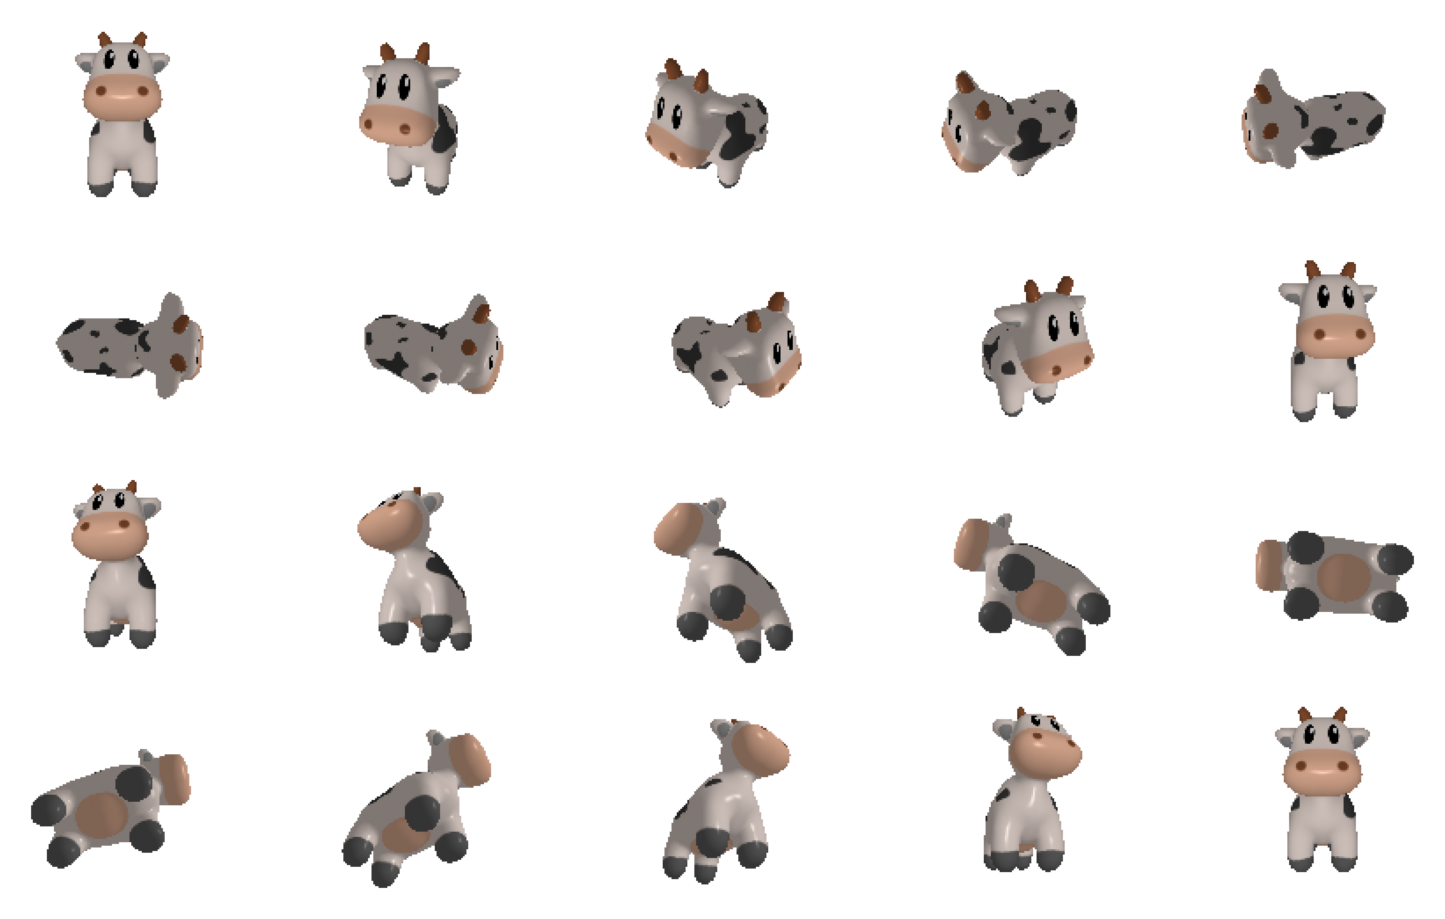

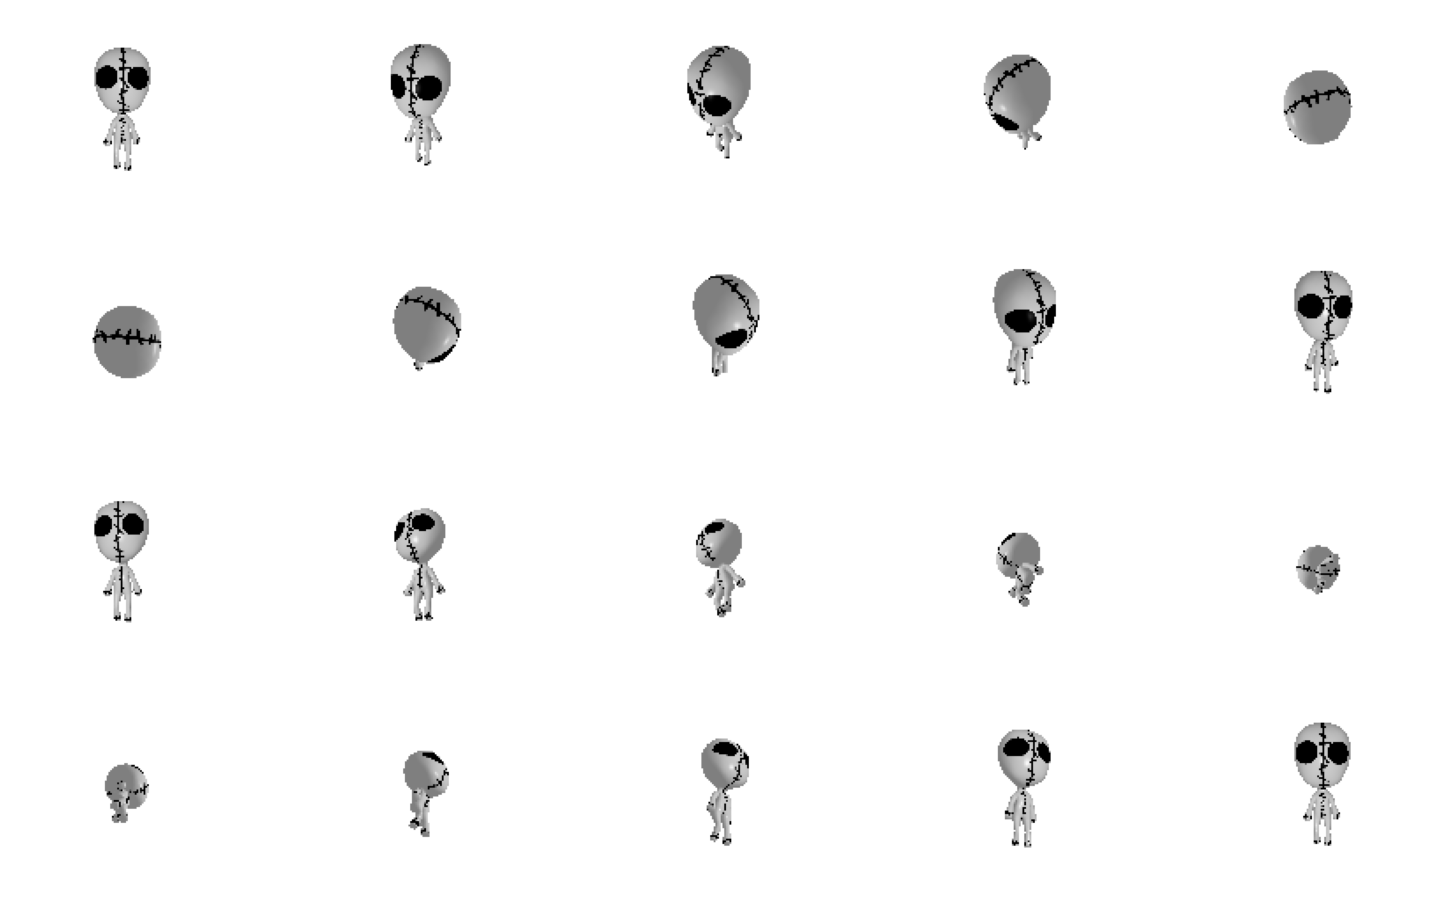

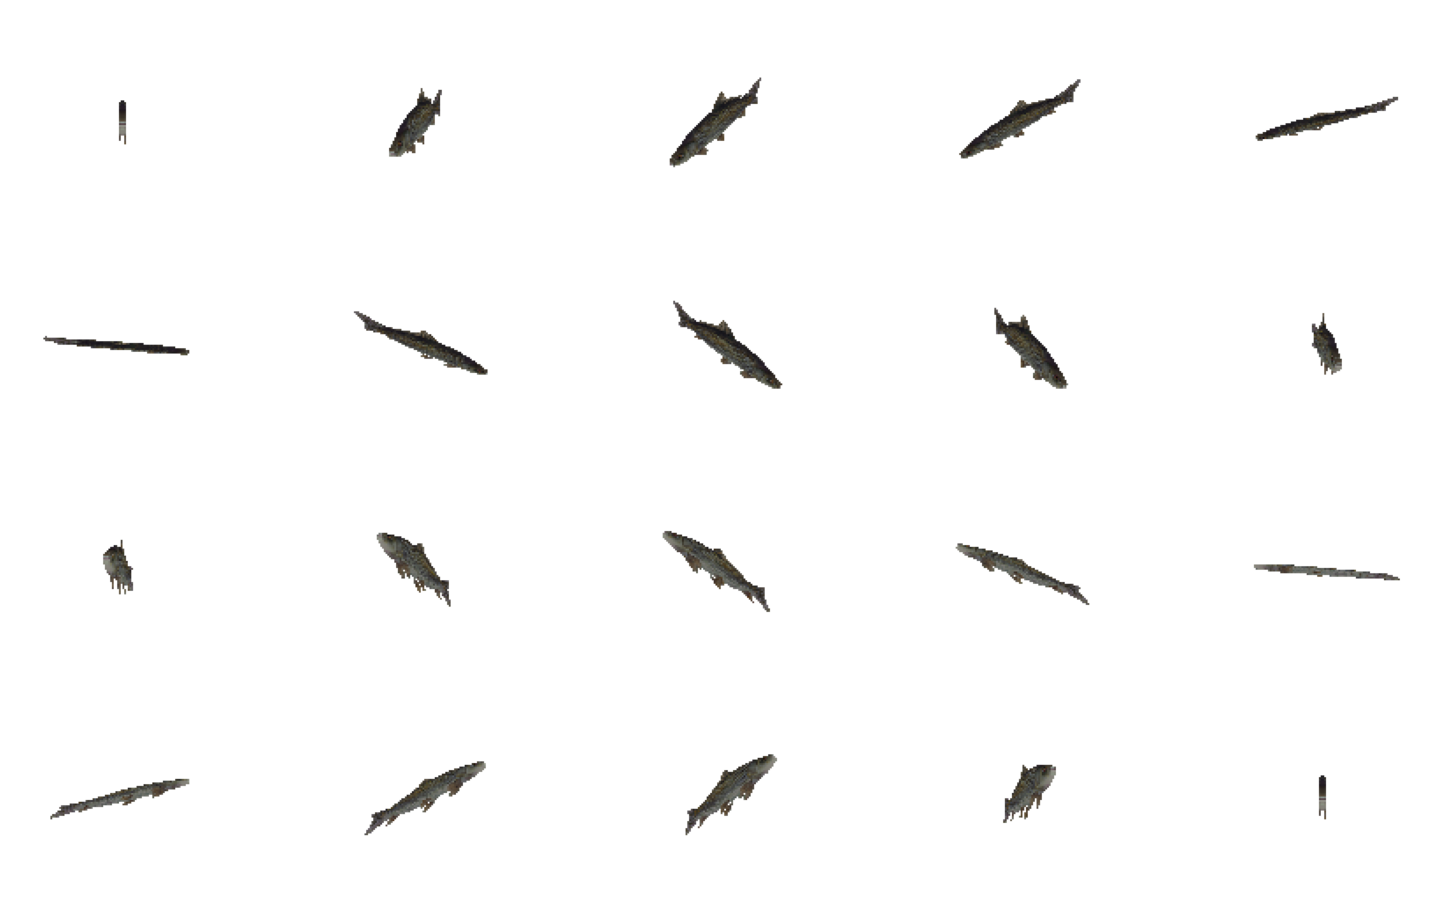

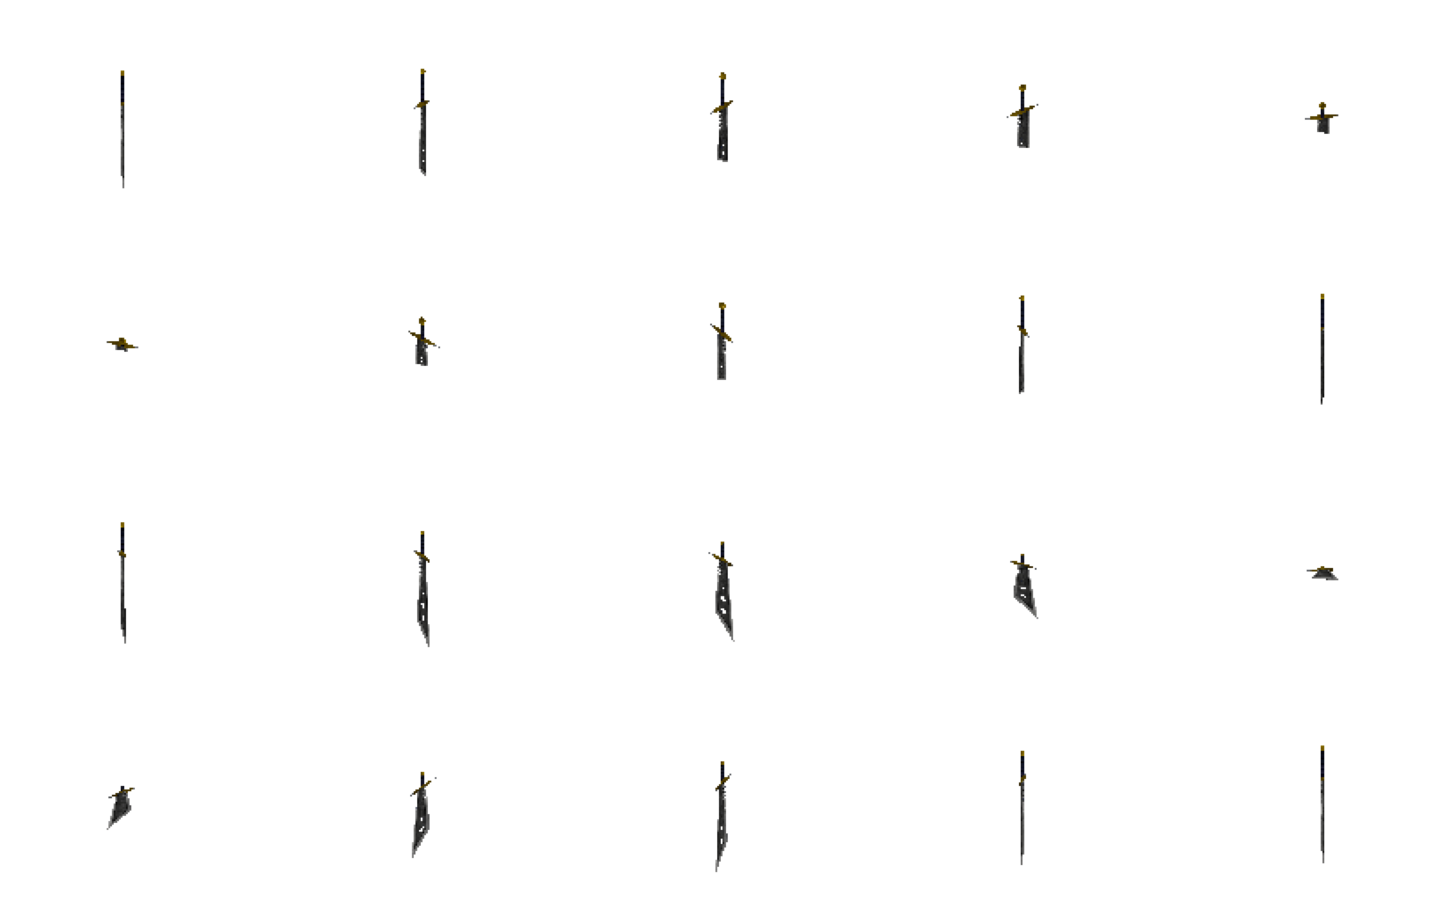

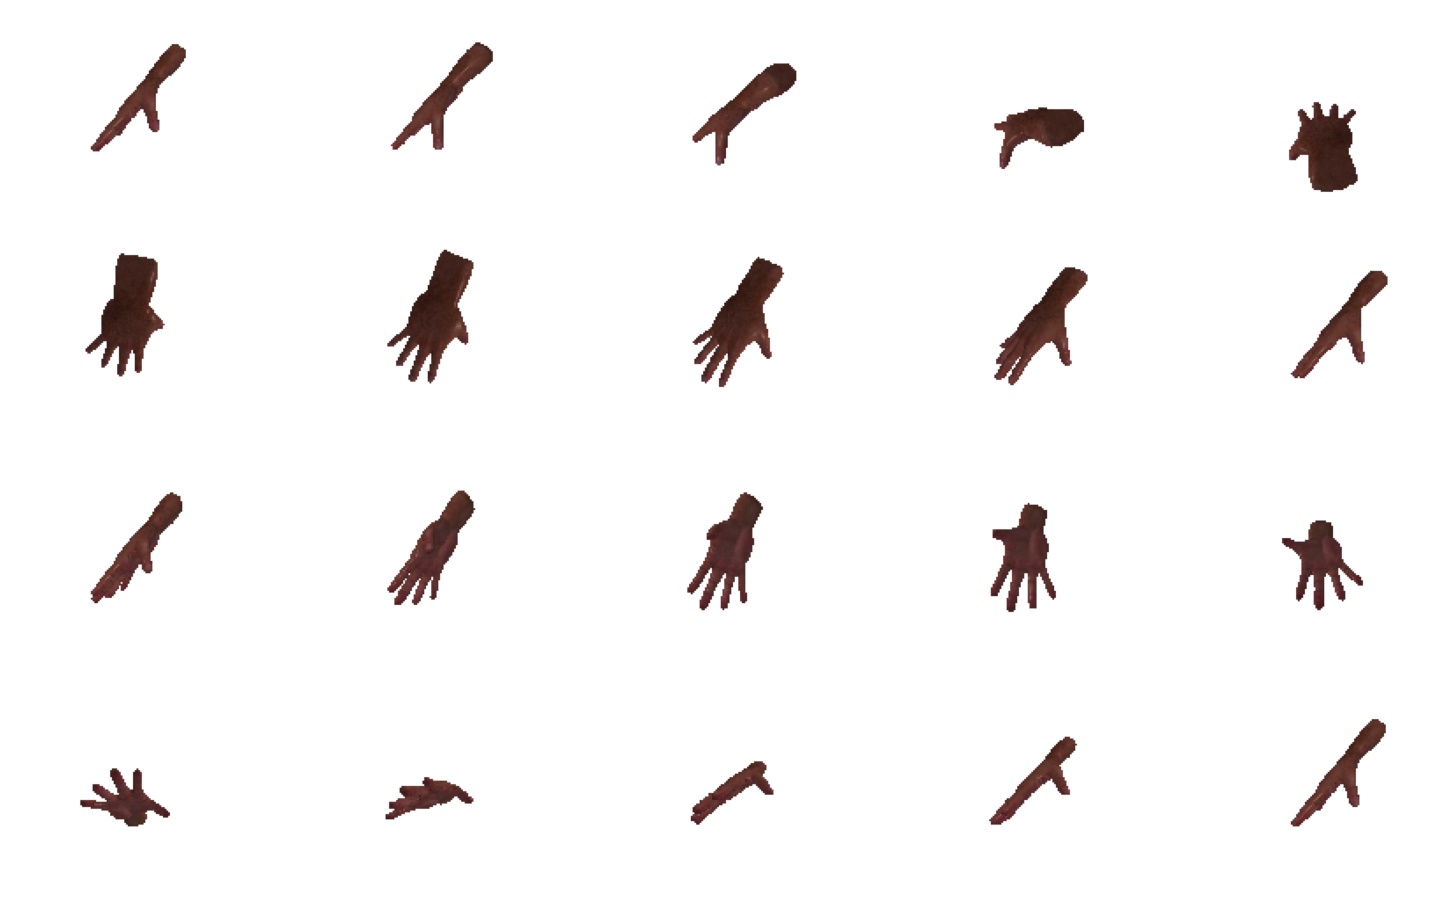

In [ ]:
# Create dataset
target_images_list = []
target_cameras_list = []
target_silhouette_list = []

for mesh in meshes:
    mesh = mesh.extend(num_views)
    target_images = renderer(mesh, cameras=cameras, lights=lights)
    image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
    plt.show()
    target_images_list.append([target_images[i, ..., :3] for i in range(num_views)])
    target_cameras_list.append([FoVPerspectiveCameras(device=device, R=R[None, i, ...], T=T[None, i, ...]) for i in range(num_views)])

    silhouette_images = renderer_silhouette(mesh, cameras=cameras, lights=lights)
    target_silhouette_list.append([silhouette_images[i, ..., 3] for i in range(num_views)])


## 2. Model and loss functions definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import spectral_norm

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_layer(in_channels + i * growth_rate, growth_rate))

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)),
            nn.BatchNorm2d(growth_rate),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, 1))
            features.append(out)
        return torch.cat(features, 1)

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = spectral_norm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1))
        self.key = spectral_norm(nn.Conv2d(in_channels, in_channels // 8, kernel_size=1))
        self.value = spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size=1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        value = self.value(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class Discriminator(nn.Module):
    def __init__(self, input_channels=3, growth_rate=32, num_layers=4):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1))
        self.dense1 = DenseBlock(64, growth_rate, num_layers)
        self.attention1 = SelfAttention(64 + growth_rate * num_layers)
        self.dense2 = DenseBlock(64 + growth_rate * num_layers, growth_rate, num_layers)
        self.attention2 = SelfAttention(64 + 2 * growth_rate * num_layers)
        self.conv2 = spectral_norm(nn.Conv2d(64 + 2 * growth_rate * num_layers, 1, kernel_size=4, stride=1, padding=0))

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.dense1(out)
        out = self.attention1(out)
        out = self.dense2(out)
        out = self.attention2(out)
        out = self.conv2(out)
        return torch.sigmoid(out)

In [ ]:
# Initialize the discriminator
discriminator = Discriminator().to(device)

# Loss functions
adversarial_loss = nn.BCELoss()

In [ ]:
# Losses and functions
def update_mesh_shape_prior_losses(mesh, loss):
    loss["edge"] = mesh_edge_loss(mesh)
    loss["normal"] = mesh_normal_consistency(mesh)
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_images_list[0][1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

In [ ]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=camera,
        lights=lights)
)

In [ ]:
def compute_silhouette_iou(predicted_silhouette, target_silhouette):
    intersection = (predicted_silhouette & target_silhouette).float().sum((1, 2))
    union = (predicted_silhouette | target_silhouette).float().sum((1, 2))
    iou = intersection / union
    return iou.mean().item()

# Store Chamfer Distance and IoU values
chamfer_distances = []
iou_values = []

## 3. Shape deforming loop

  0%|          | 0/2001 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


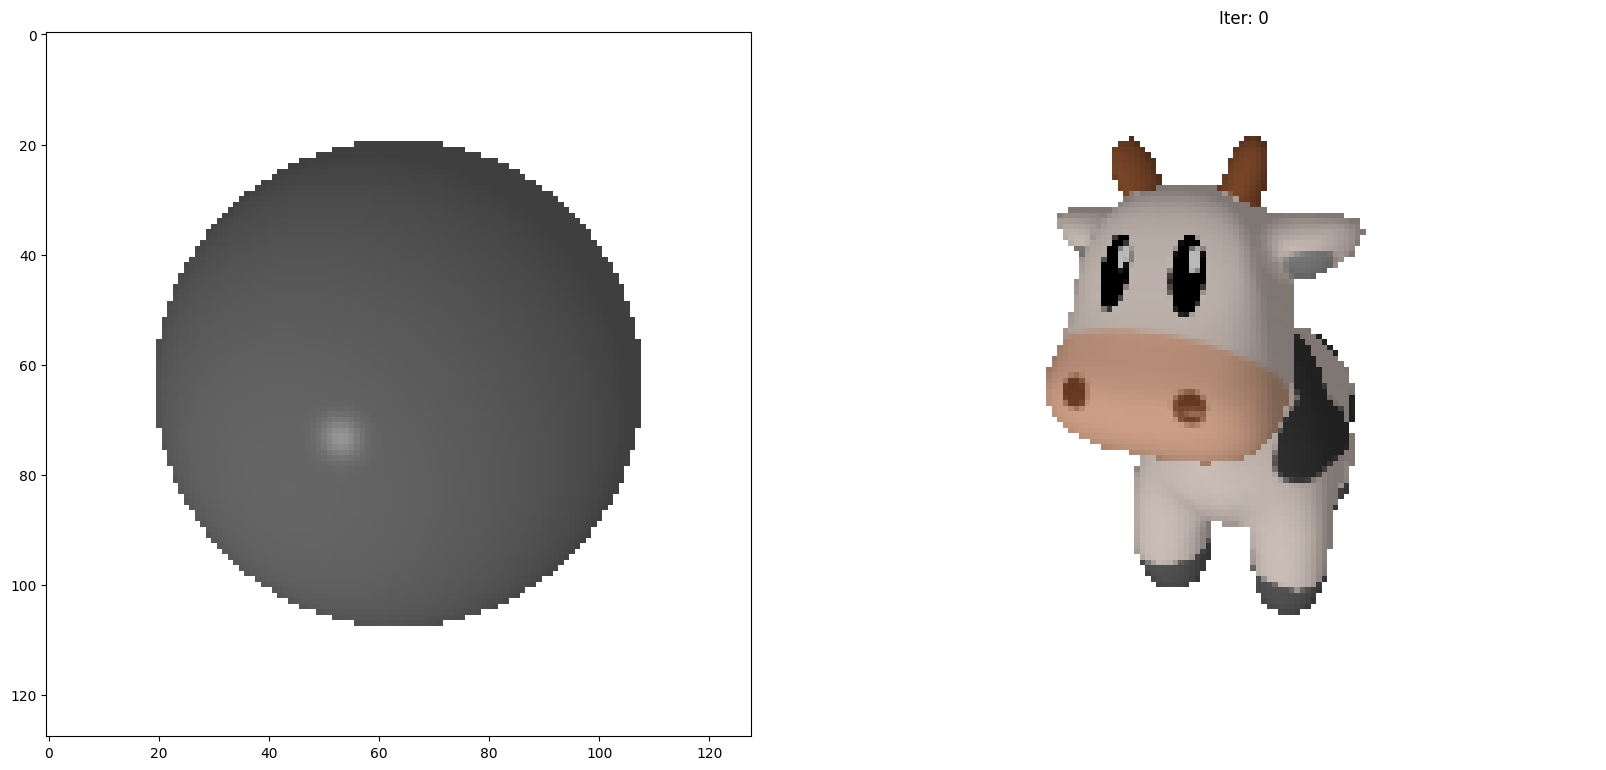

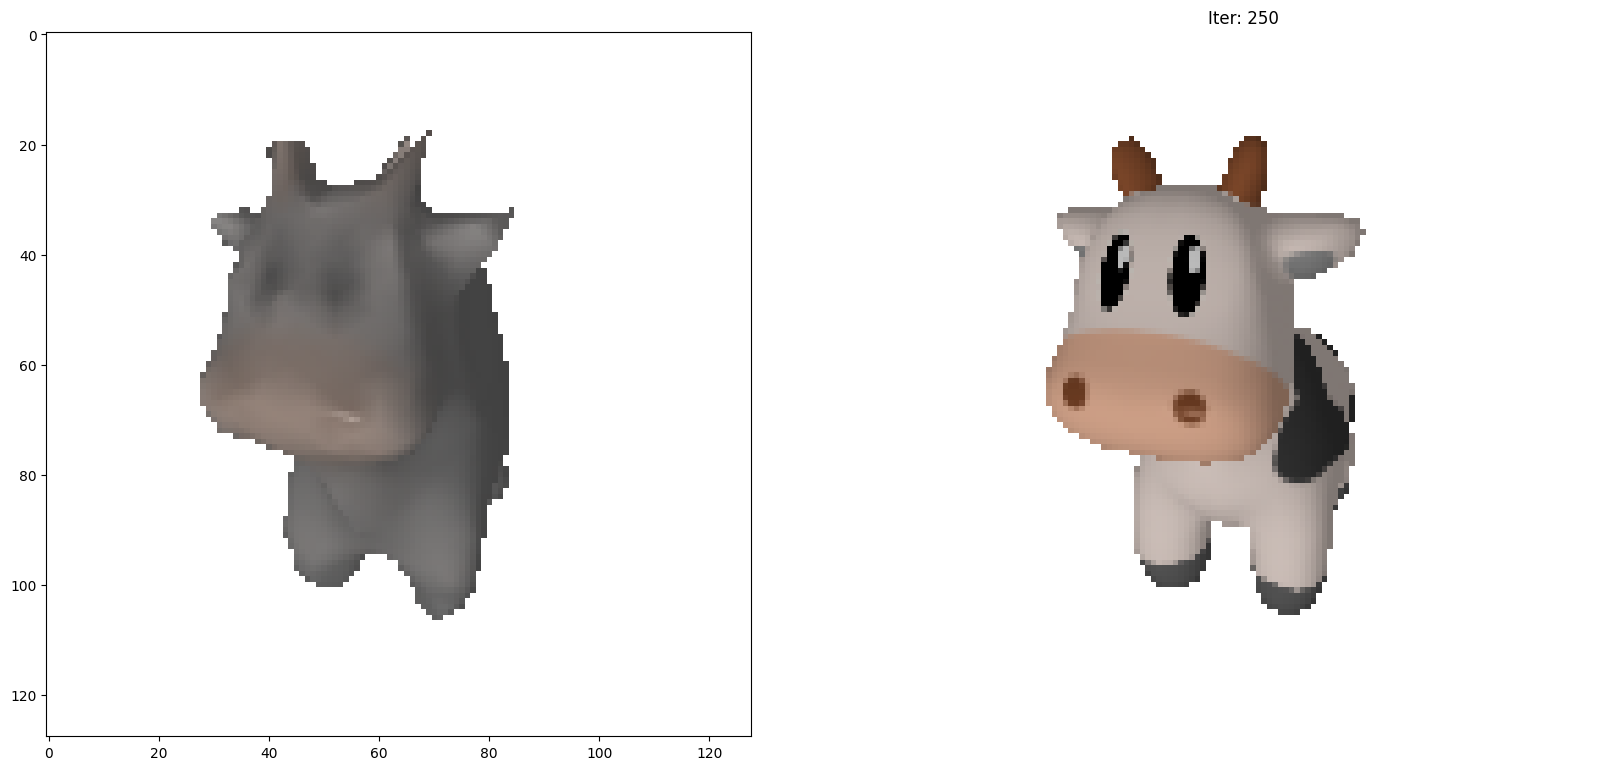

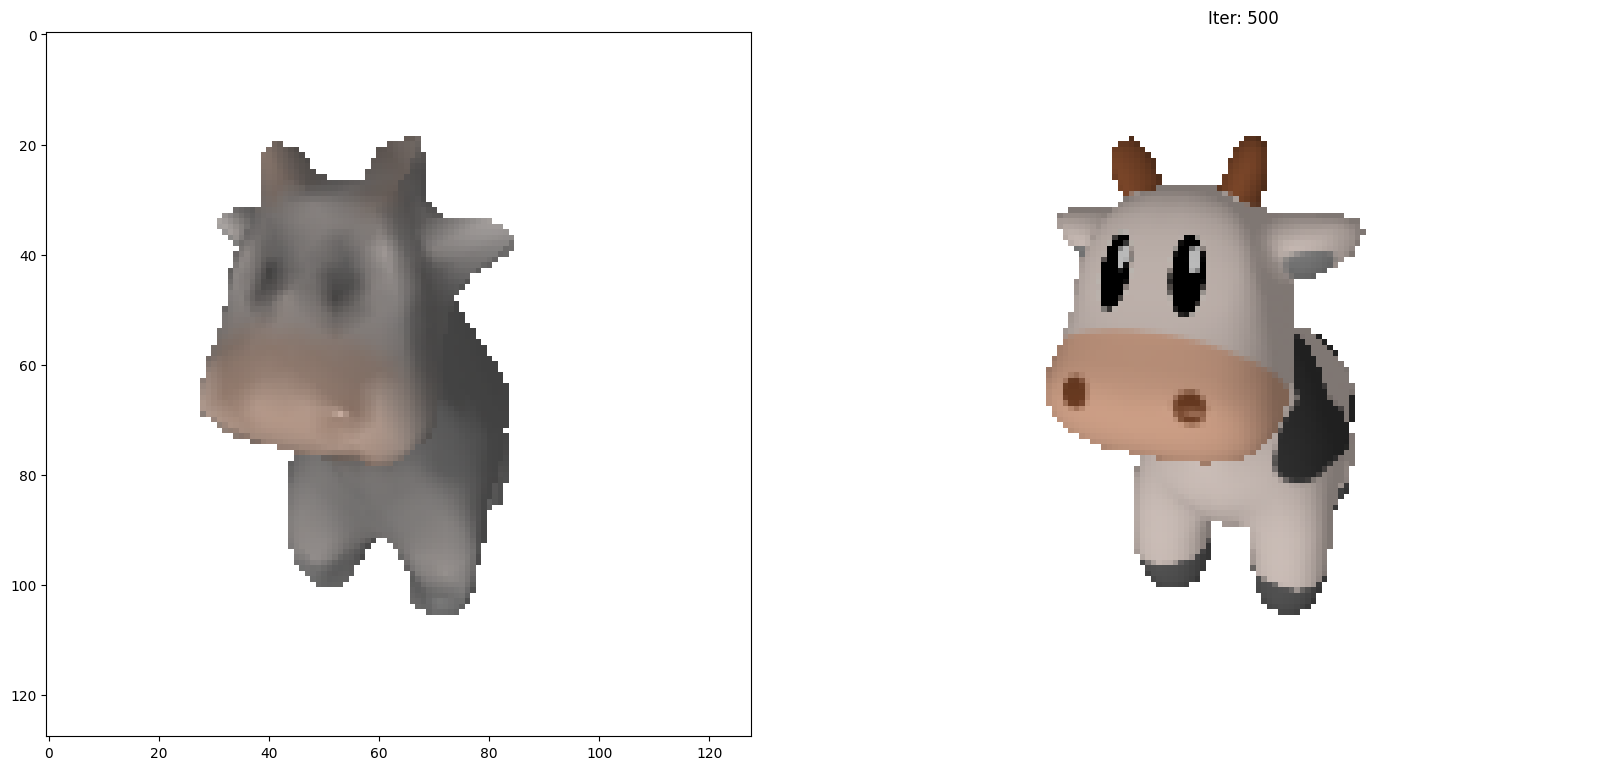

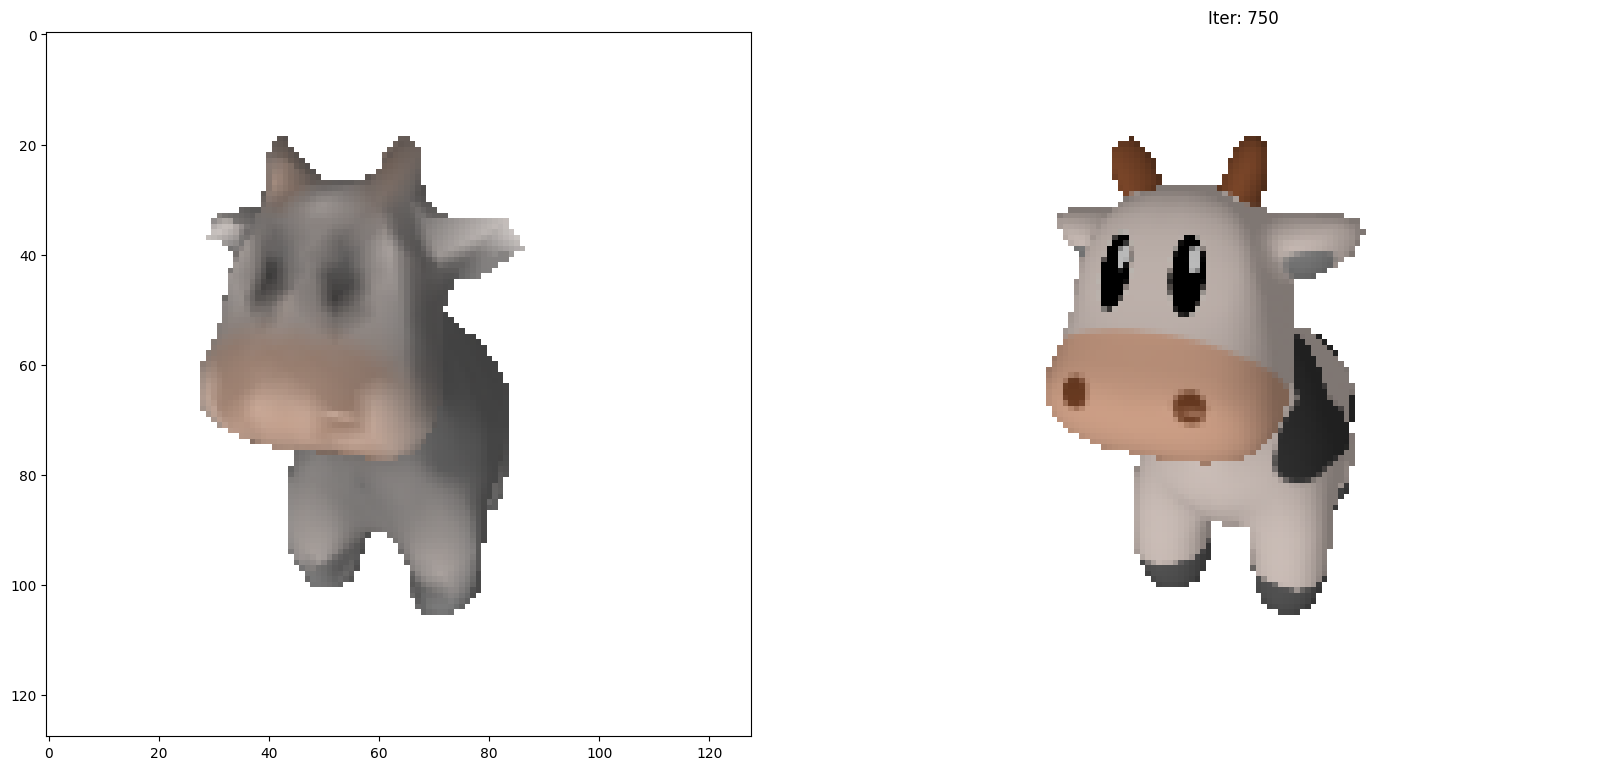

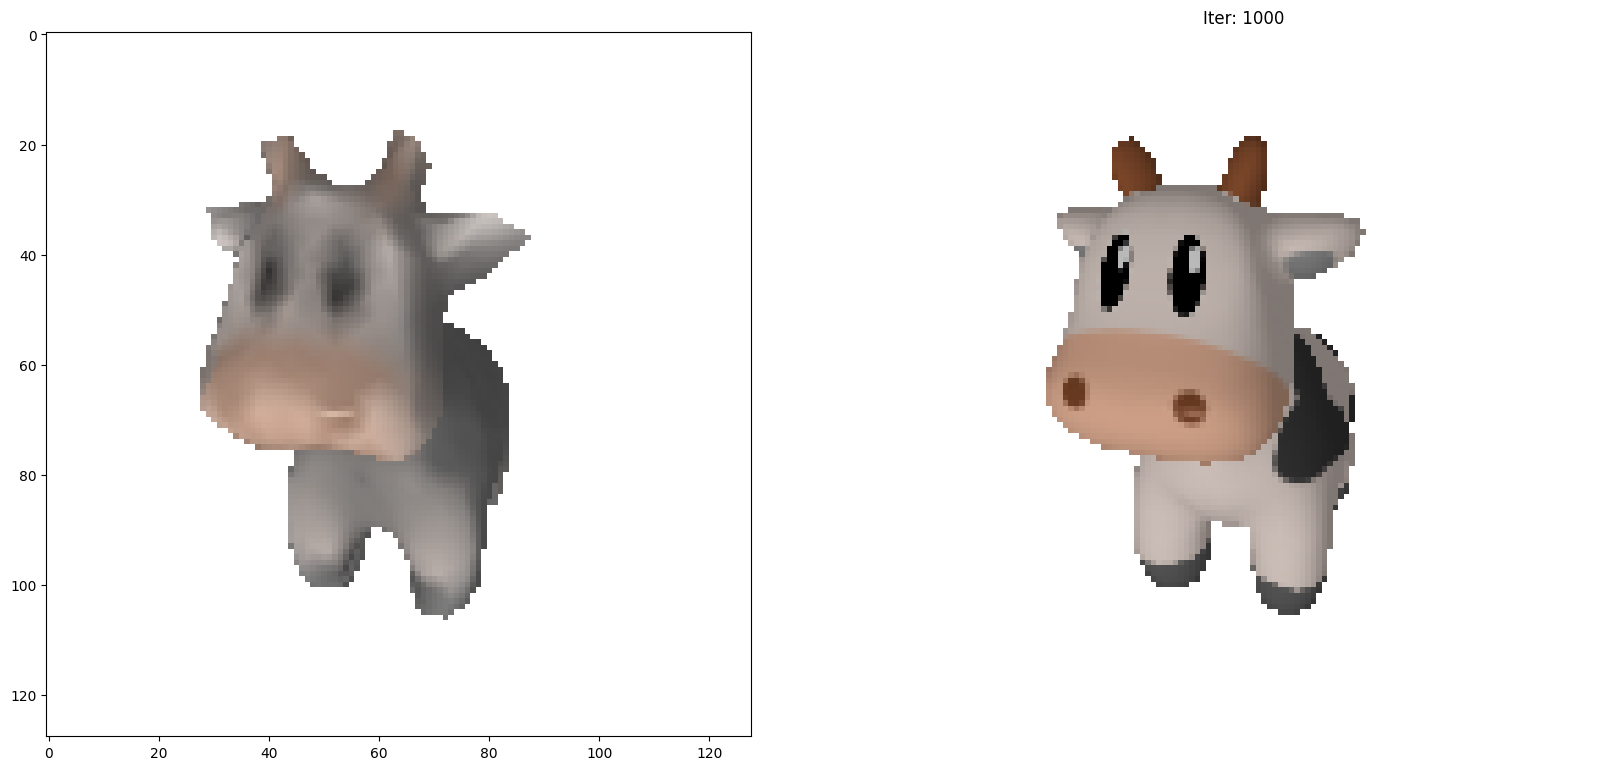

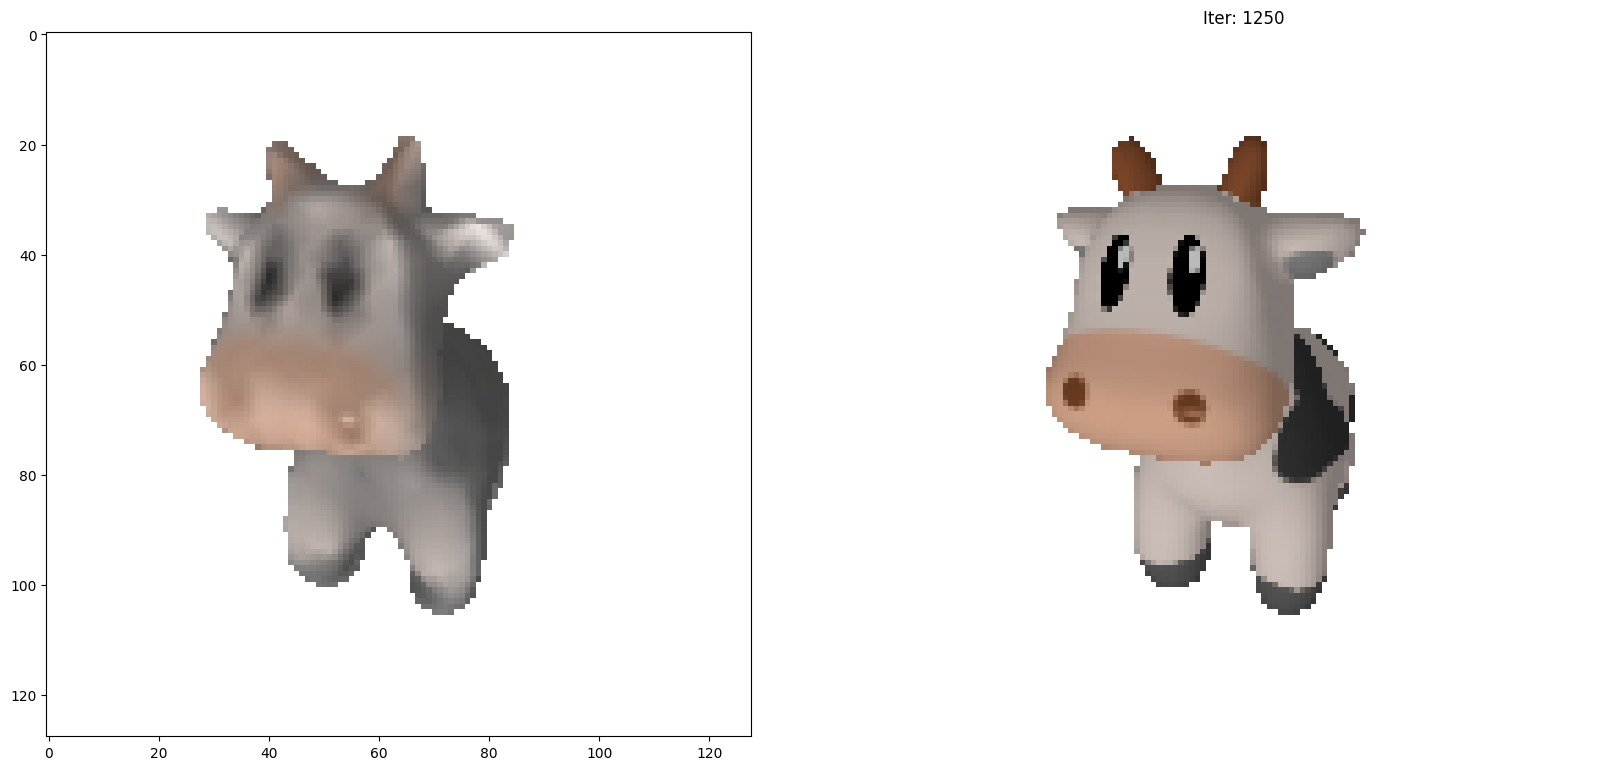

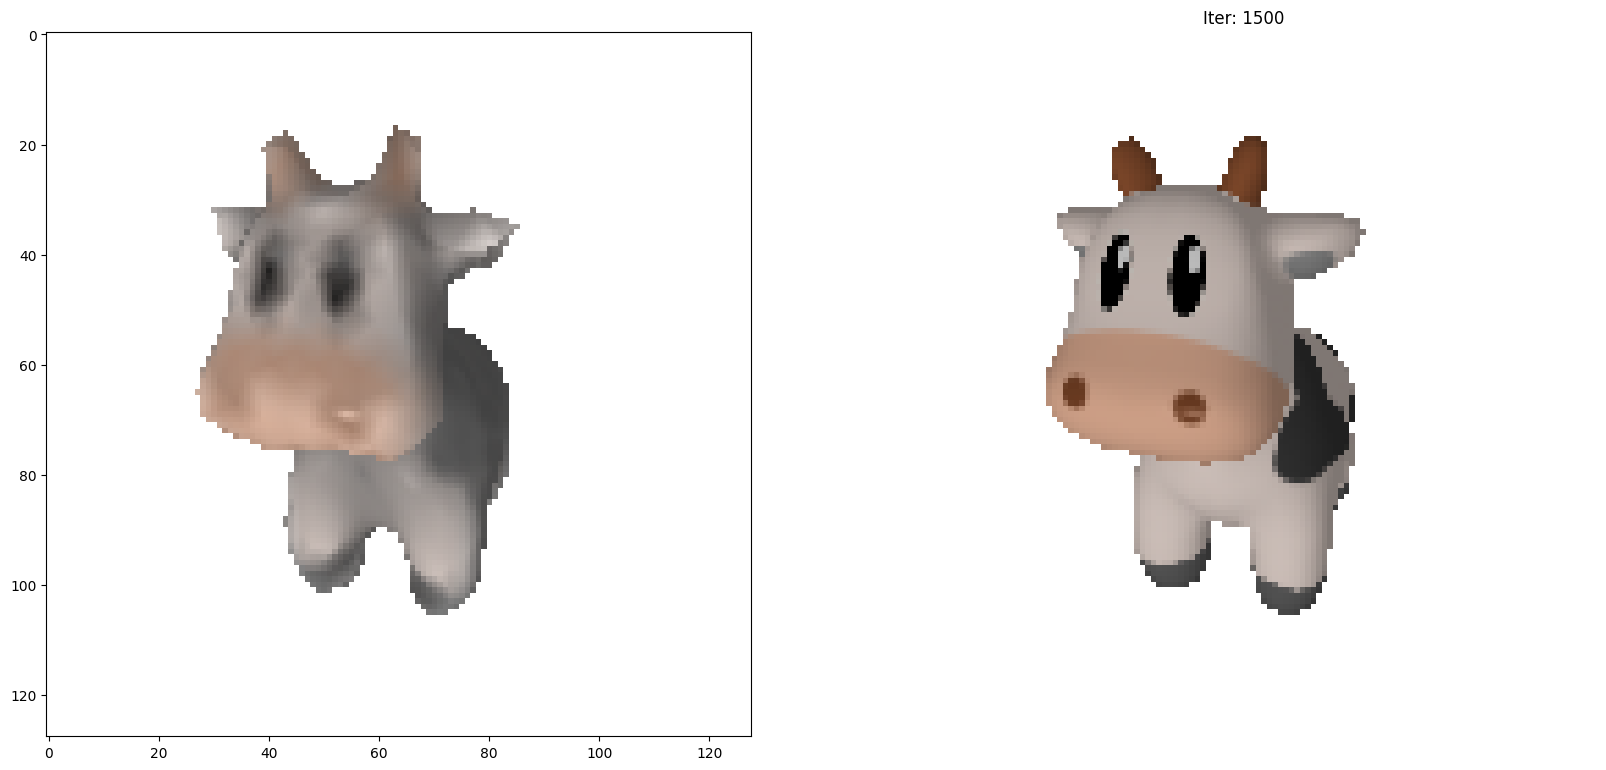

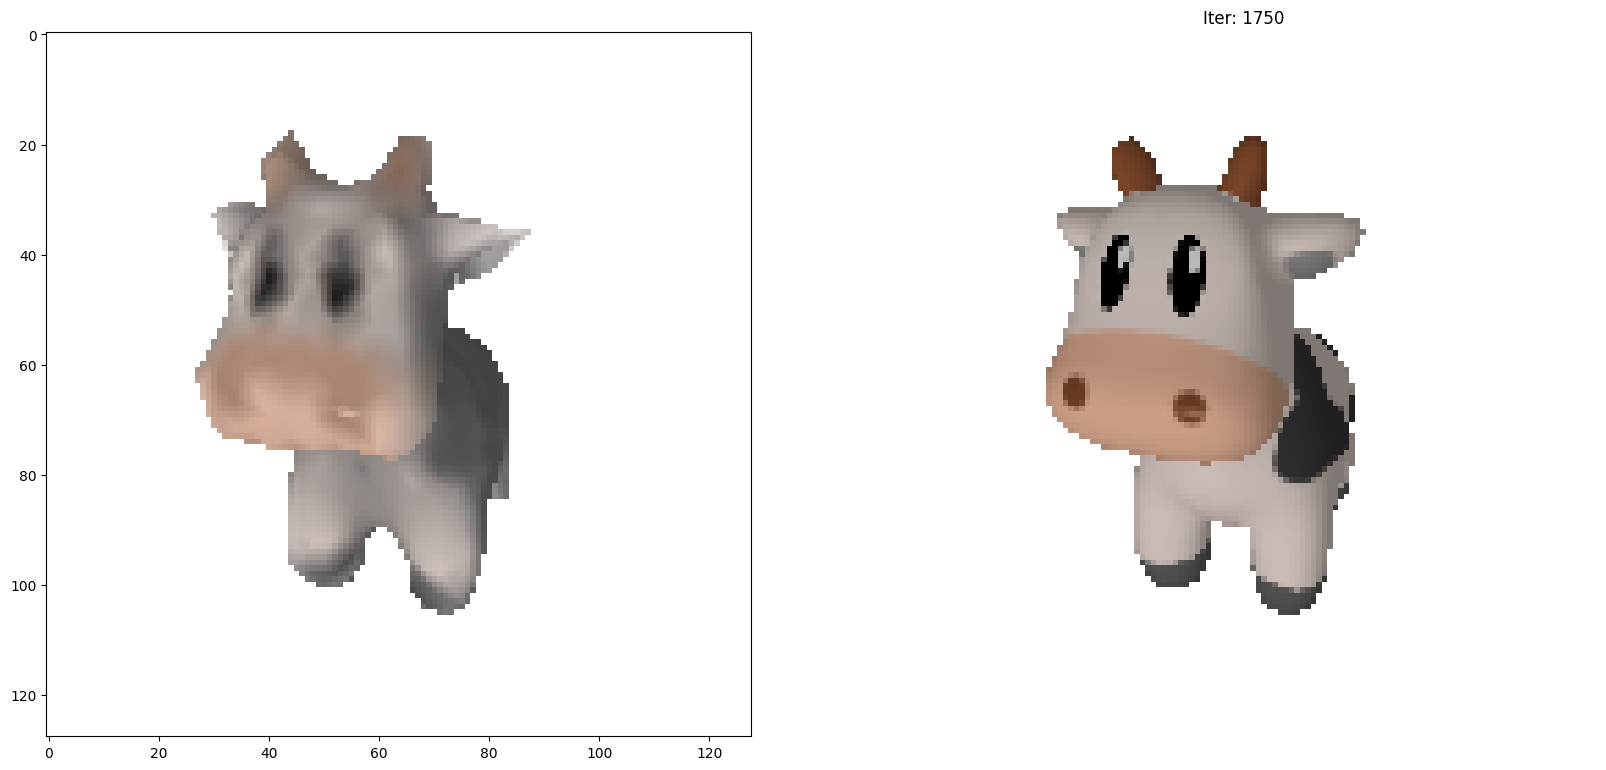

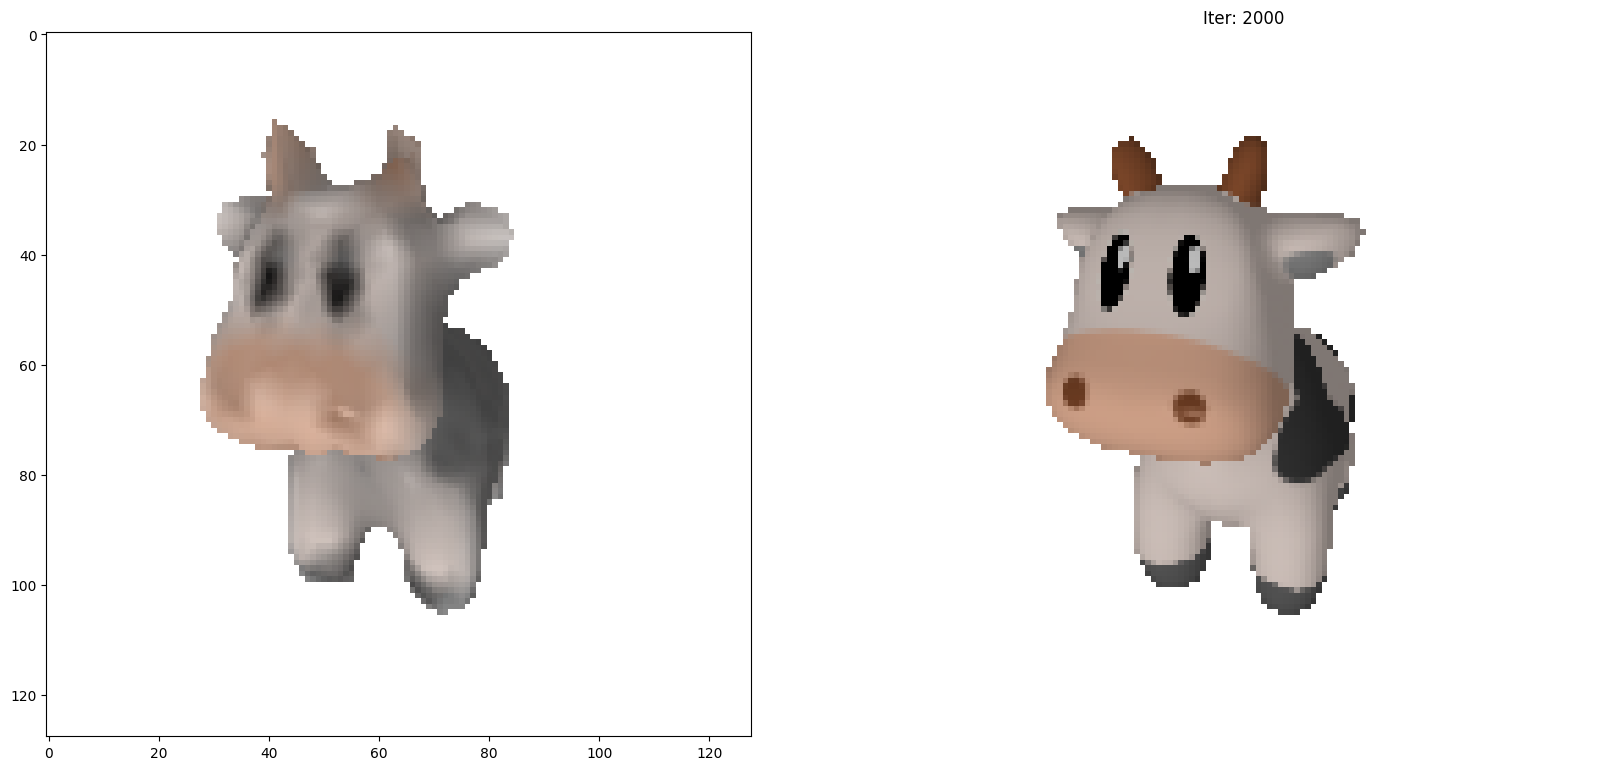

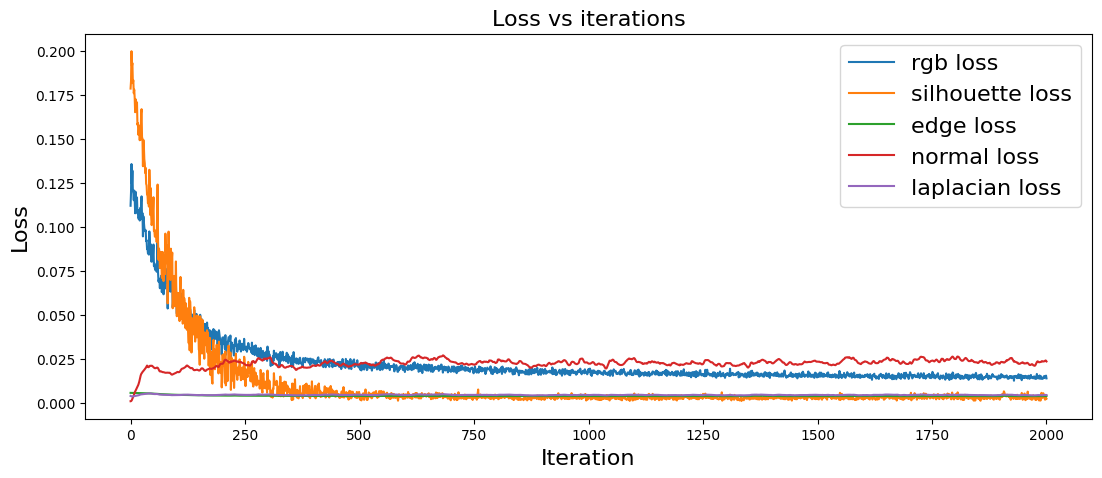

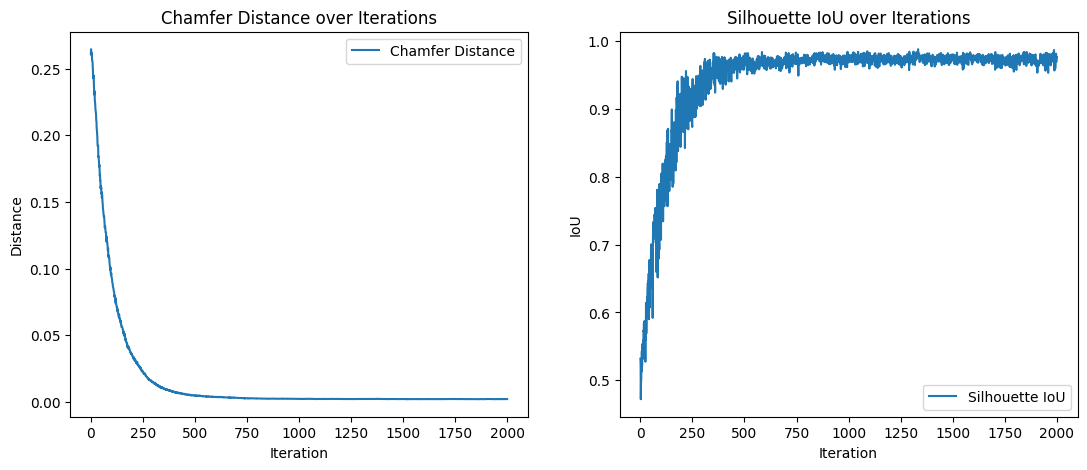

Training cycle with object 1 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

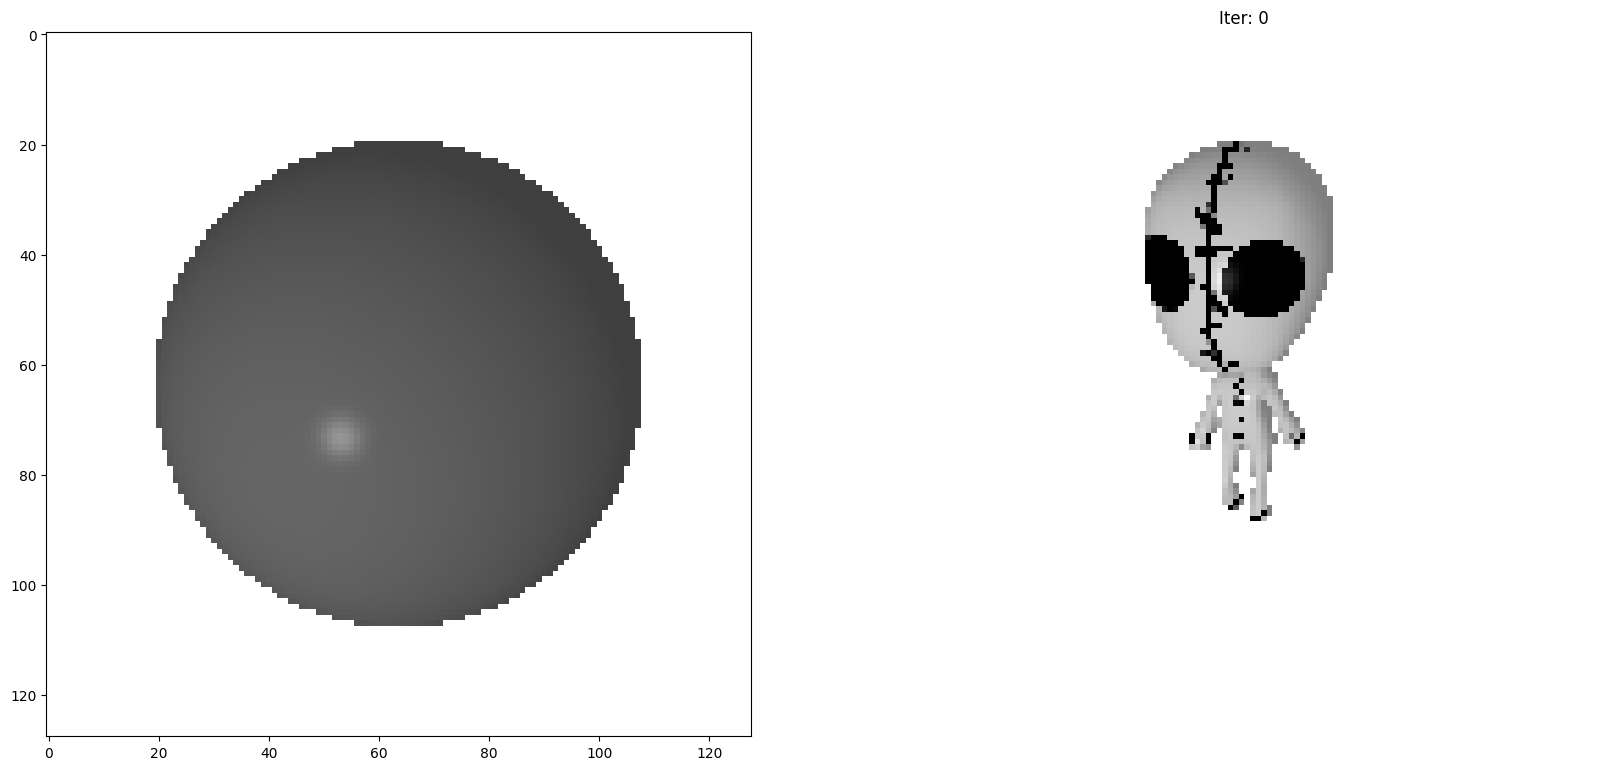

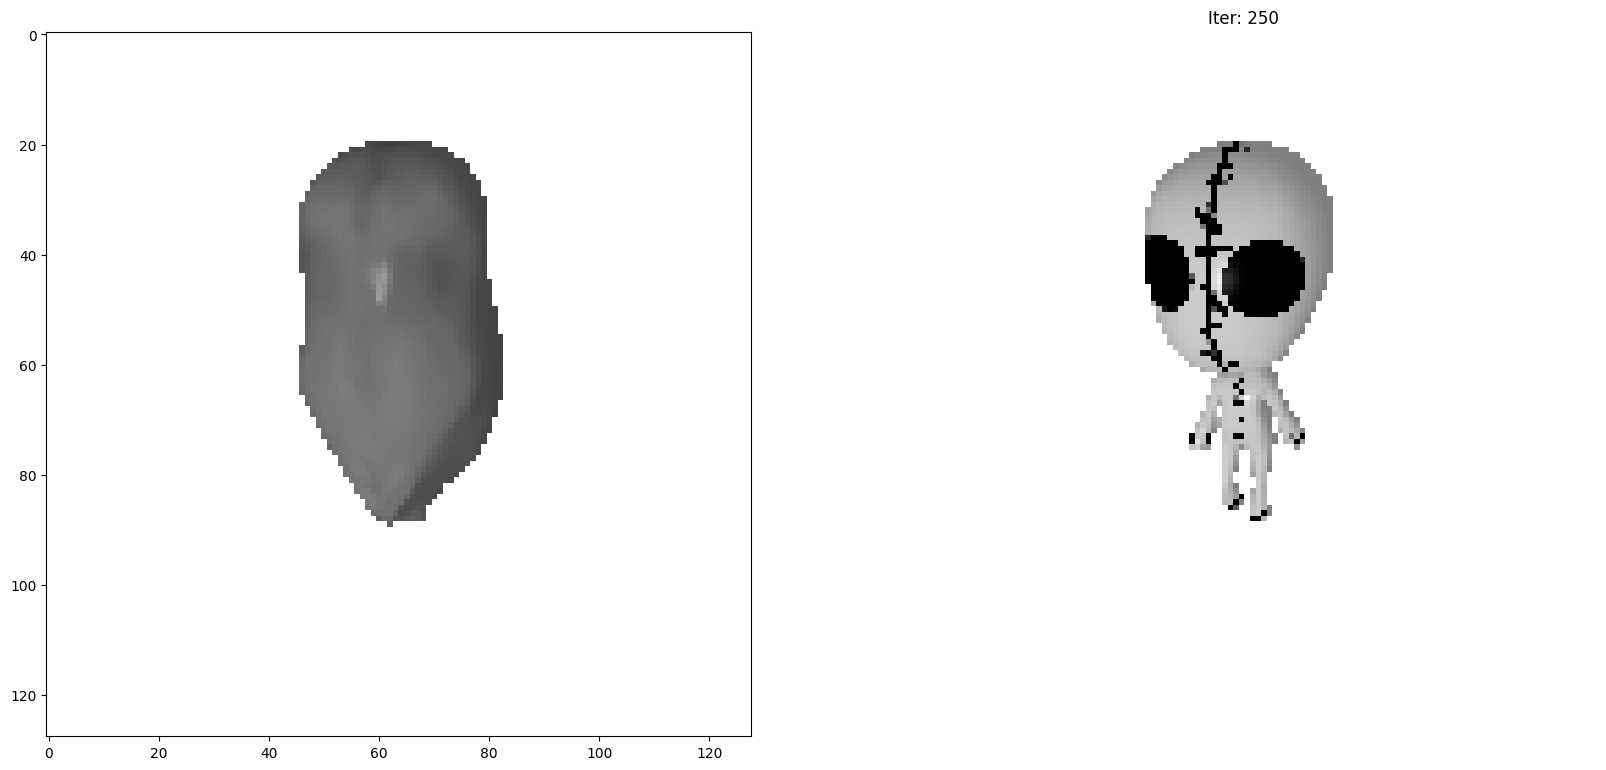

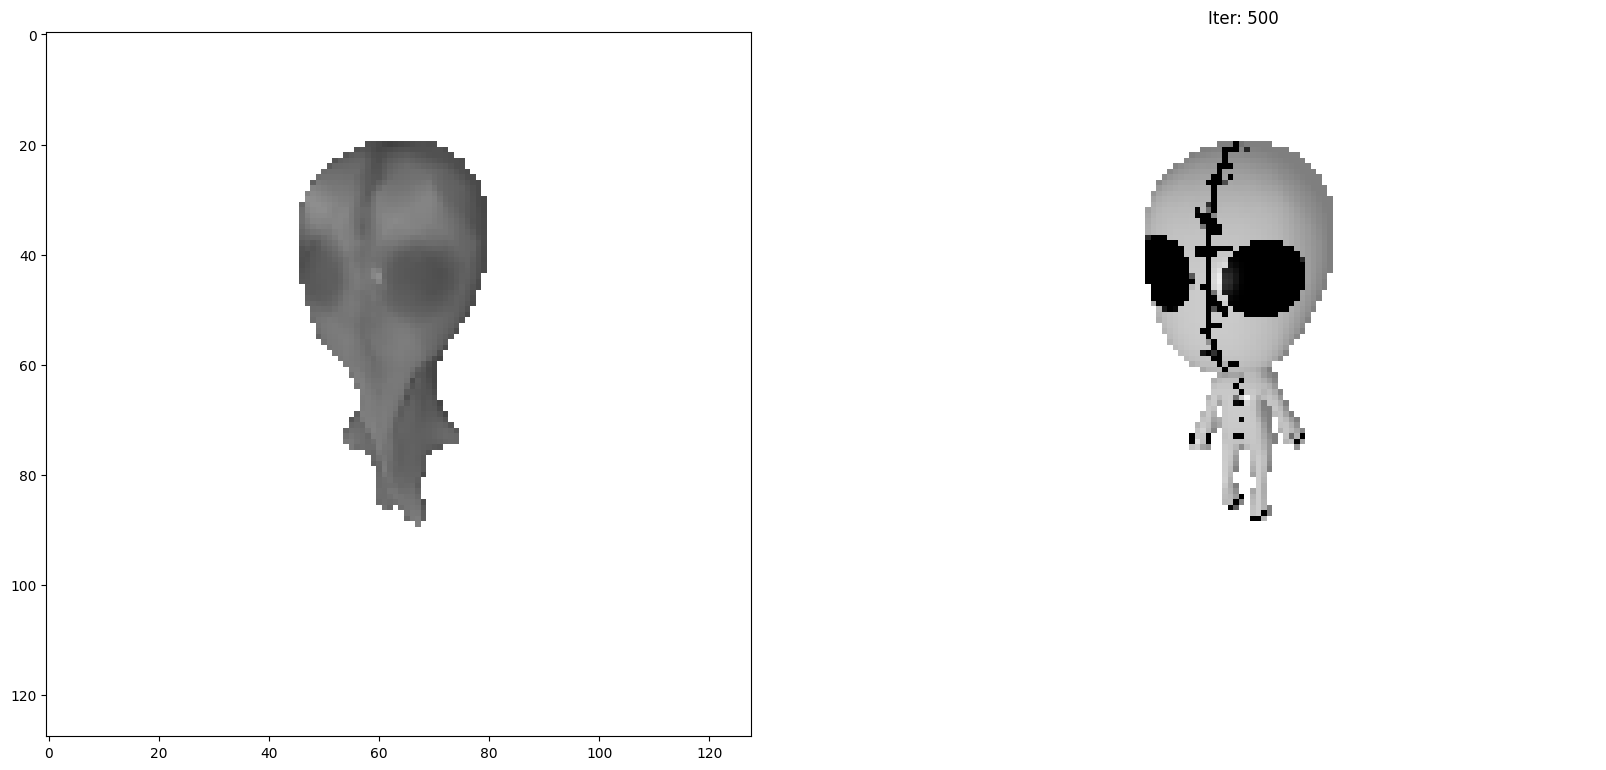

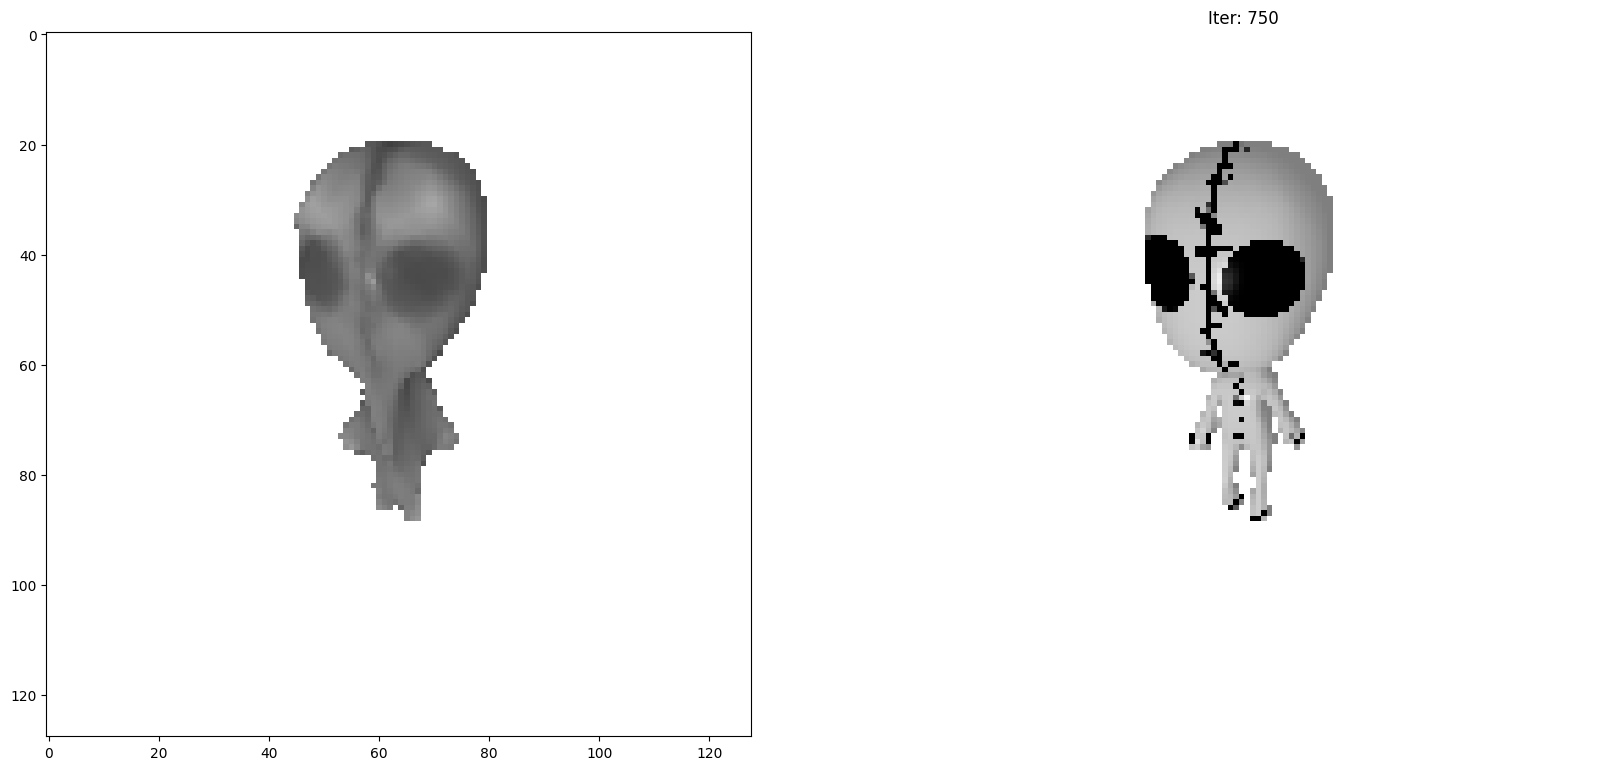

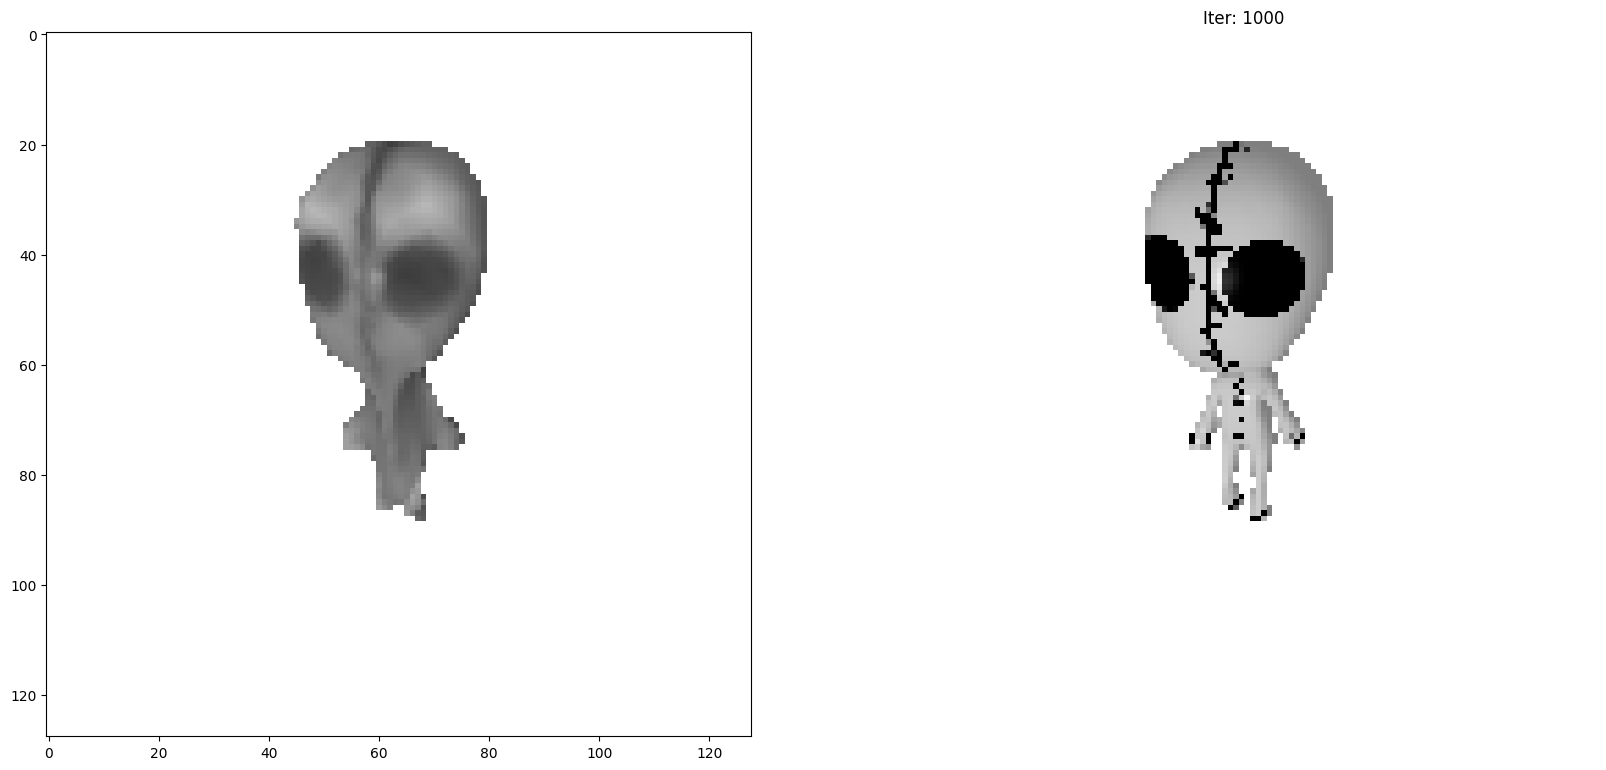

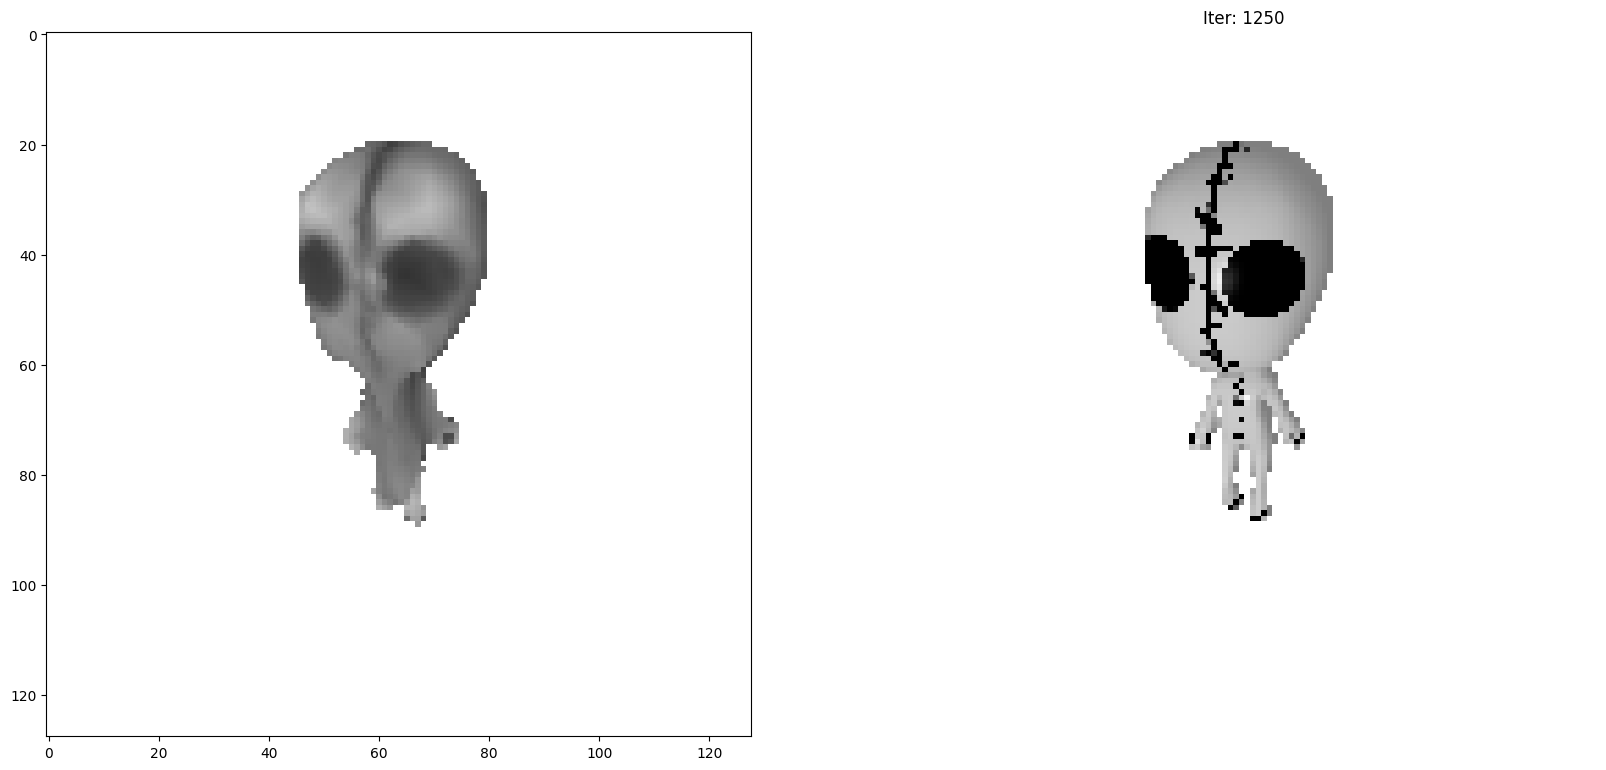

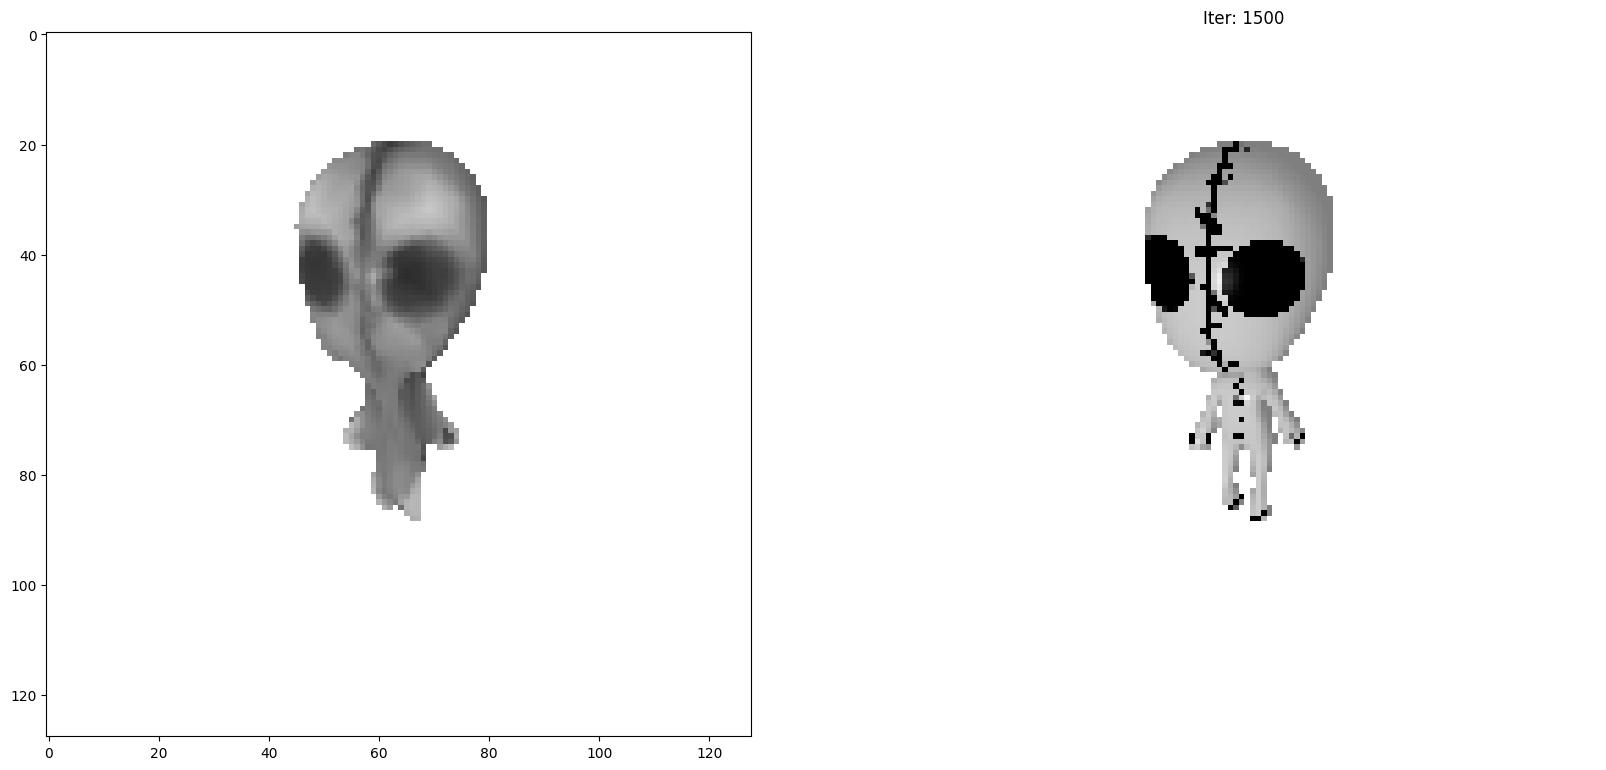

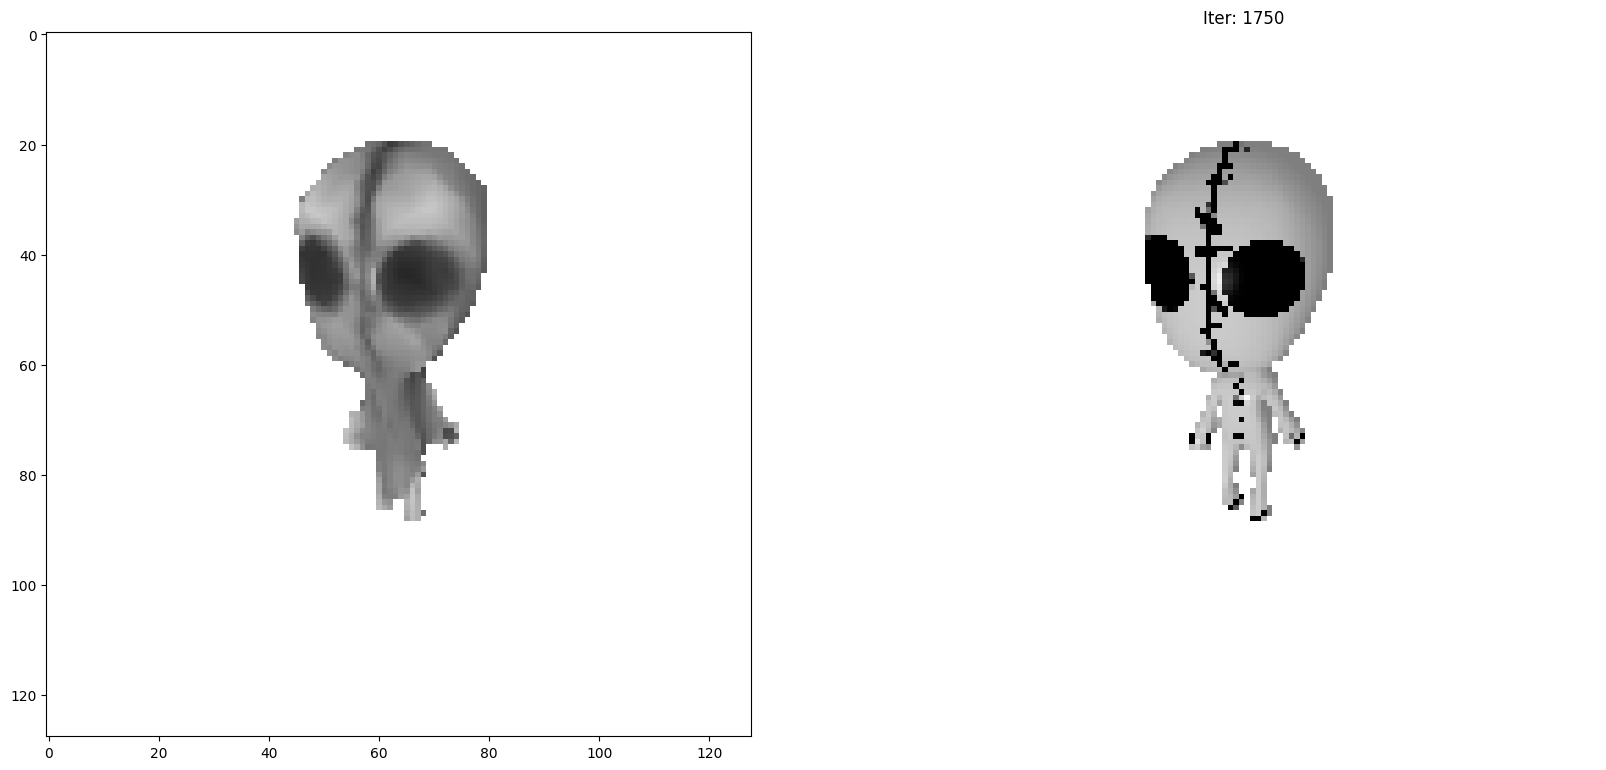

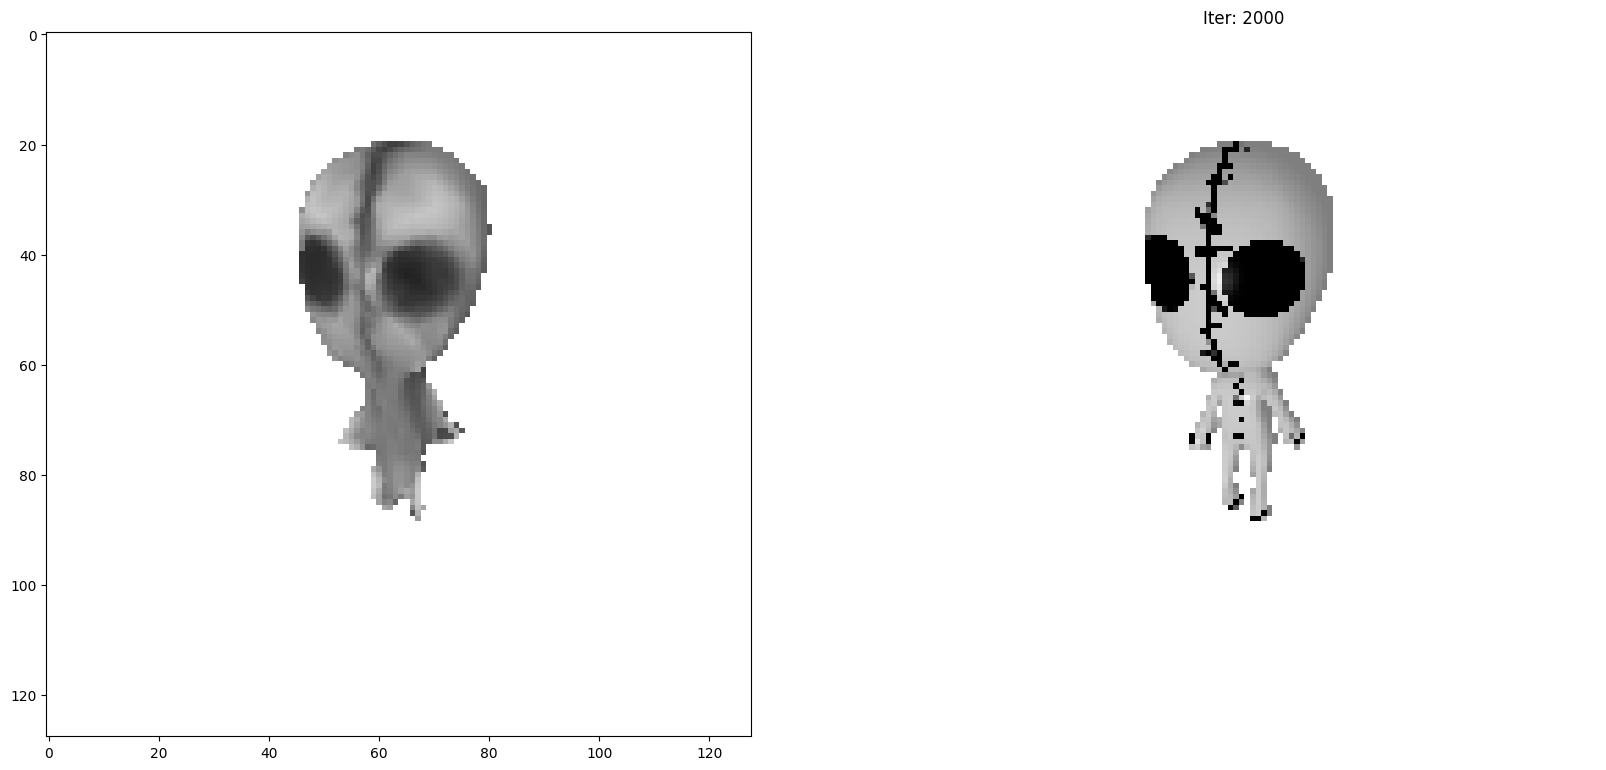

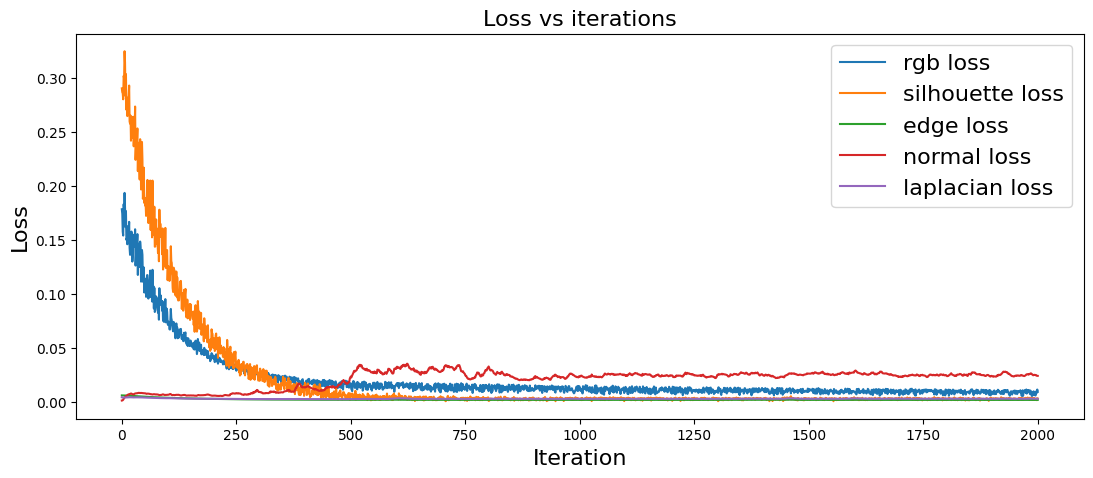

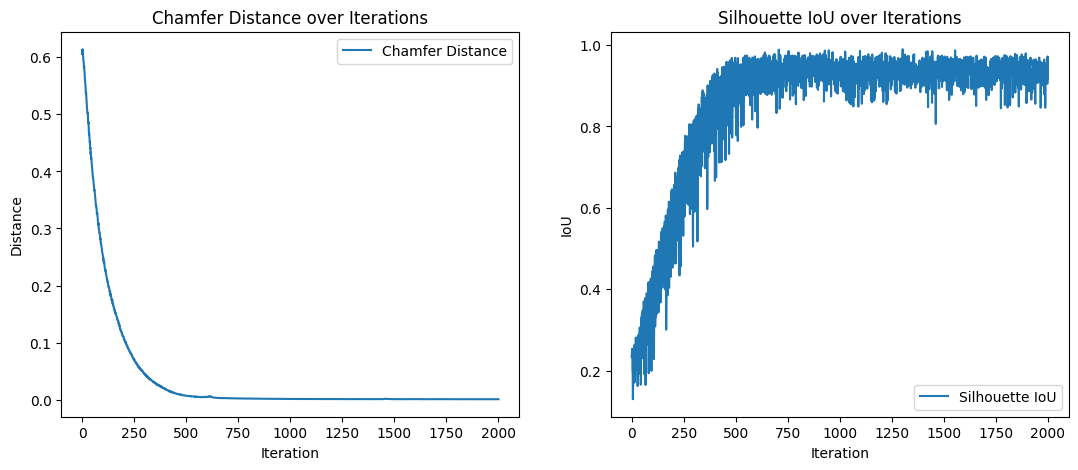

Training cycle with object 2 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

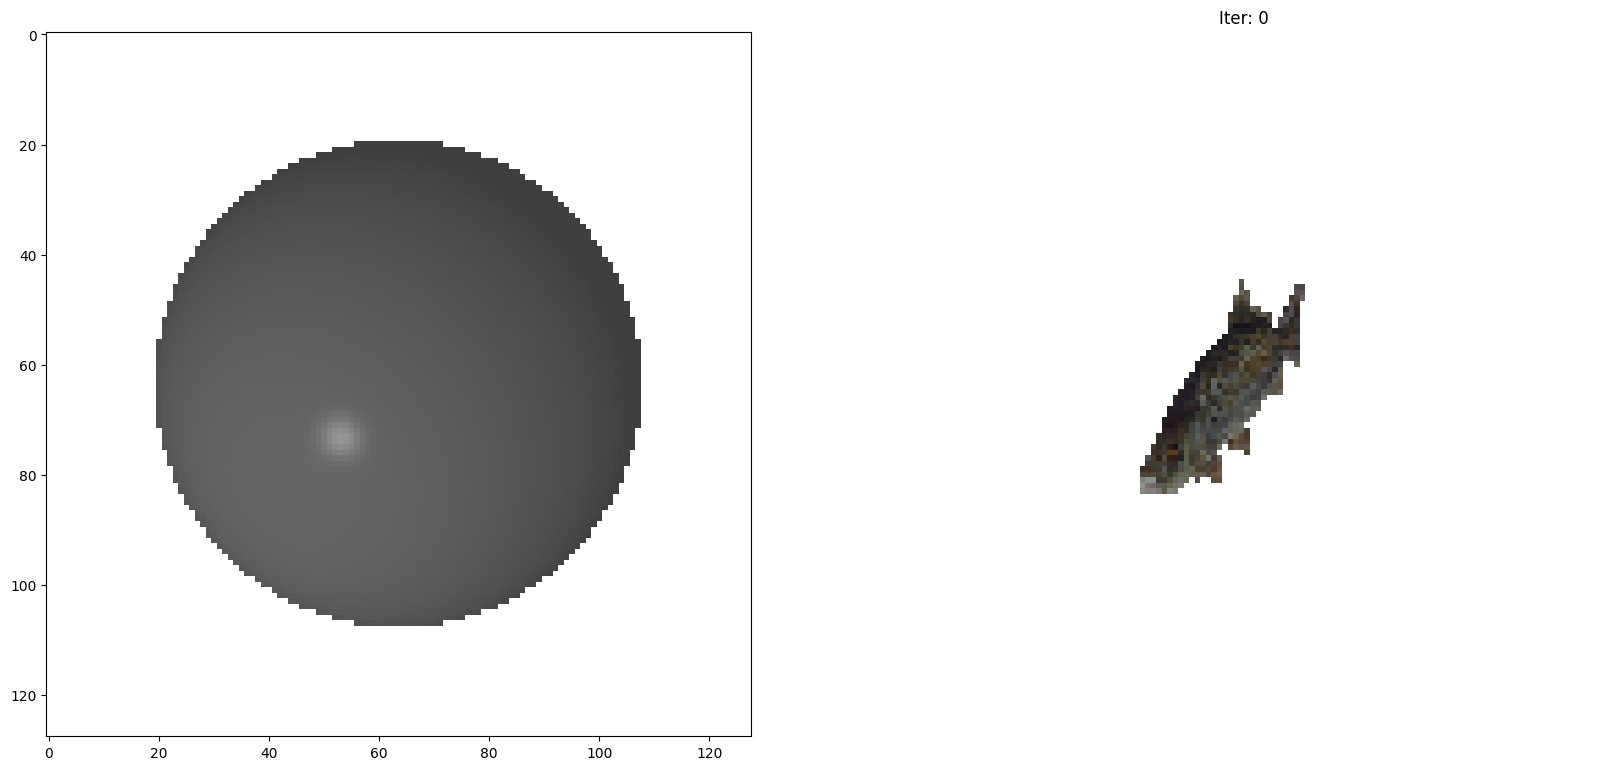

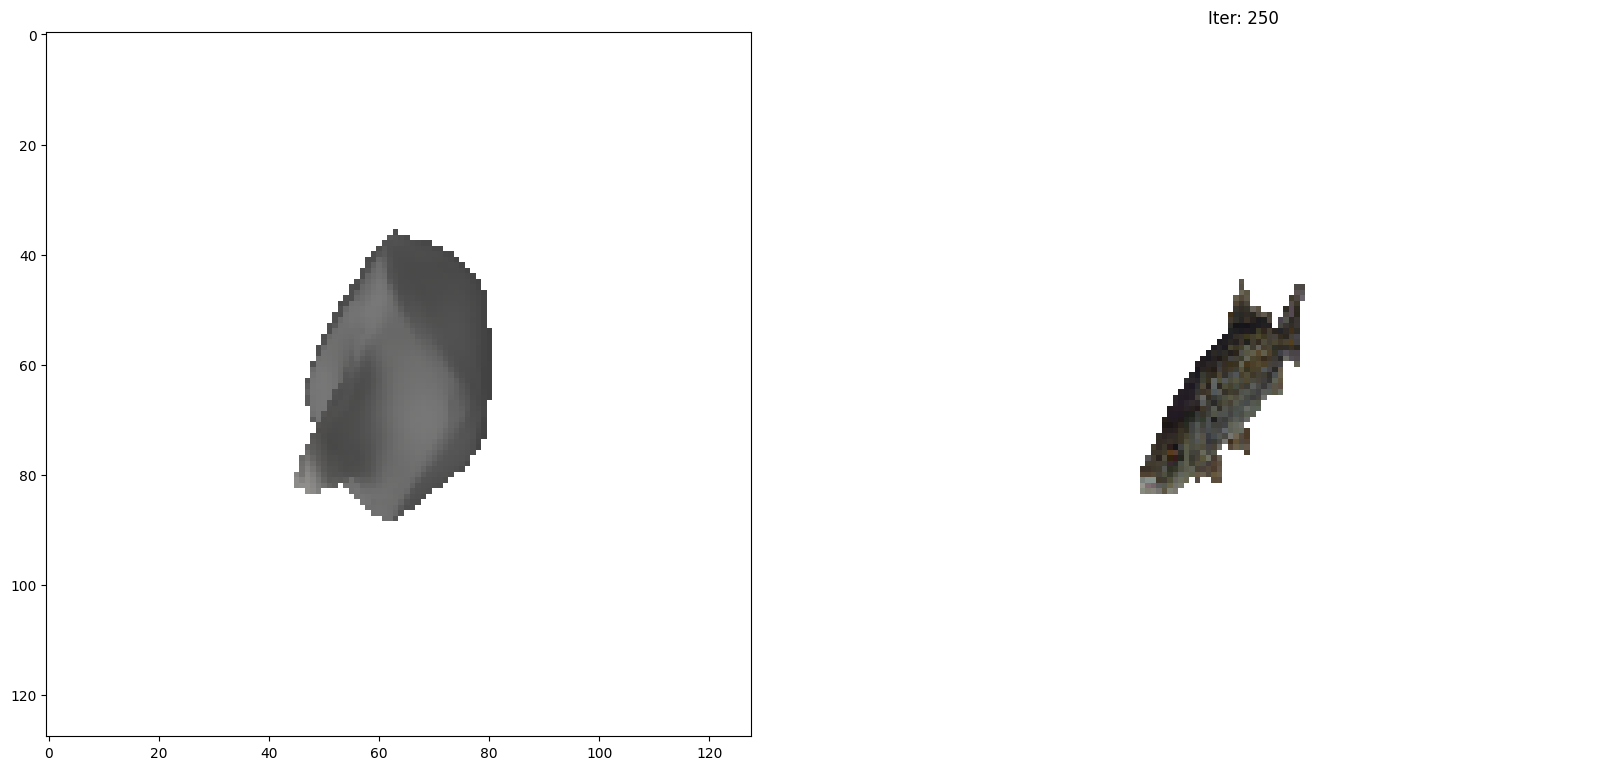

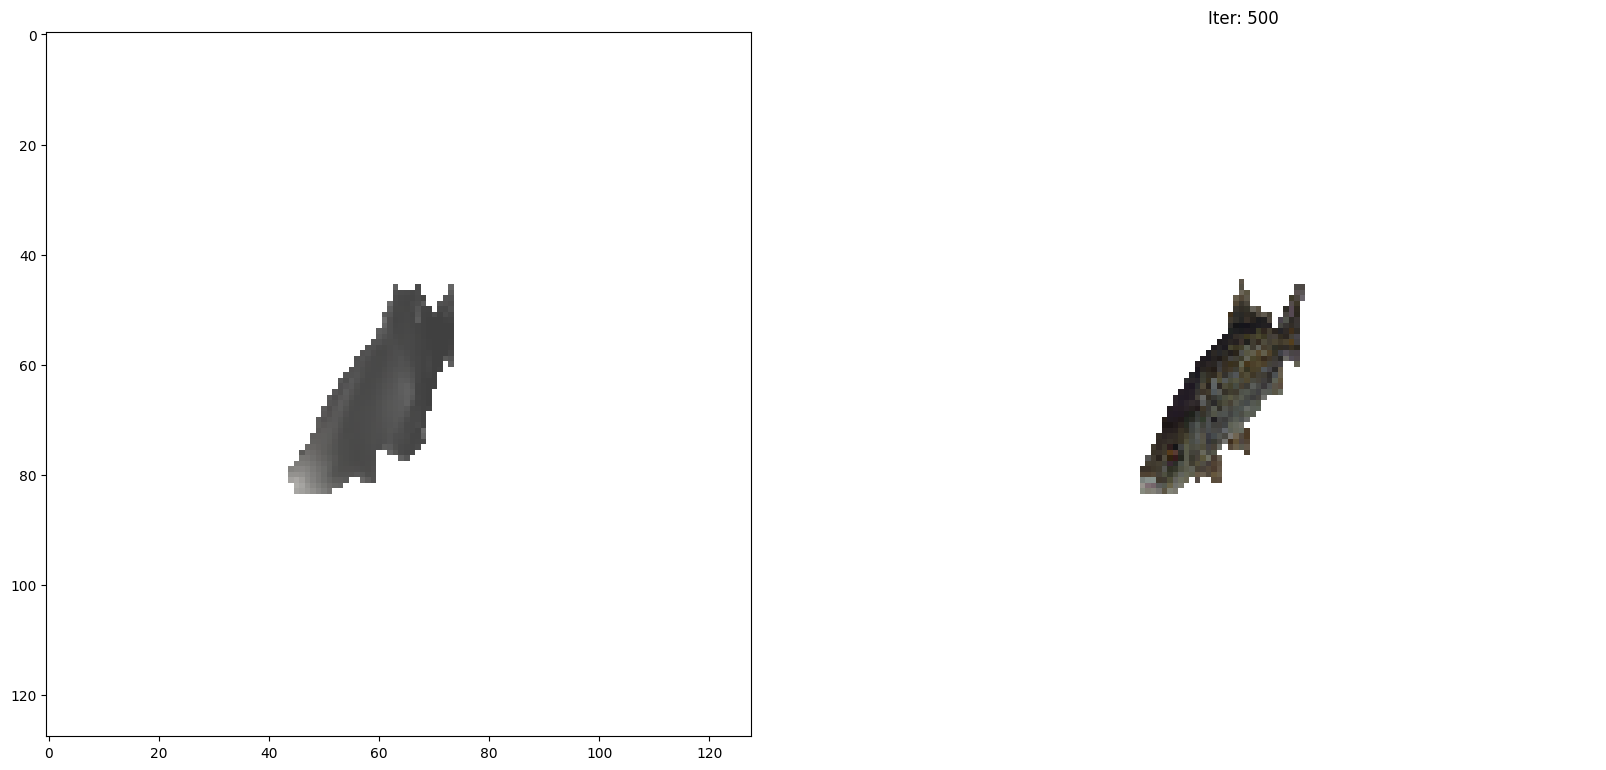

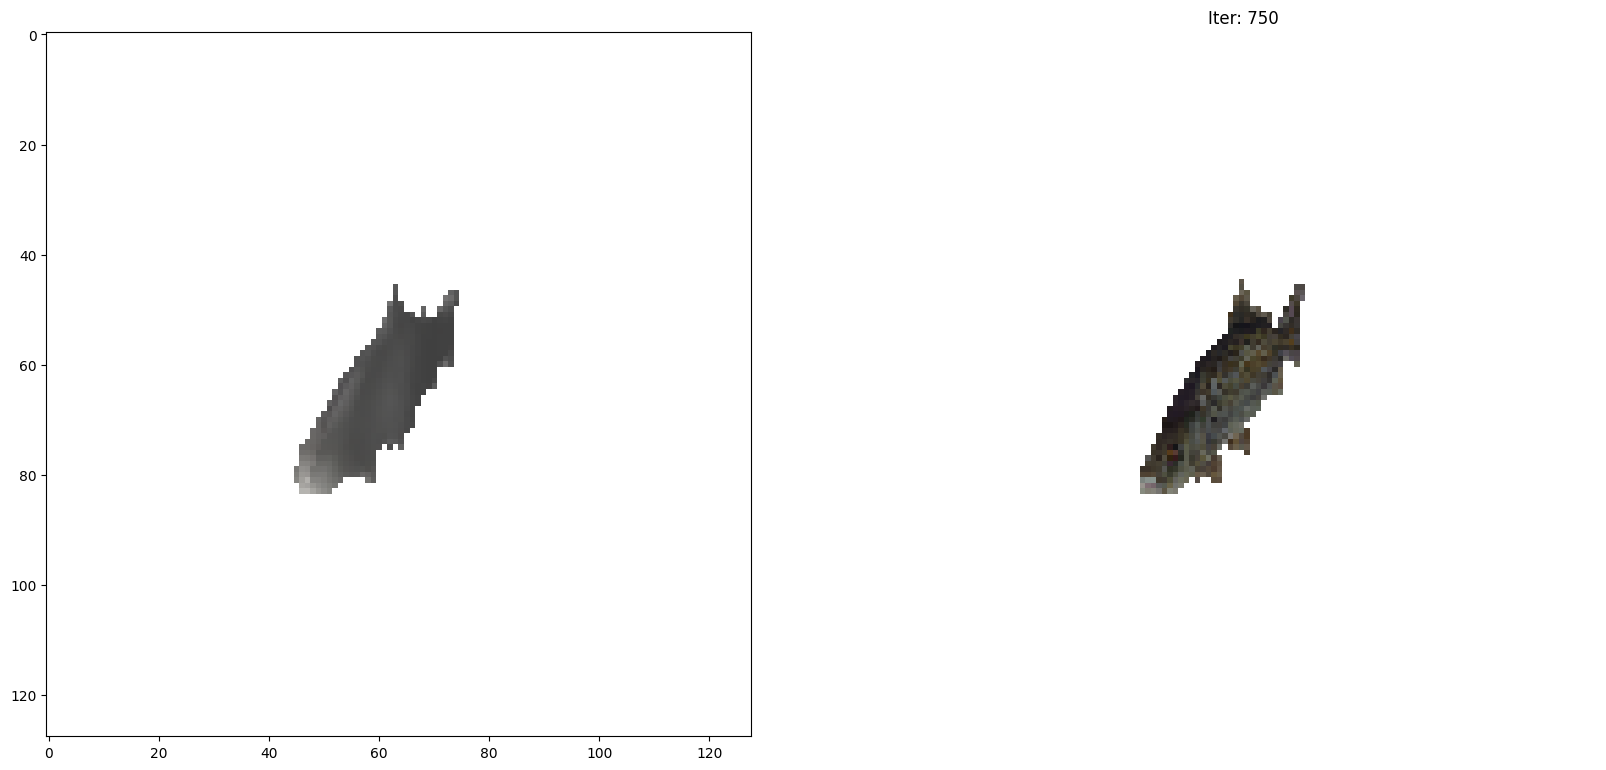

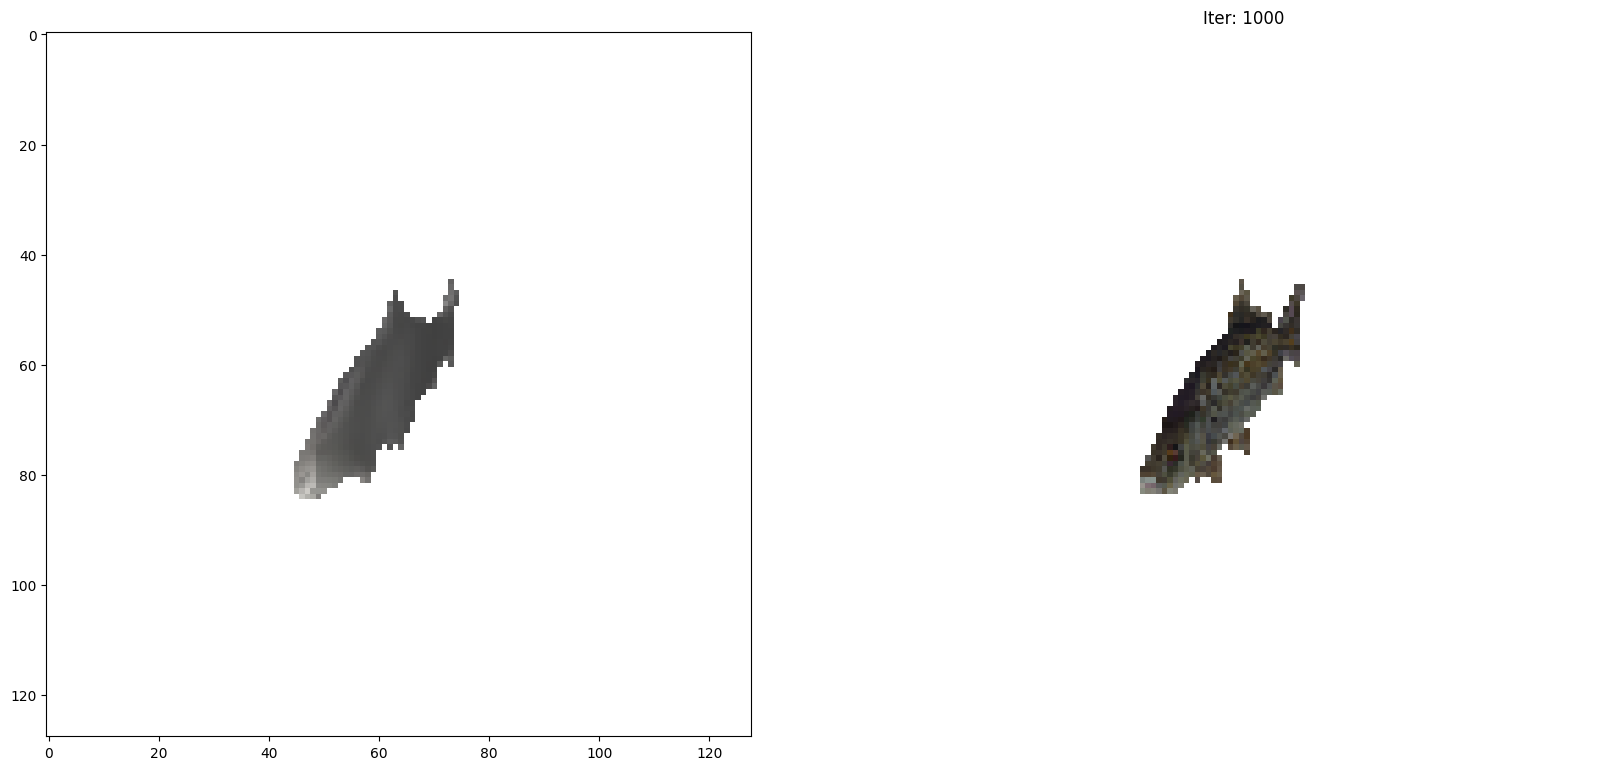

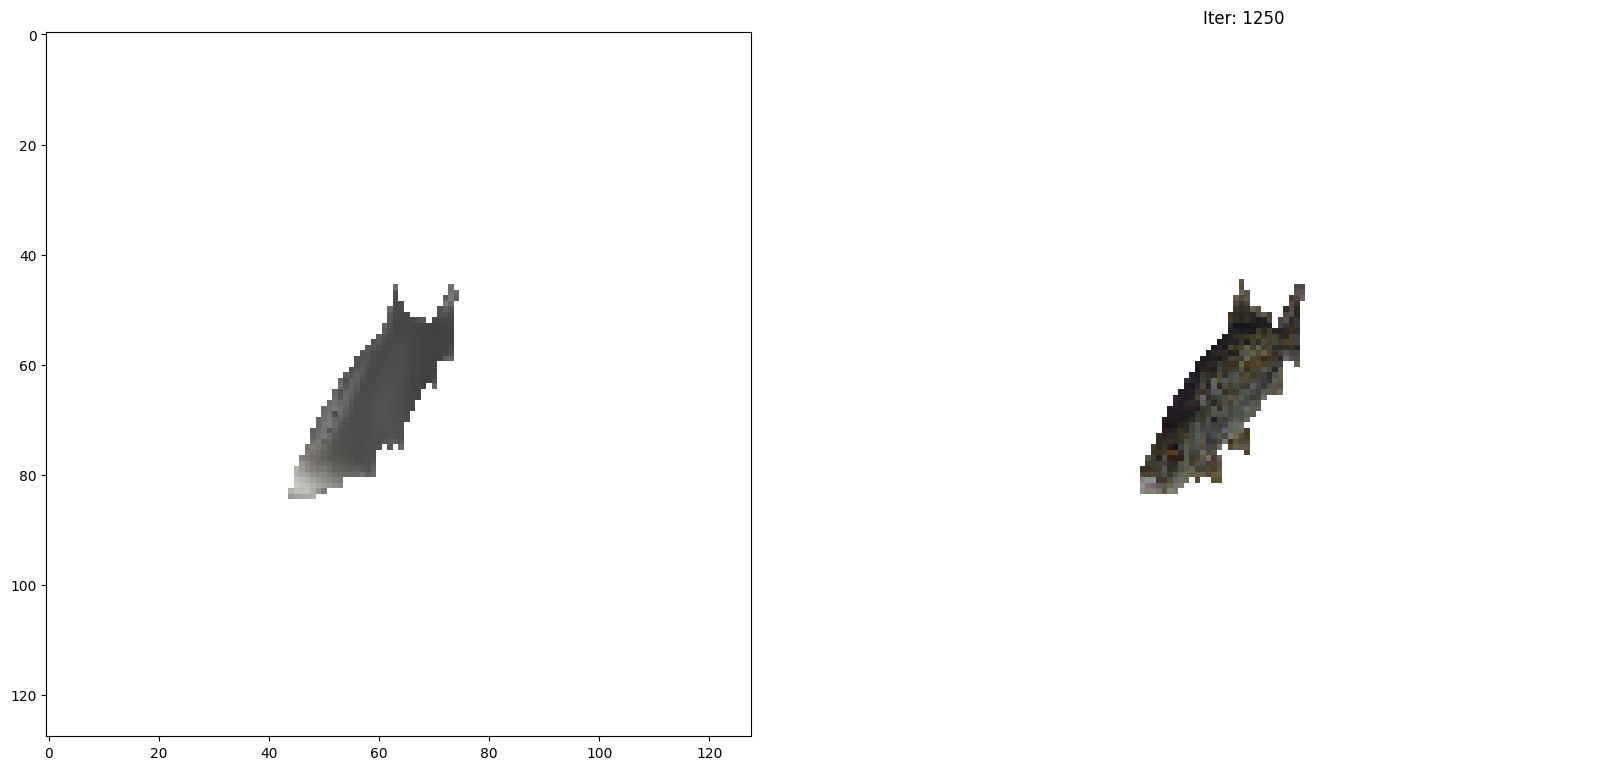

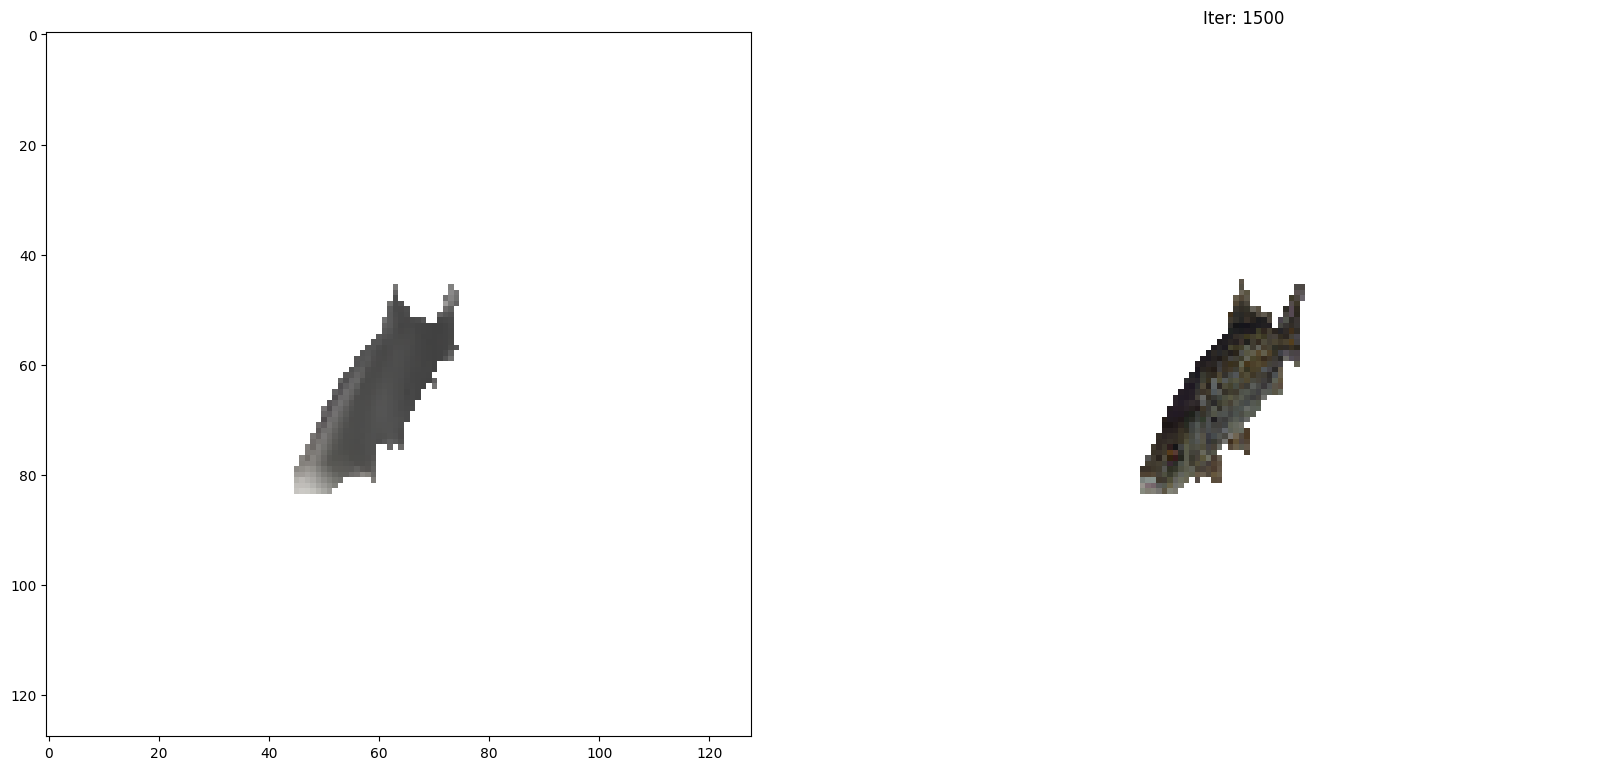

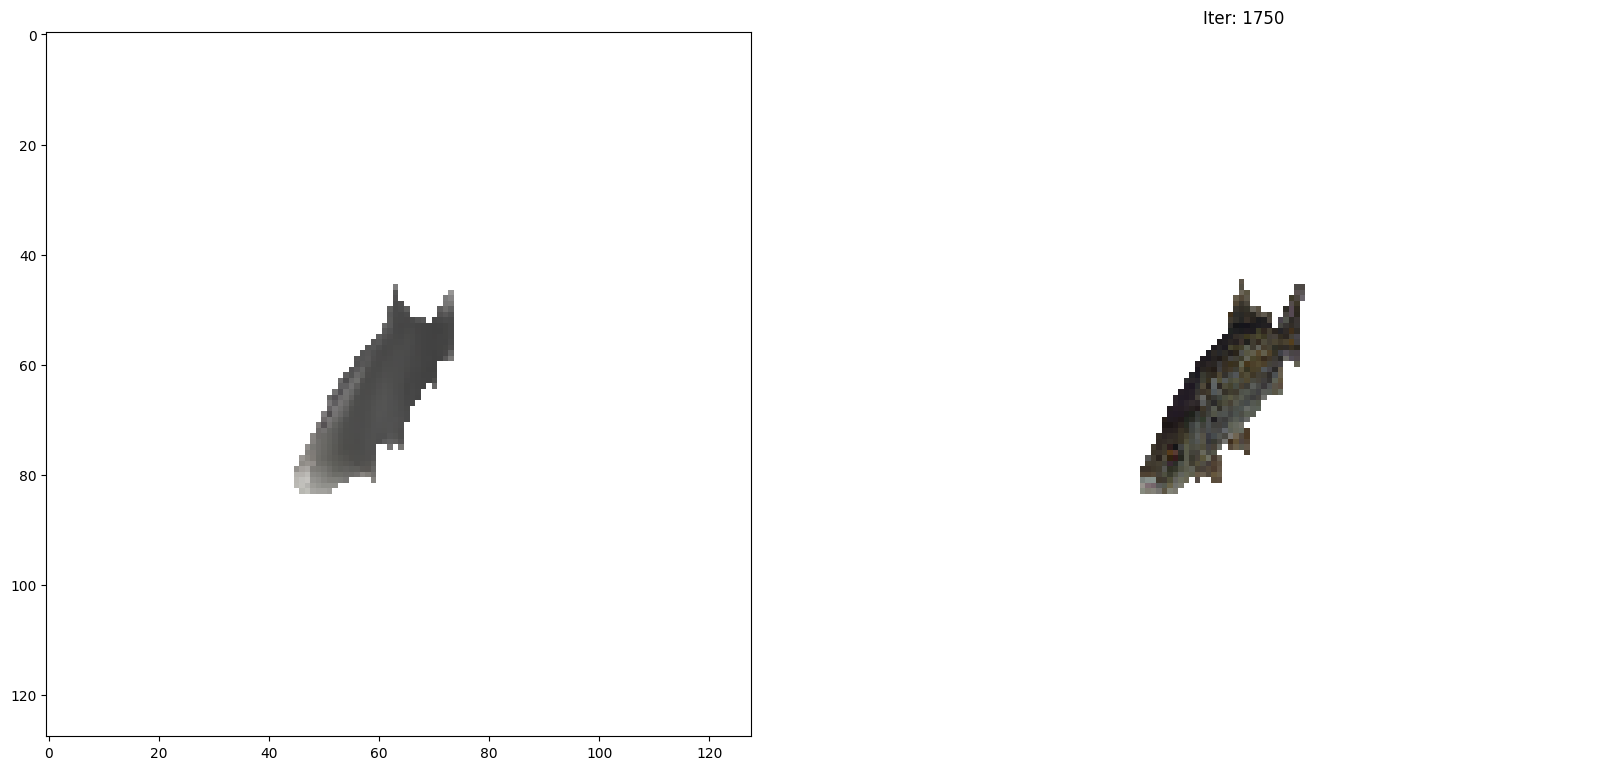

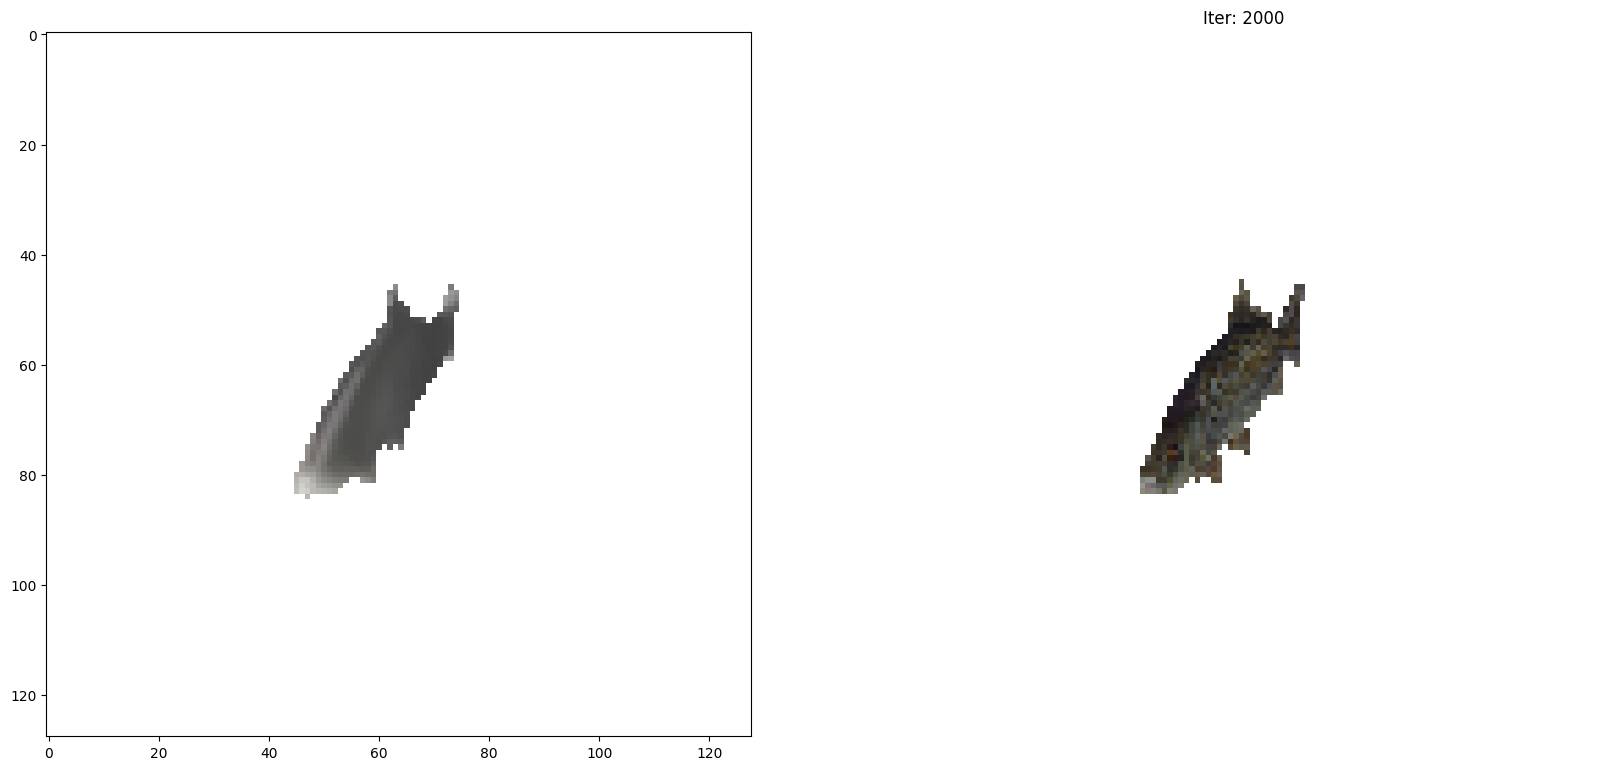

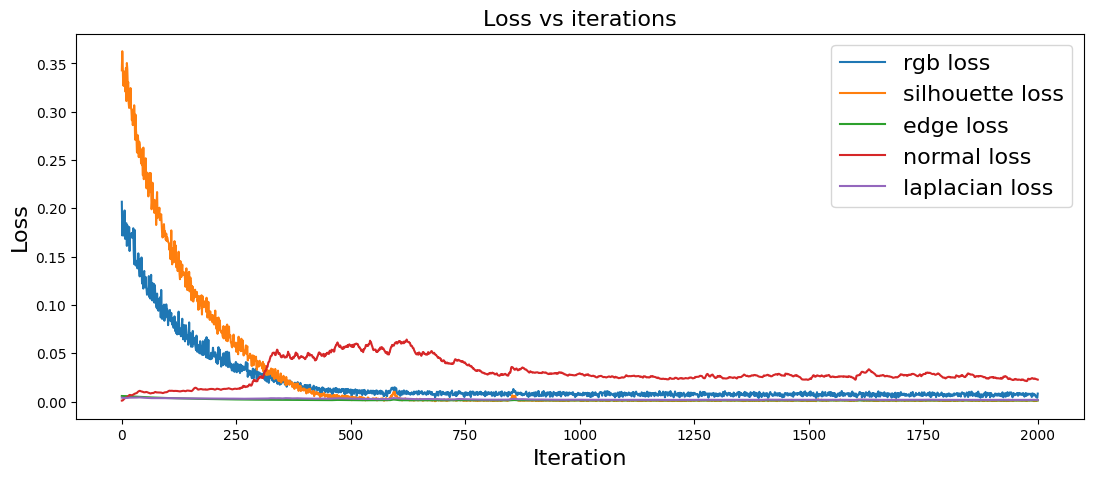

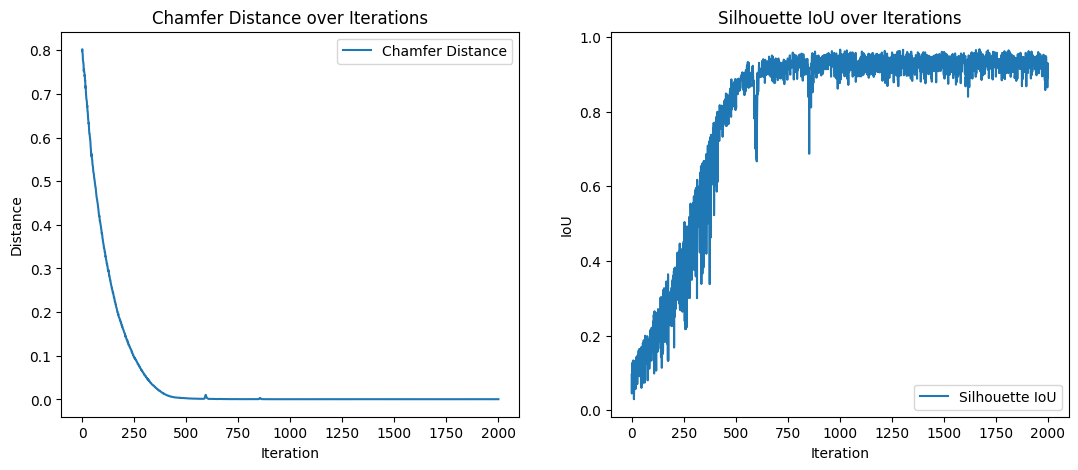

Training cycle with object 3 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

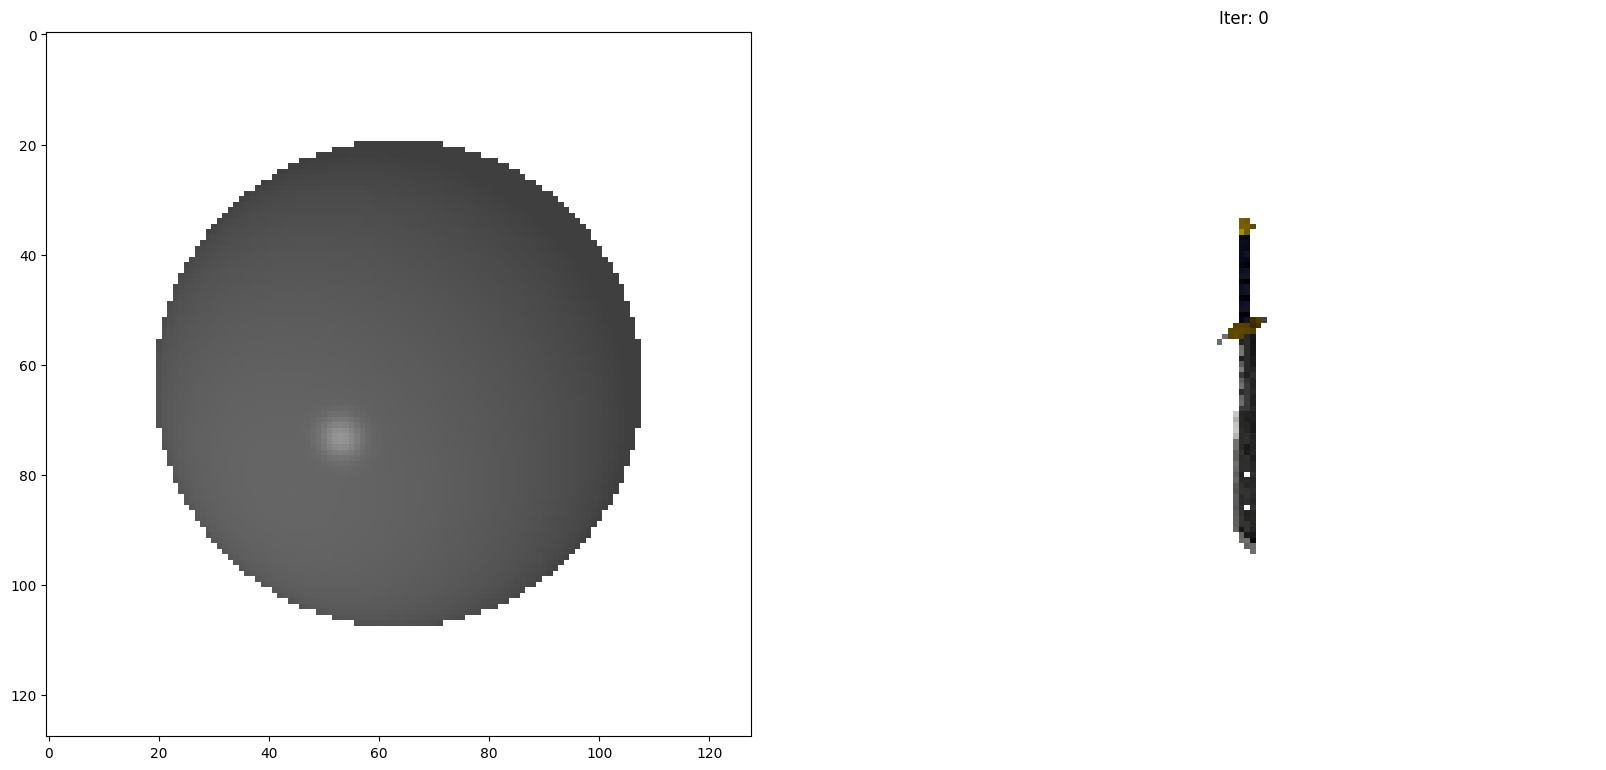

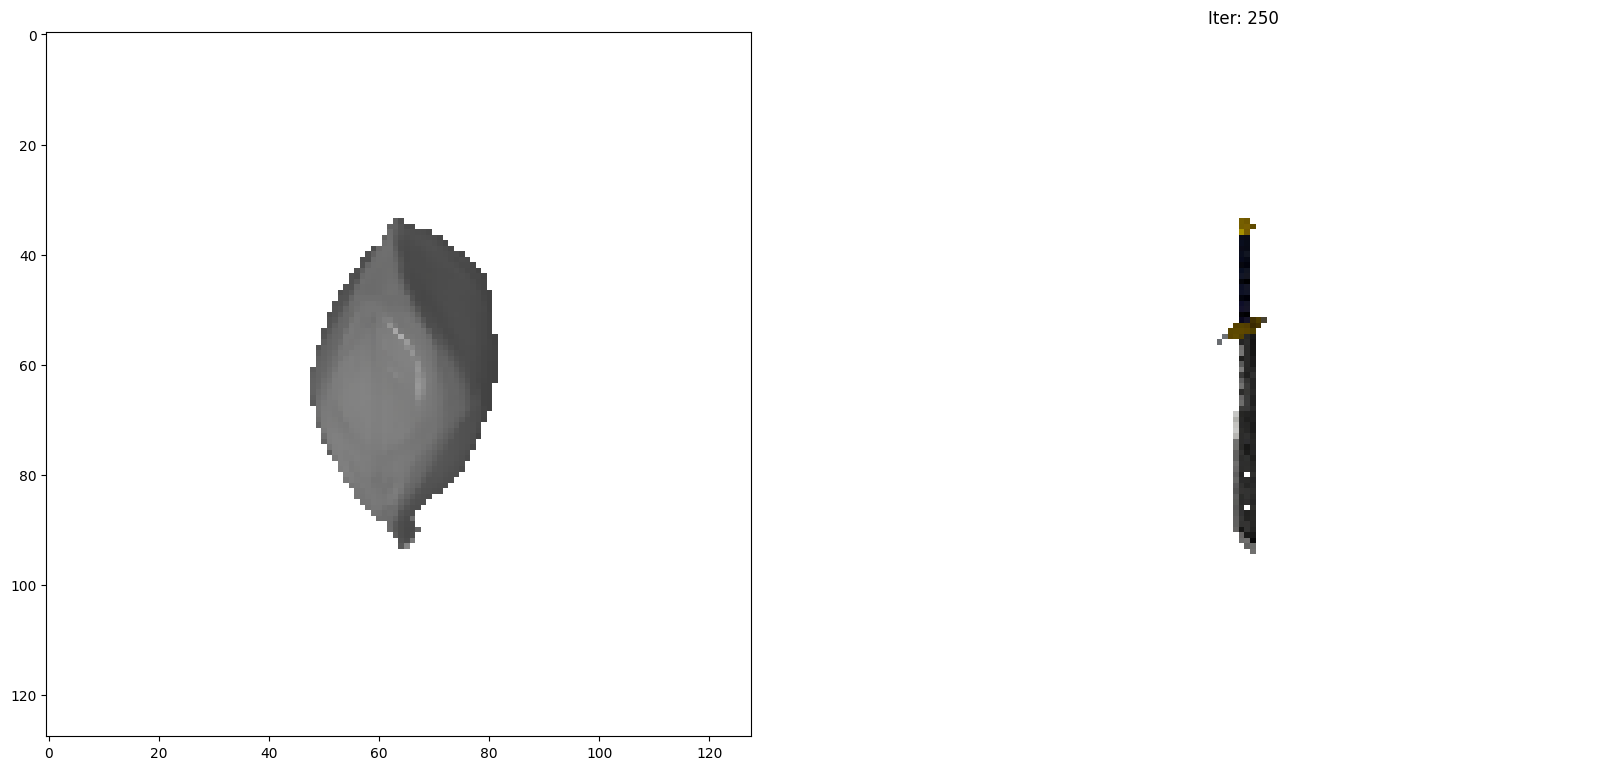

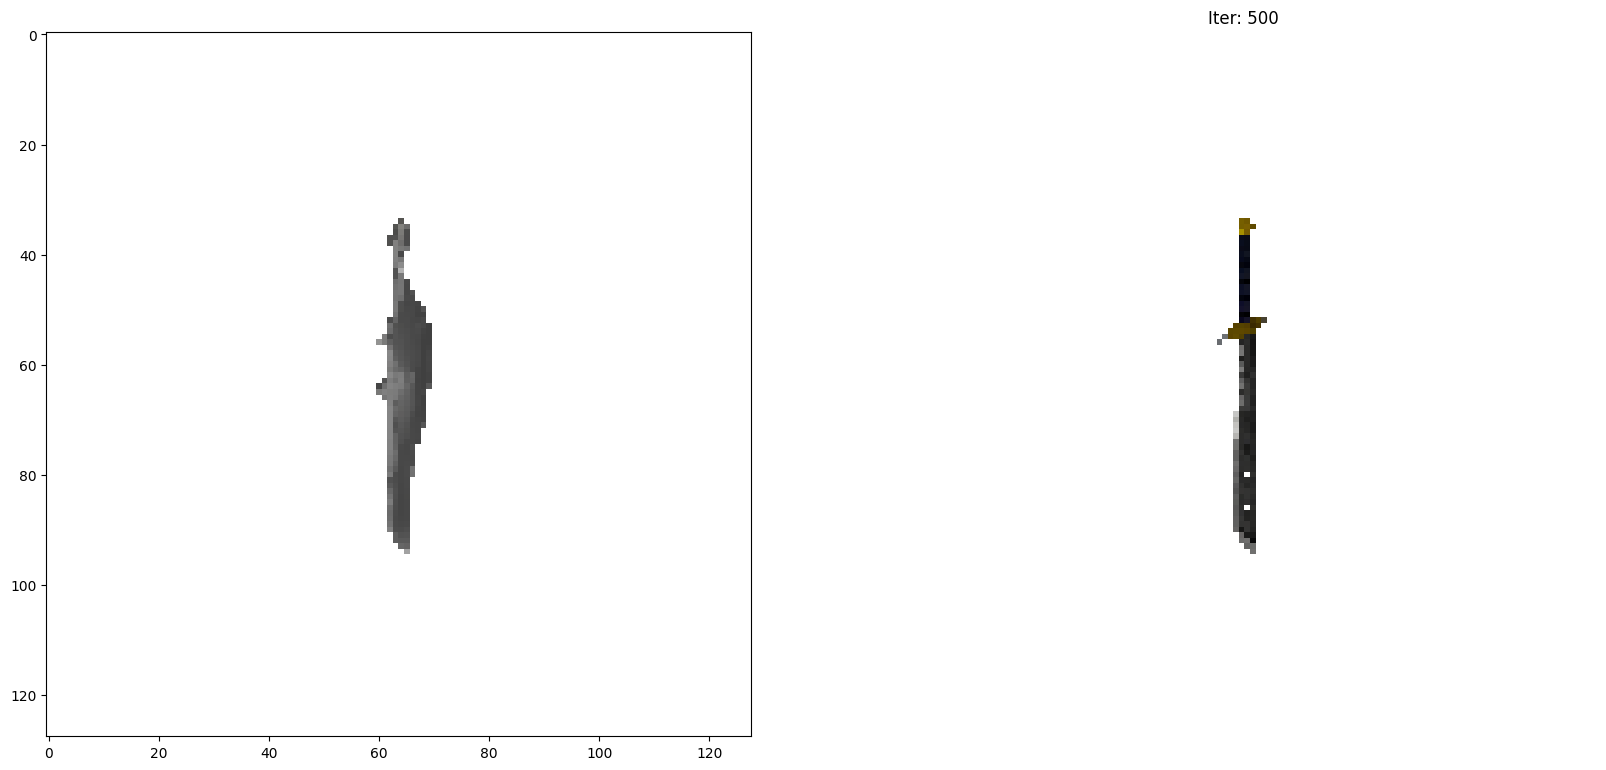

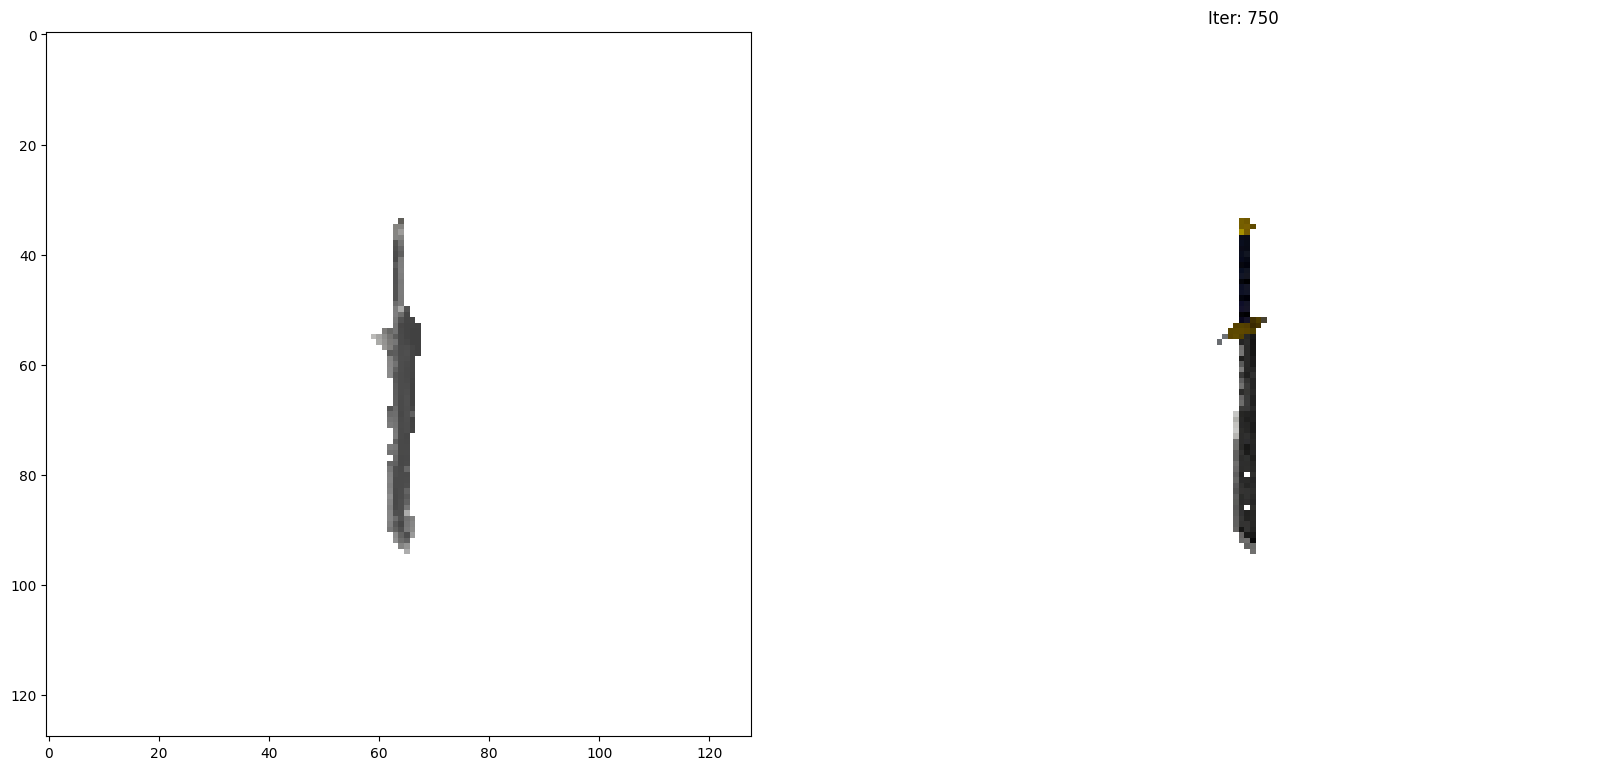

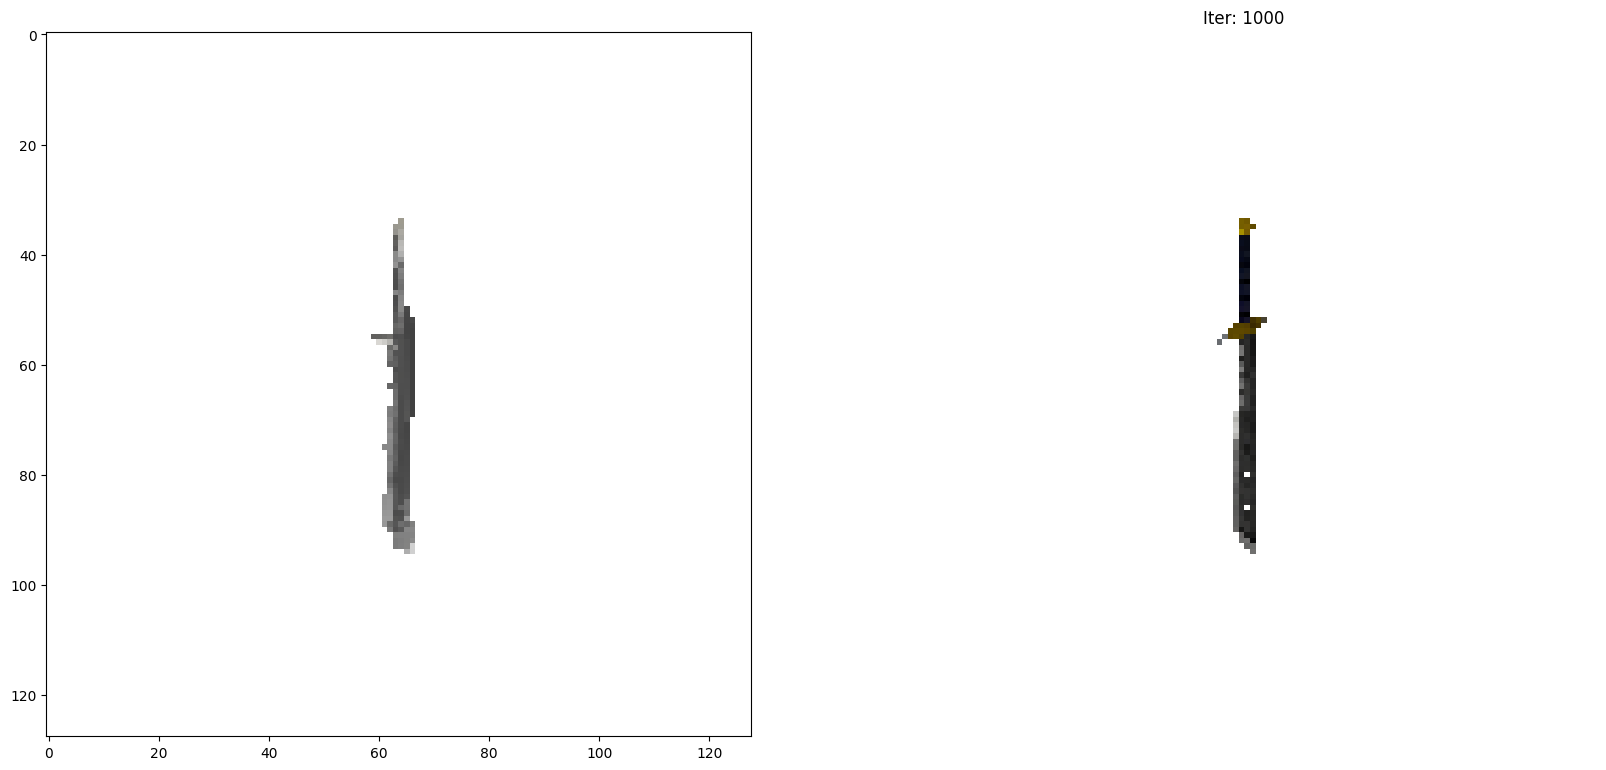

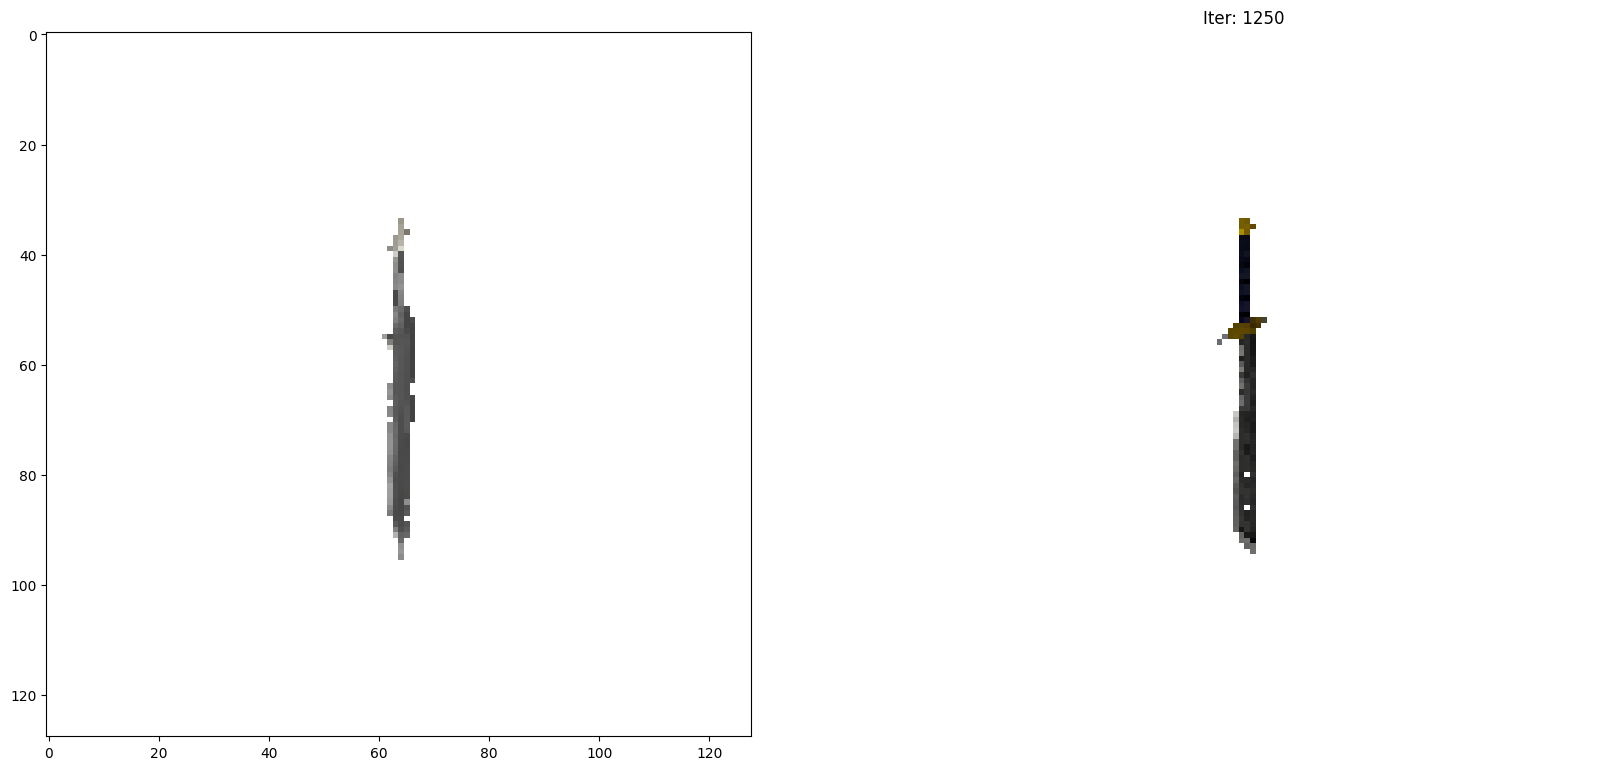

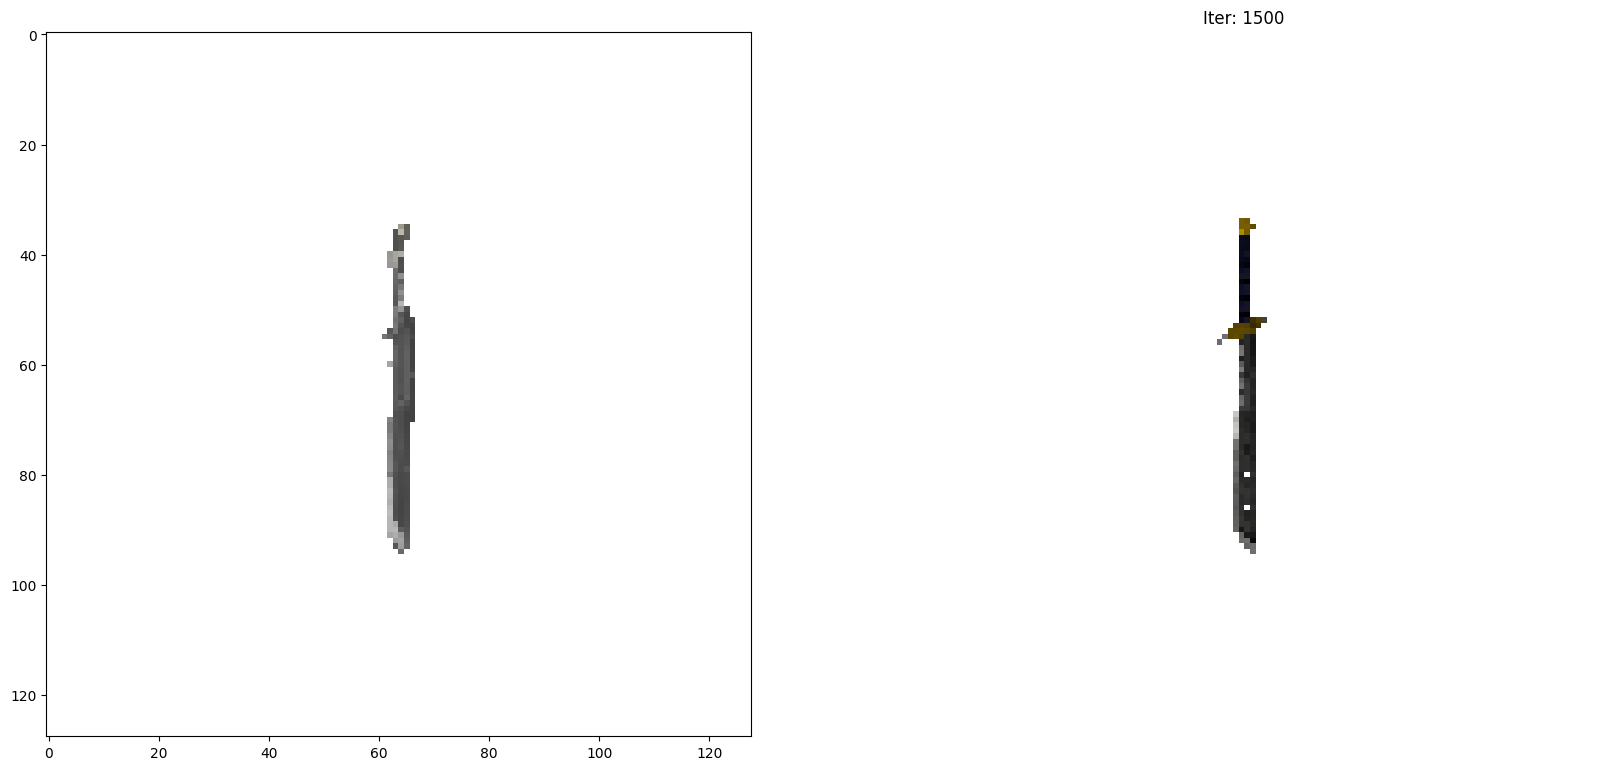

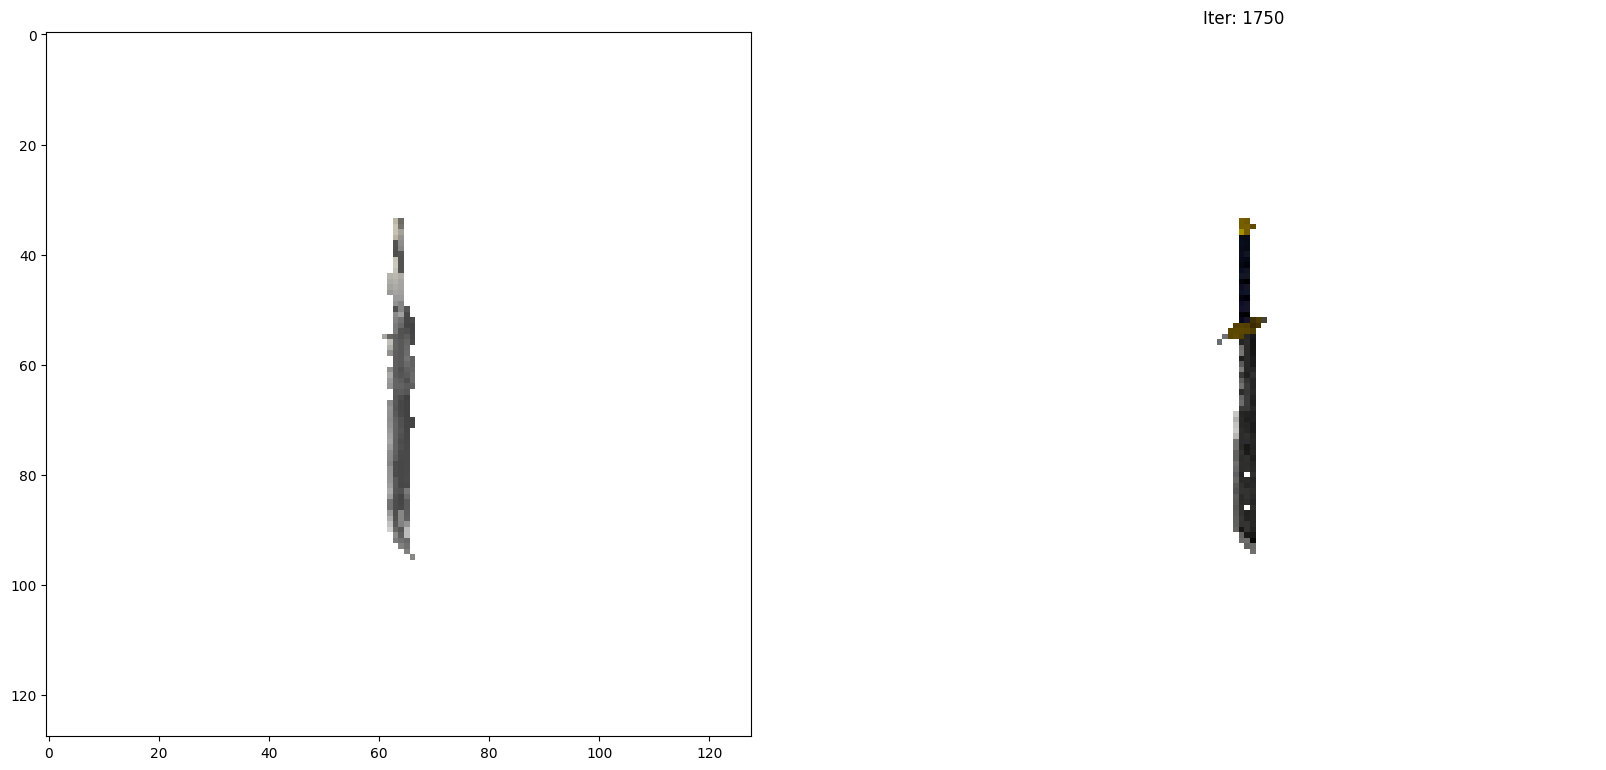

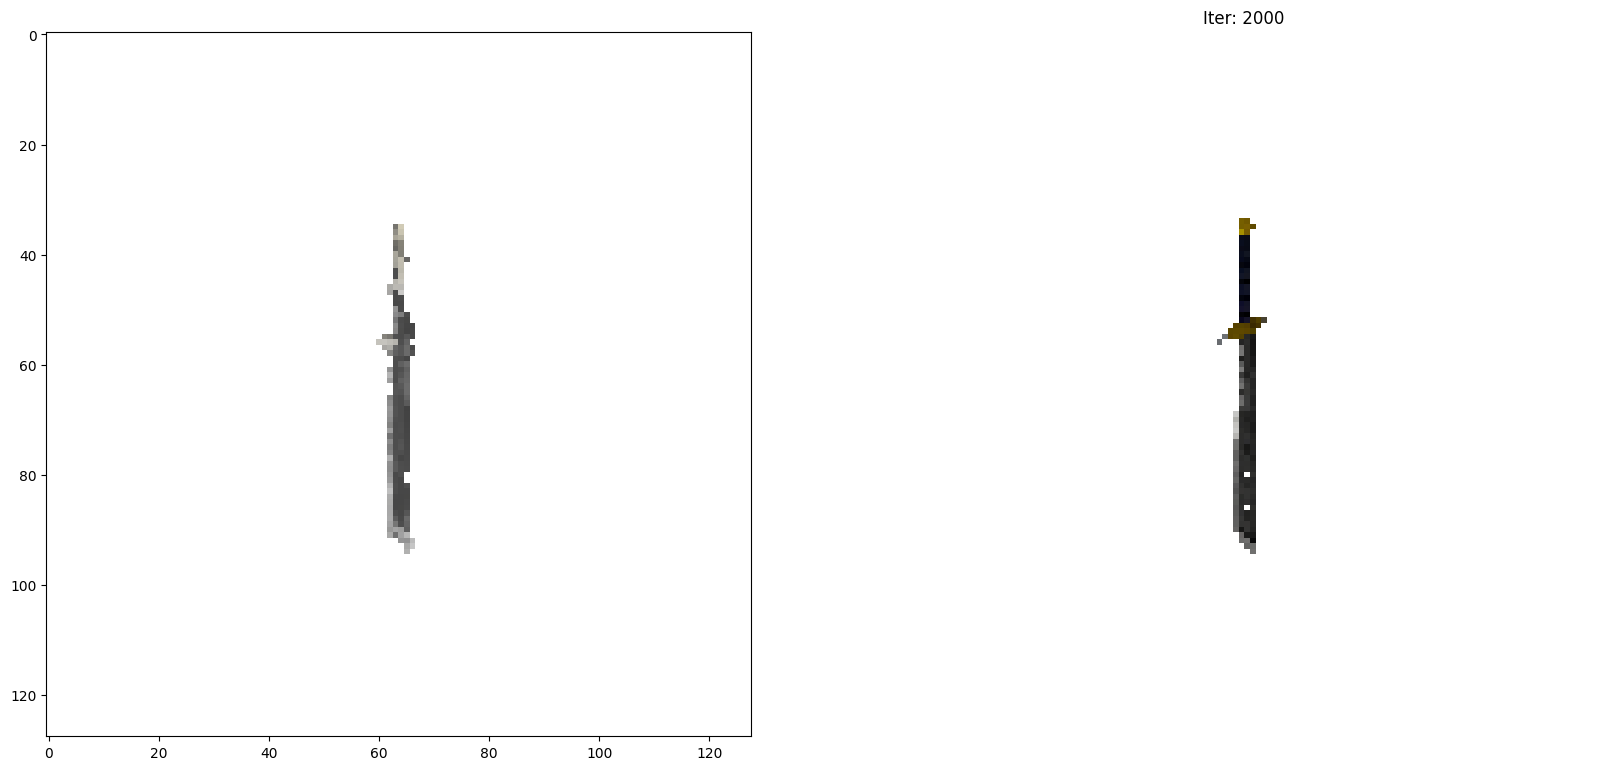

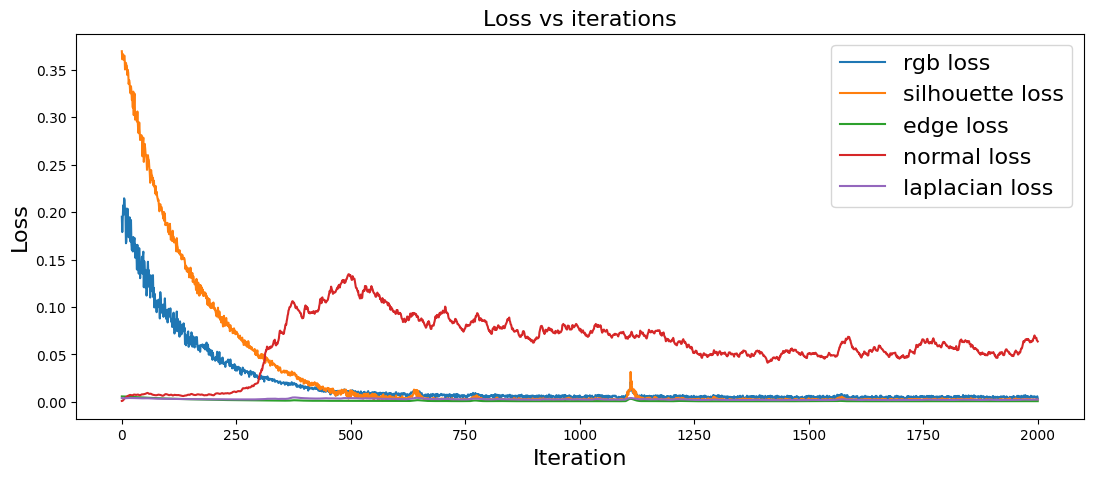

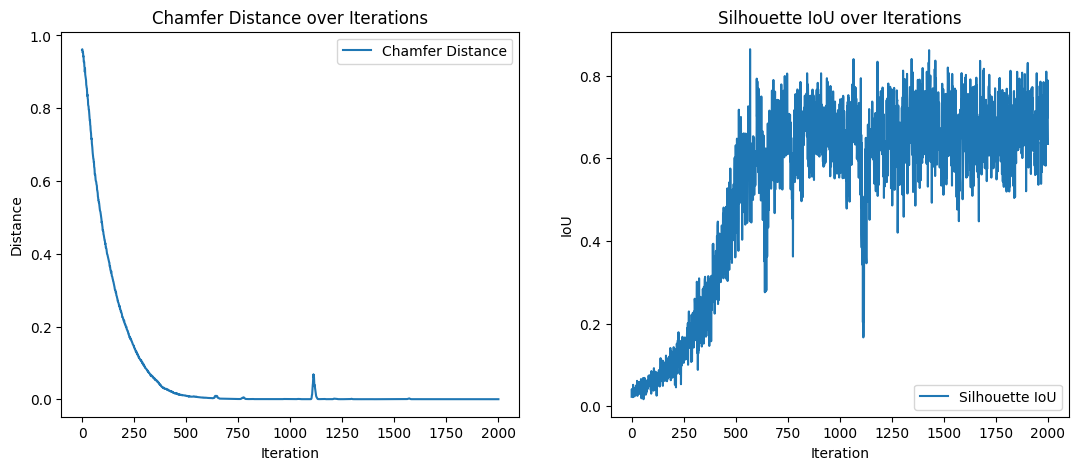

Training cycle with object 4 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

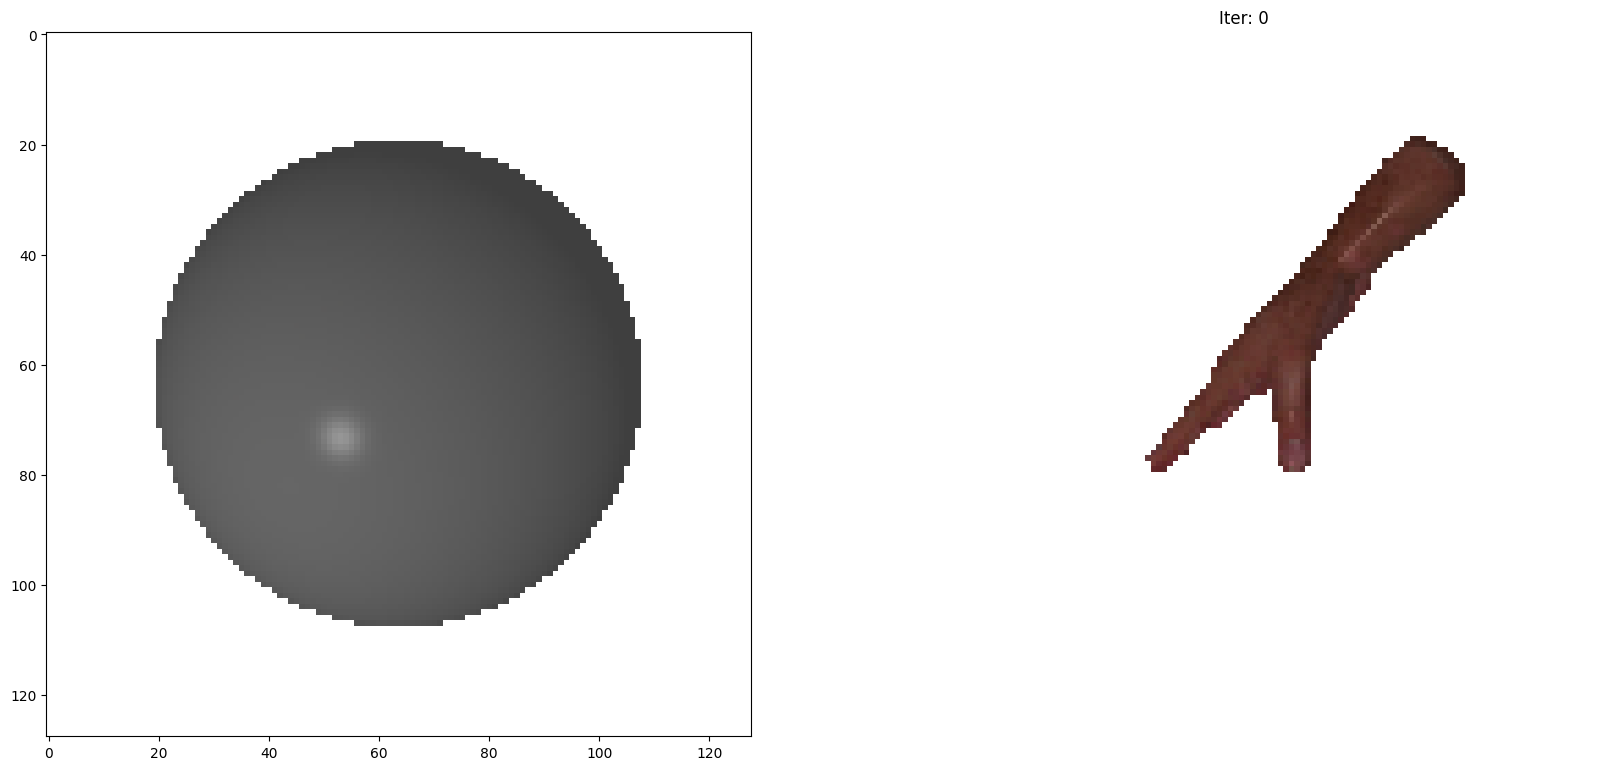

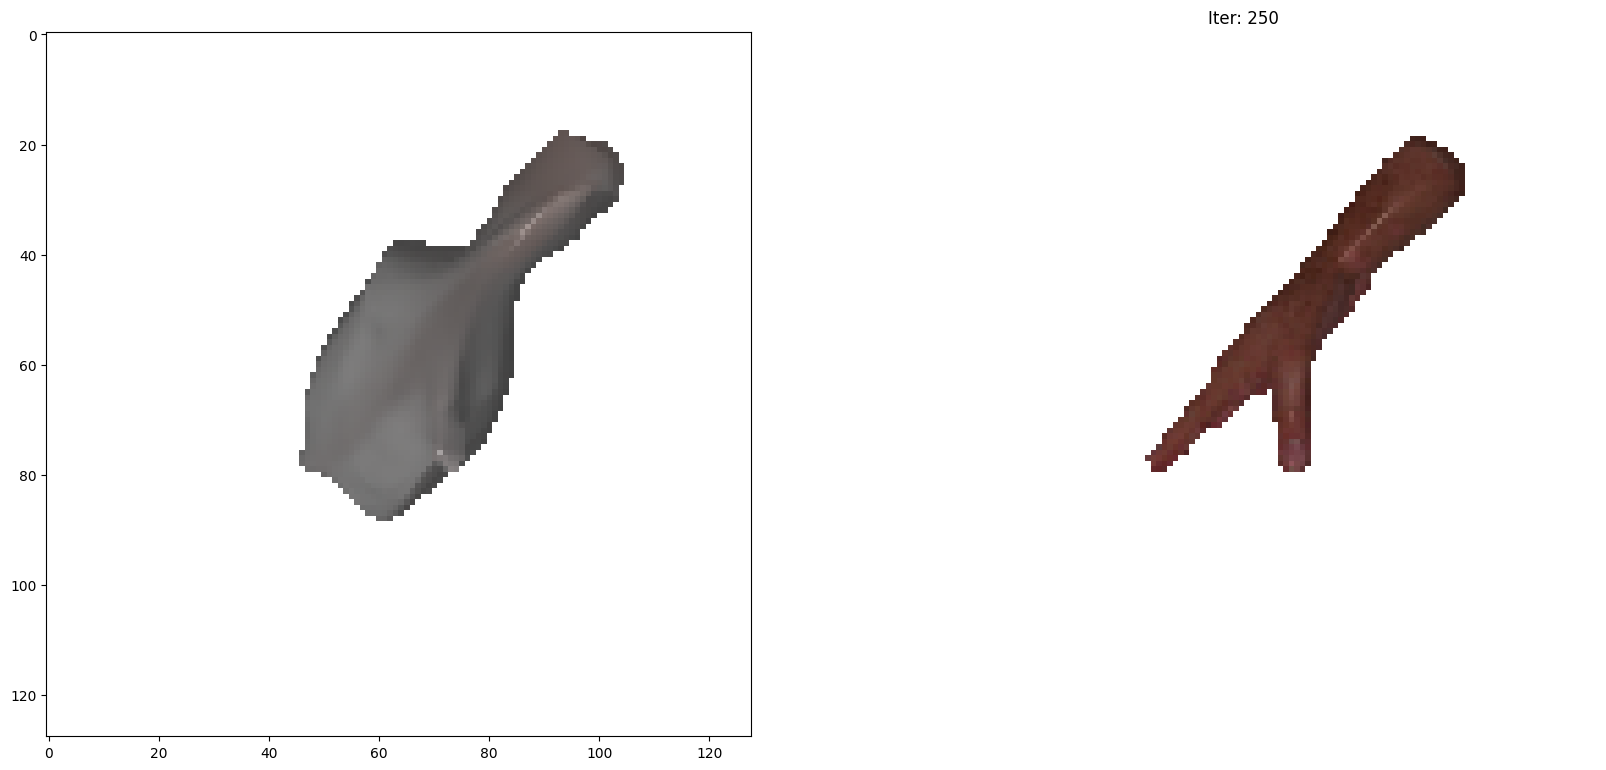

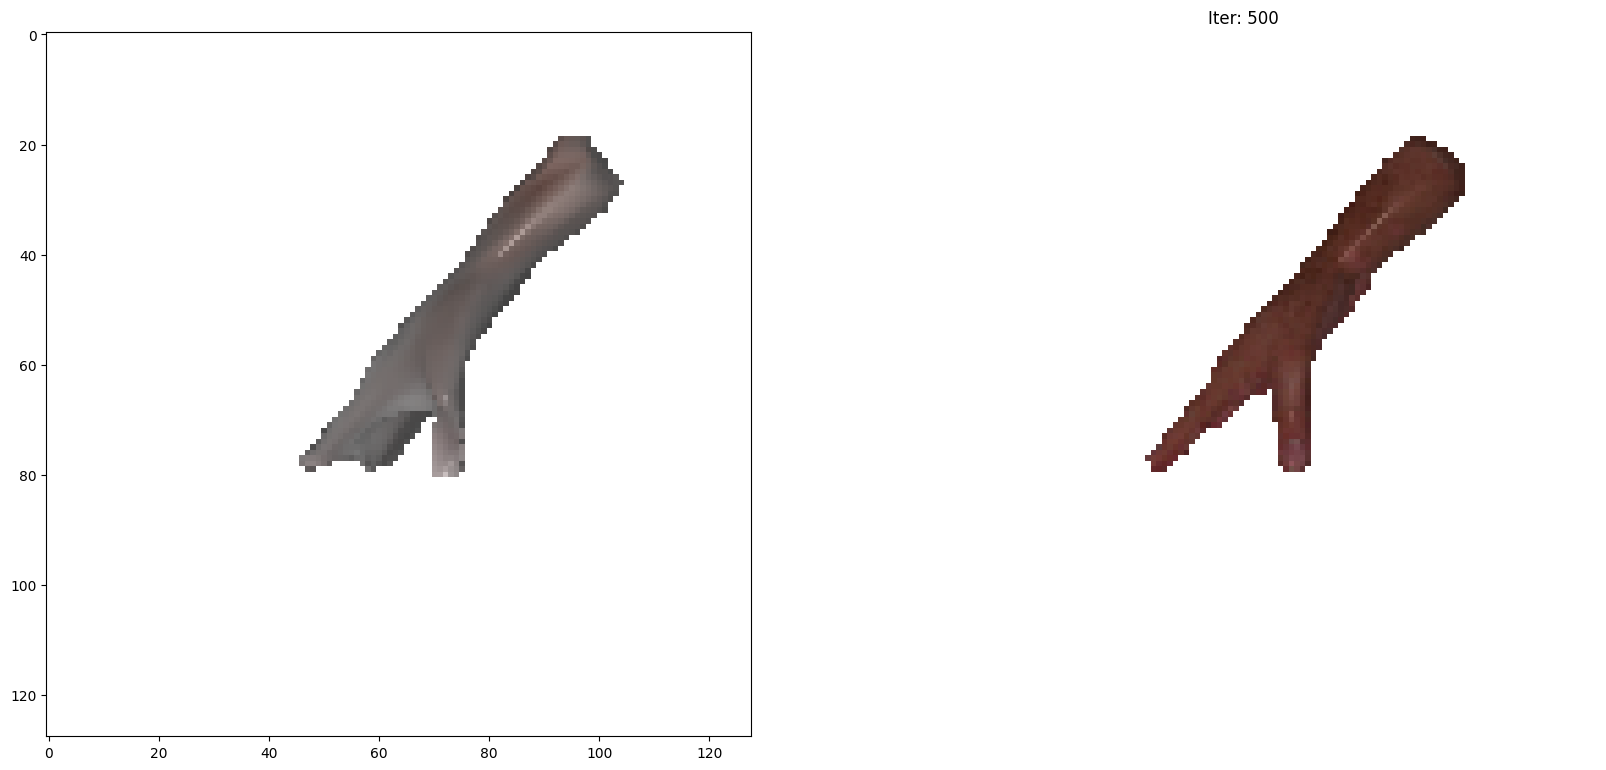

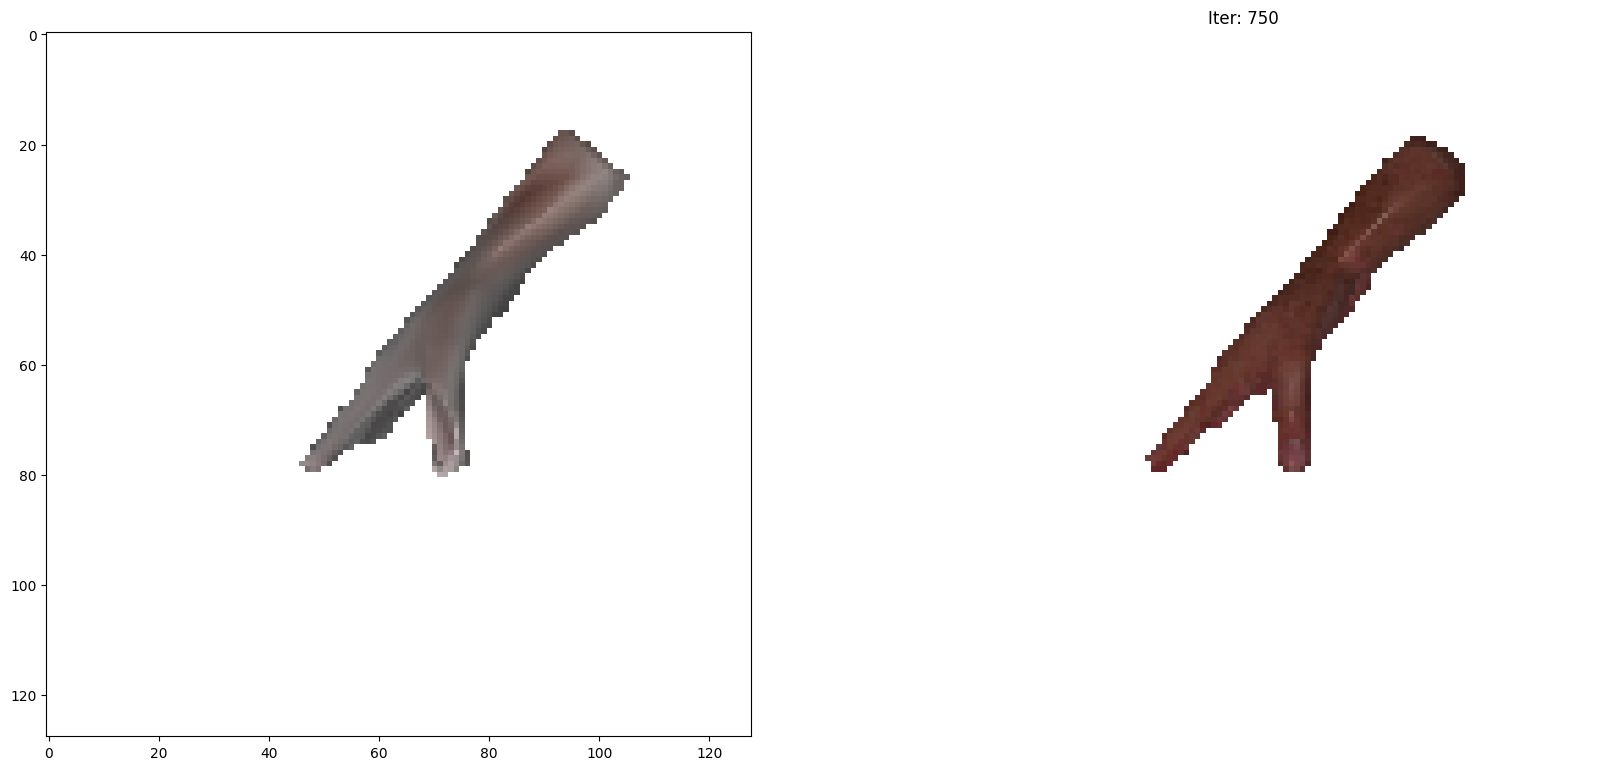

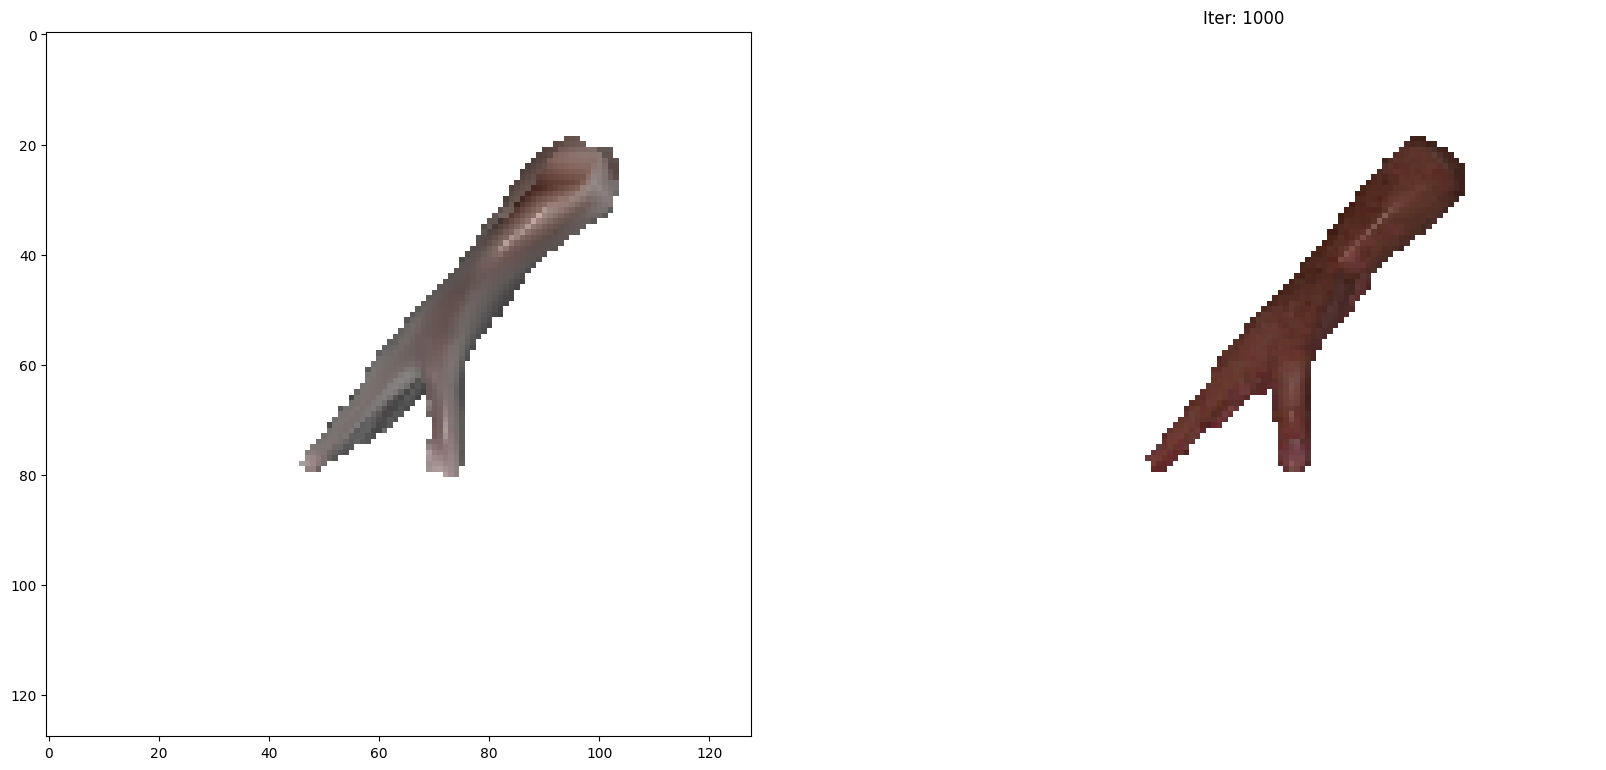

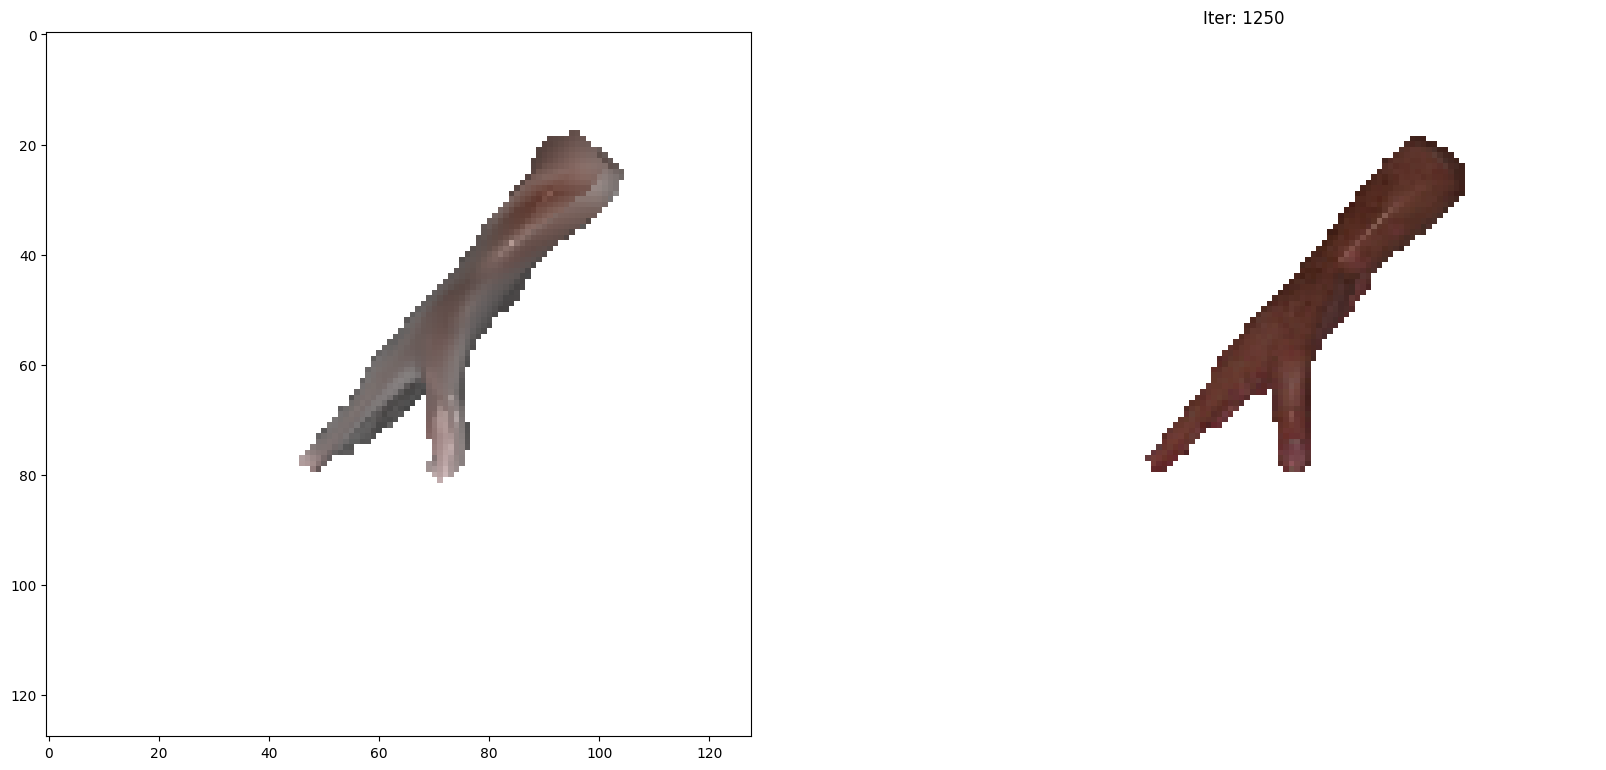

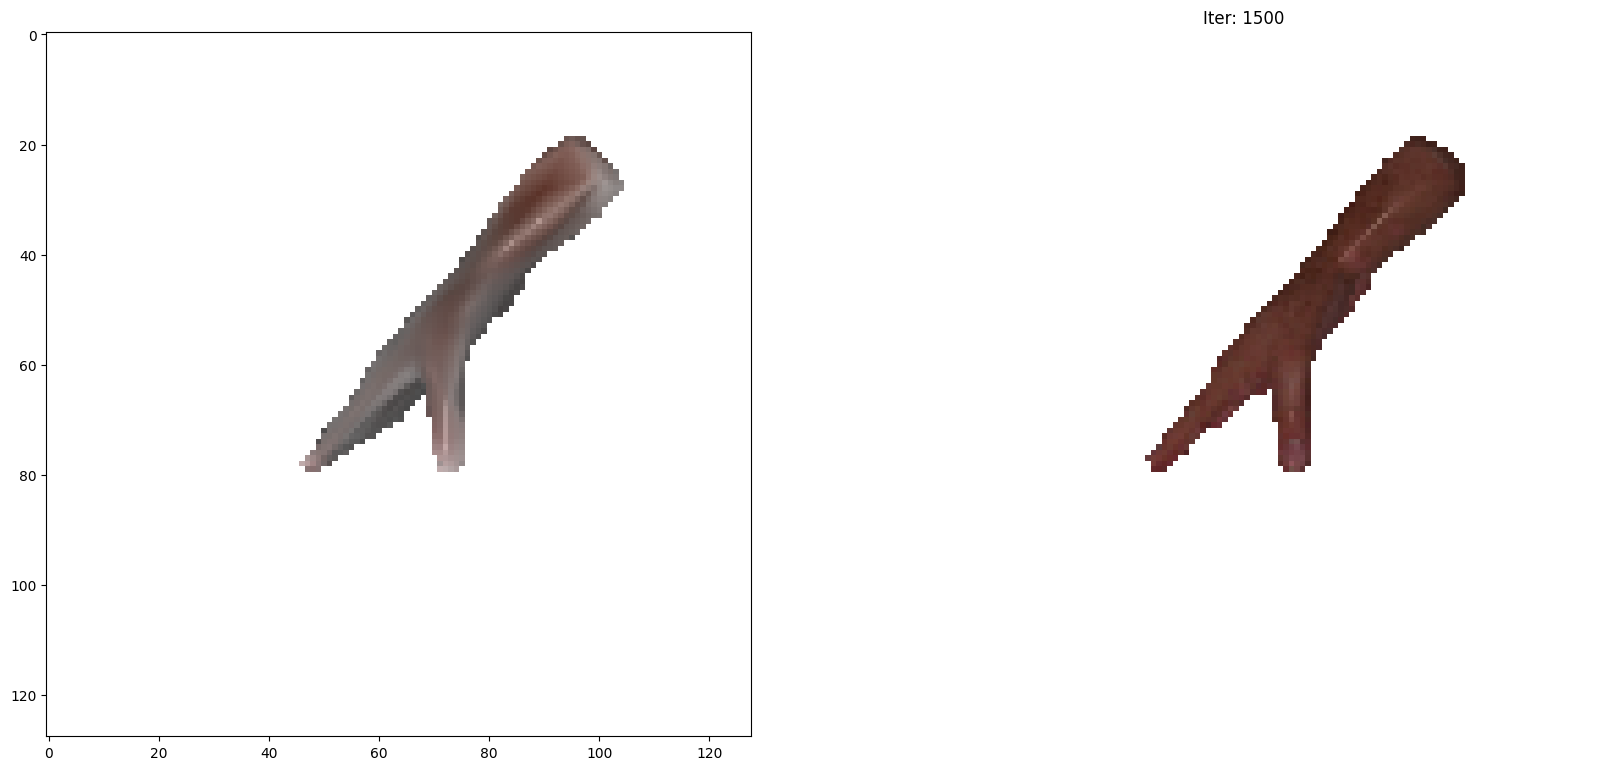

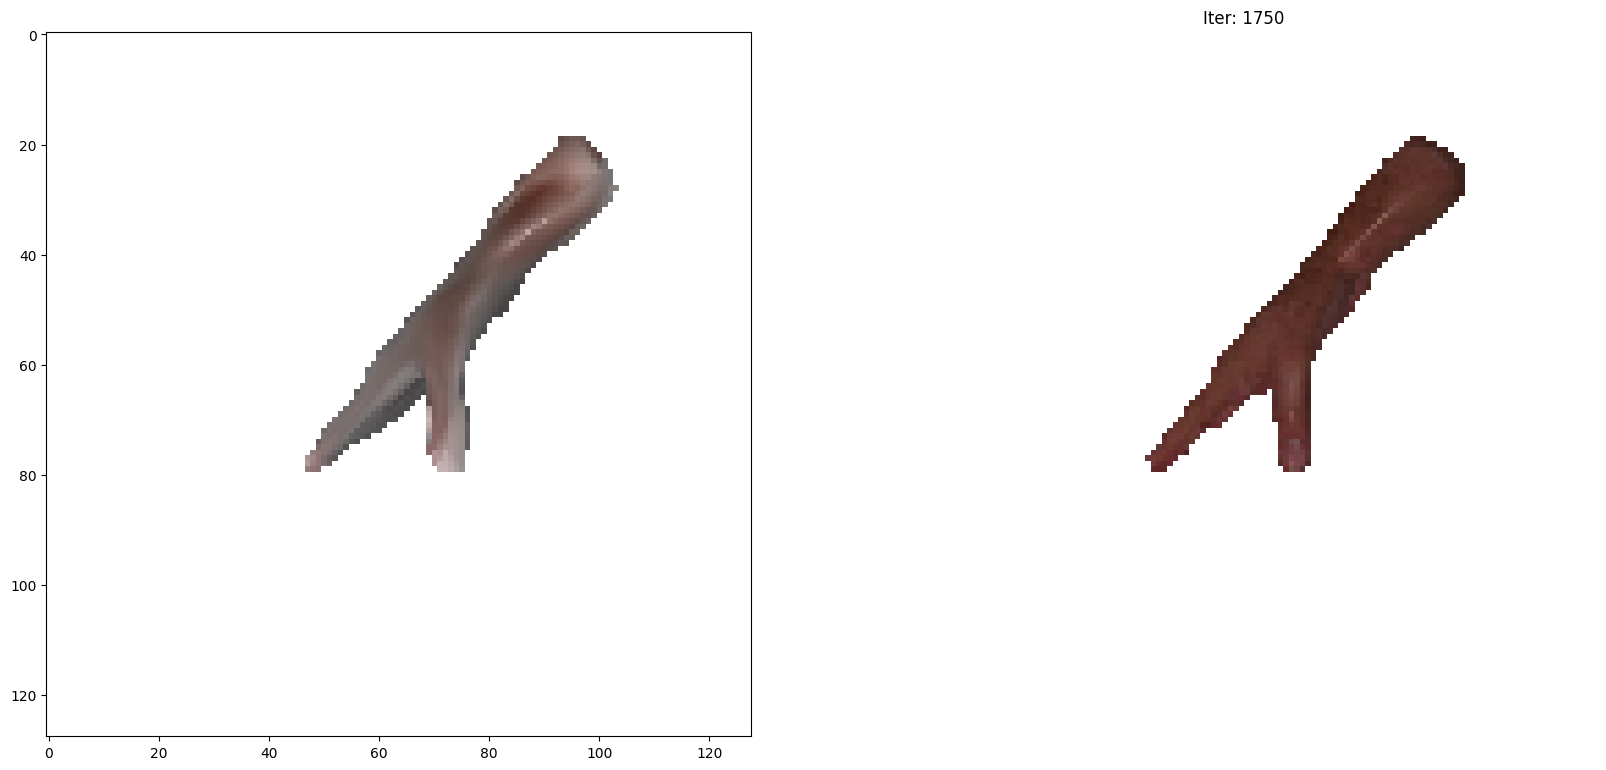

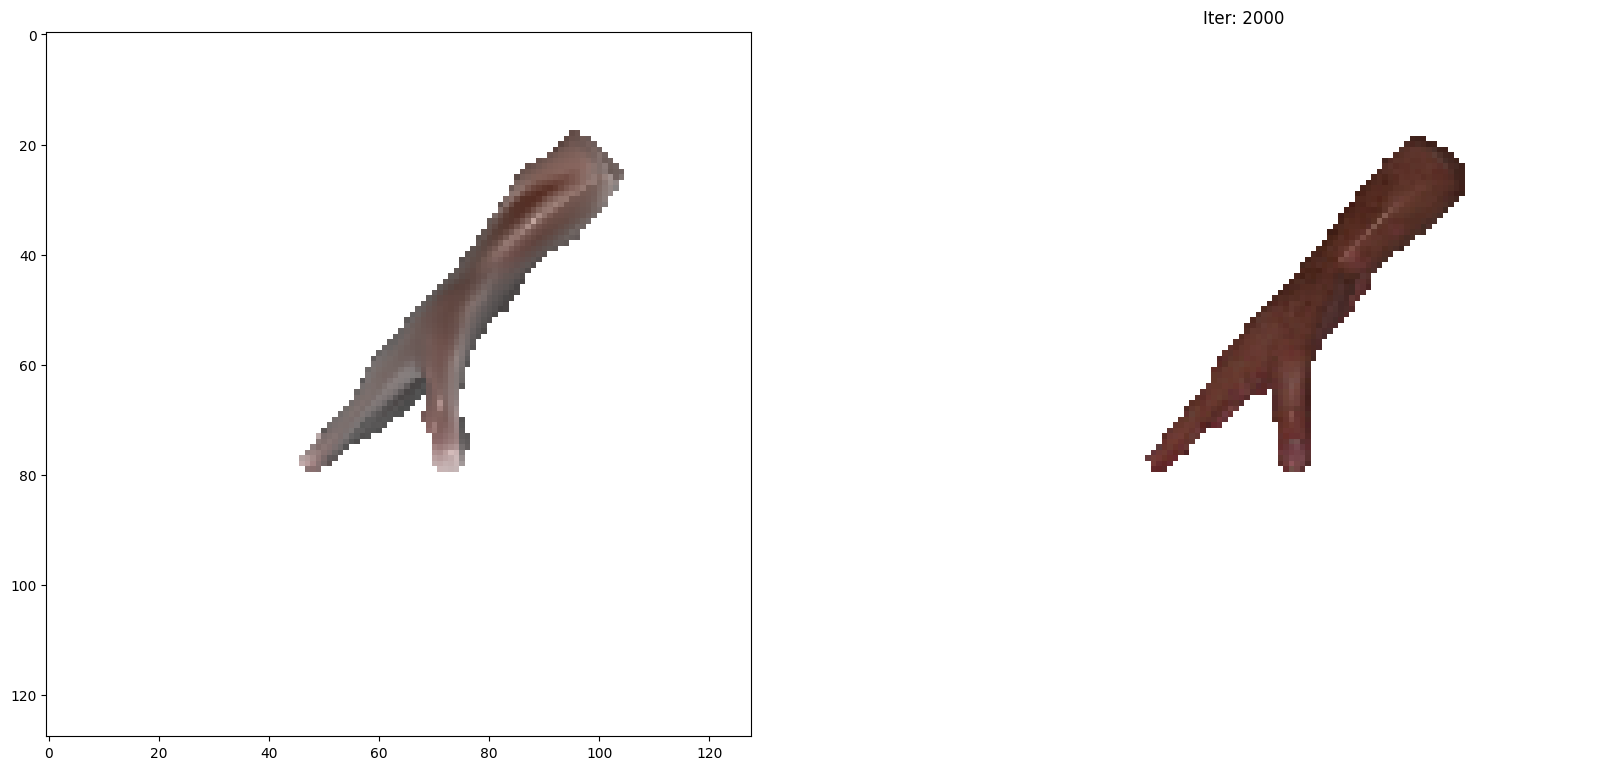

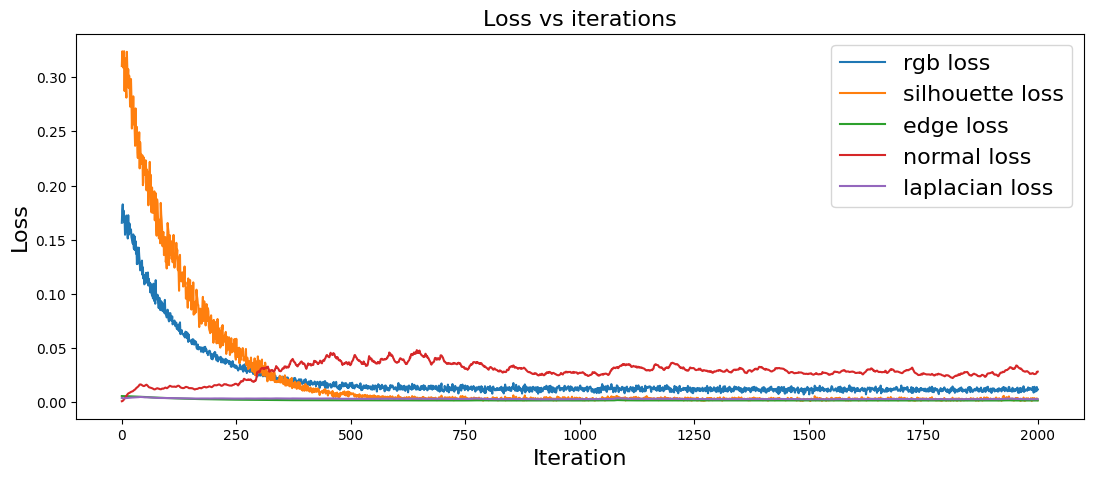

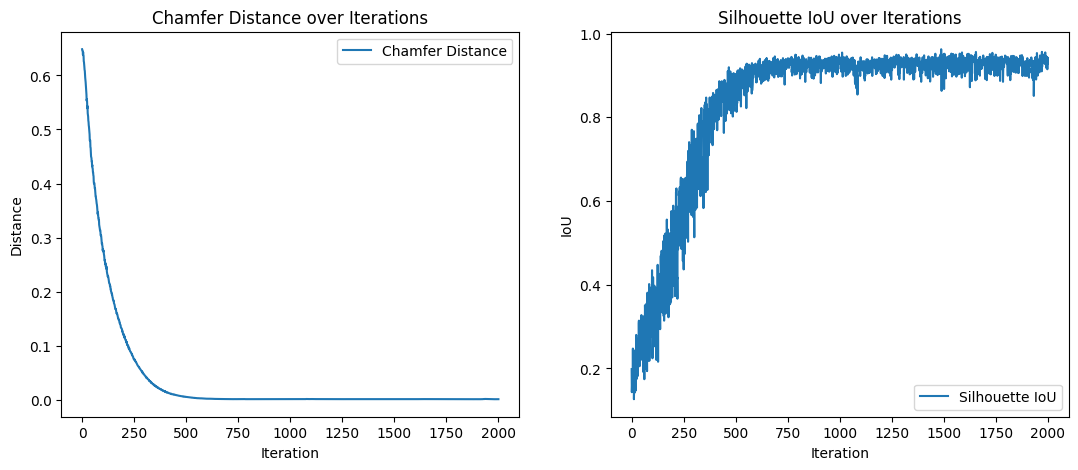

Training cycle with object 5 completed.


In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Training loop with adversarial training
Niter = 2001
plot_period = 250

# Initialize src_mesh once
src_mesh = ico_sphere(4, device)
# Initialize texture once
initial_texture = torch.full([1, src_mesh.verts_packed().shape[0], 3], 0.5, device=device, requires_grad=True)

for mesh_idx, (target_rgb, target_cameras, target_silhouette) in enumerate(zip(target_images_list, target_cameras_list, target_silhouette_list)):

    verts_shape = src_mesh.verts_packed().shape
    deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
    sphere_verts_rgb = initial_texture.clone().detach().requires_grad_(True)

    optimizer_G = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    losses = {"rgb": {"weight": 1.0, "values": []},
              "silhouette": {"weight": 1.0, "values": []},
              "edge": {"weight": 1.0, "values": []},
              "normal": {"weight": 0.01, "values": []},
              "laplacian": {"weight": 1.0, "values": []},
             }

    chamfer_distances = []
    iou_values = []

    loop = tqdm(range(Niter))

    for i in loop:
        # Discriminator part
        optimizer_D.zero_grad()
        real_images = torch.stack([target_rgb[j] for j in range(num_views_per_iteration)]).permute(0, 3, 1, 2).to(device)
        real_labels = torch.ones_like(discriminator(real_images), device=device)
        real_outputs = discriminator(real_images)
        d_loss_real = adversarial_loss(real_outputs, real_labels)

        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)
        new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)
        fake_images = renderer_textured(new_src_mesh, cameras=camera, lights=lights)[..., :3]
        fake_images = fake_images.permute(0, 3, 1, 2)
        fake_labels = torch.zeros_like(discriminator(fake_images), device=device)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = adversarial_loss(fake_outputs, fake_labels)

        d_loss = d_loss_real + math.log10(d_loss_fake)
        d_loss_print = d_loss
        d_loss.backward()
        optimizer_D.step()

        # Generator part
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        real_labels = torch.ones_like(discriminator(fake_images), device=device)
        g_loss_adversarial = adversarial_loss(fake_outputs, real_labels)

        # Losses to smooth /regularize the mesh shape
        loss = {k: torch.tensor(0.0, device=device) for k in losses}
        update_mesh_shape_prior_losses(new_src_mesh, loss)

        chamfer_losses = []
        iou_losses = []

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
            images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted silhouette and the target
            # silhouette from the dataset
            predicted_silhouette = images_predicted[..., 3]
            loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            loss["silhouette"] += loss_silhouette / num_views_per_iteration

            # Squared L2 distance between the predicted RGB image and the target
            # image from the dataset
            loss_rgb = ((images_predicted[..., :3] - target_rgb[j]) ** 2).mean()
            loss["rgb"] += loss_rgb / num_views_per_iteration

            # Sample 5k points from the surface of each mesh
            sample_trg = sample_points_from_meshes(meshes[mesh_idx], 5000)
            sample_src = sample_points_from_meshes(new_src_mesh, 5000)
            # Compute Chamfer Distance
            chamfer_loss, _ = chamfer_distance(sample_trg, sample_src)
            chamfer_losses.append(chamfer_loss.item())

            # Compute Silhouette IoU
            iou_loss = compute_silhouette_iou(predicted_silhouette > 0.5, target_silhouette[j] > 0.5)
            iou_losses.append(iou_loss)

        # Weighted sum of the losses
        sum_loss = g_loss_adversarial * 0.1
        for k, l in loss.items():
            sum_loss += l * losses[k]["weight"]
            losses[k]["values"].append(float(l.detach().cpu()))

        # Store the Chamfer Distance and IoU values
        chamfer_distances.append(sum(chamfer_losses) / len(chamfer_losses))
        iou_values.append(sum(iou_losses) / len(iou_losses))

        loop.set_description("discriminator_loss = %.6f total_generator_loss = %.6f chamfer_distance = %.6f IoU_value = %.6f" % (d_loss_print, sum_loss, chamfer_distances[-1], iou_values[-1]))
        sum_loss.backward()
        optimizer_G.step()

        if i % plot_period == 0:
            visualize_prediction(new_src_mesh, renderer=renderer, target_image=target_images_list[mesh_idx][1], title=f"Iter: {i}")

    plot_losses(losses)

    # Plot Chamfer Distance and IoU
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(chamfer_distances, label="Chamfer Distance")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.title("Chamfer Distance over Iterations")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_values, label="Silhouette IoU")
    plt.xlabel("Iteration")
    plt.ylabel("IoU")
    plt.title("Silhouette IoU over Iterations")
    plt.legend()

    plt.show()

    print(f'Training cycle with object {mesh_idx+1} completed.')

## 4. PyTorch3D renderer implementation

In [ ]:
%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

src_mesh = ico_sphere(4, device)
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

  0%|          | 0/2001 [00:00<?, ?it/s]

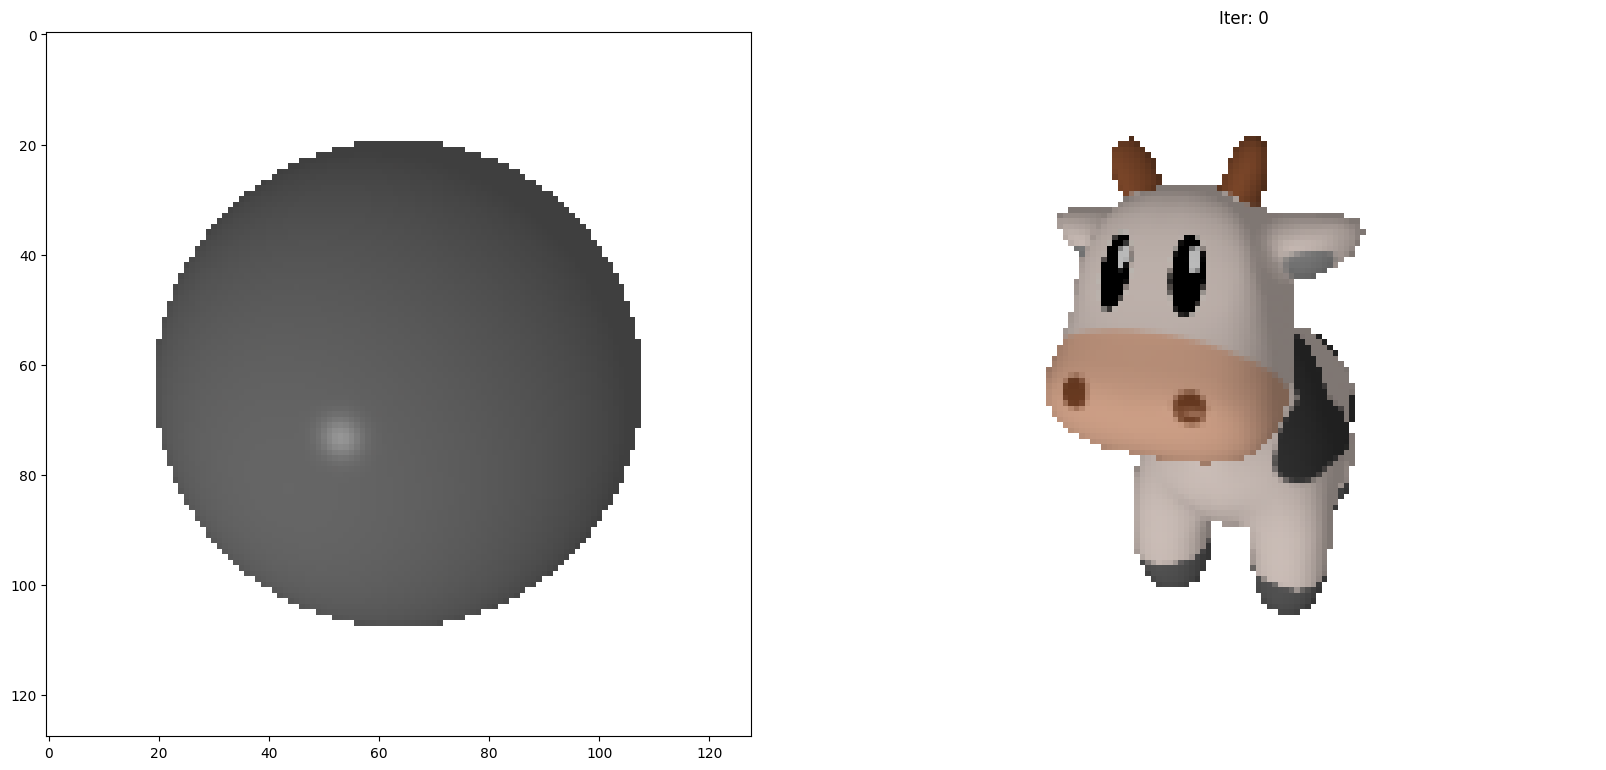

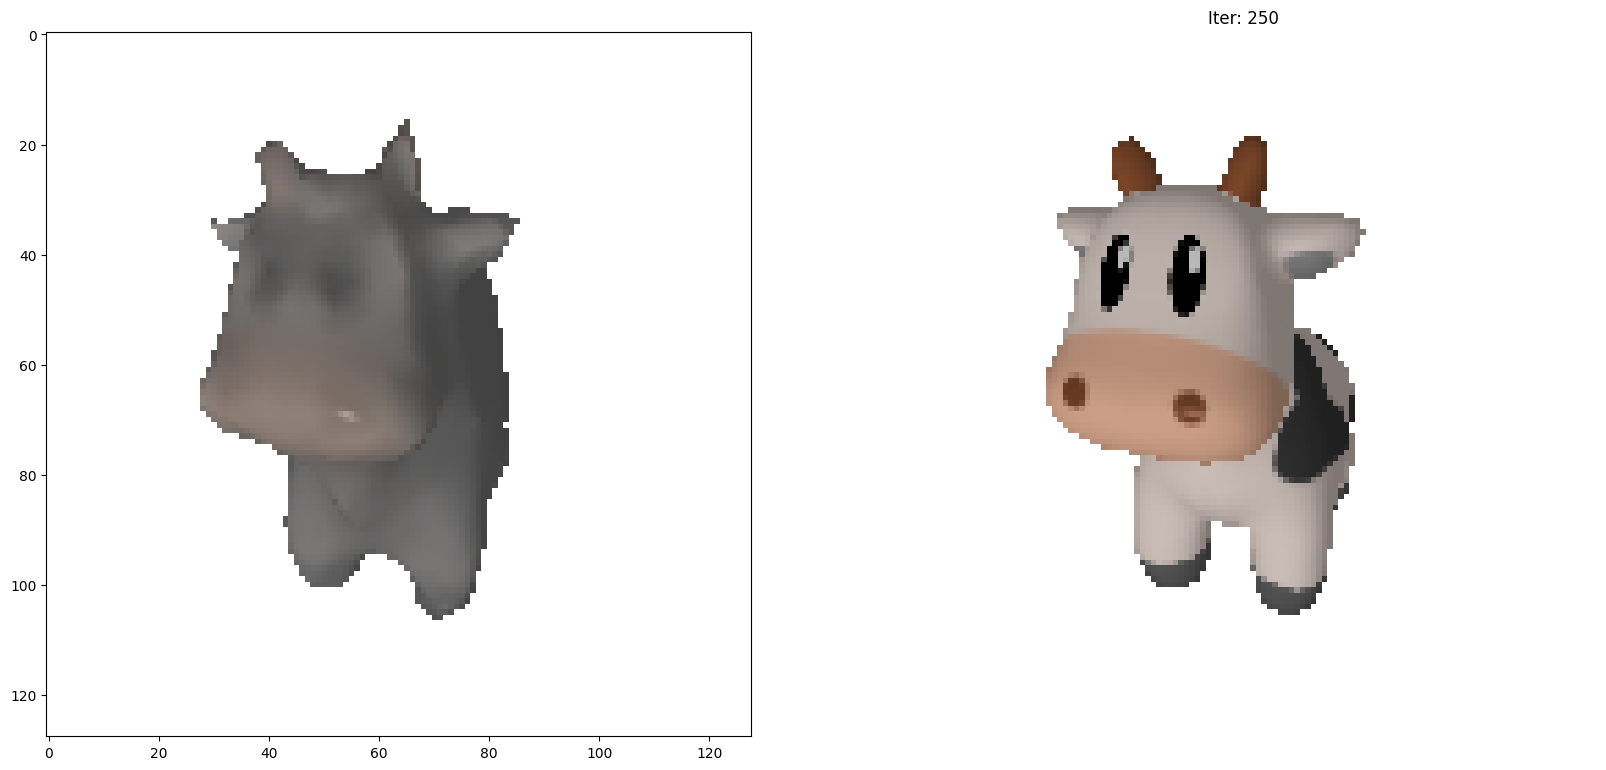

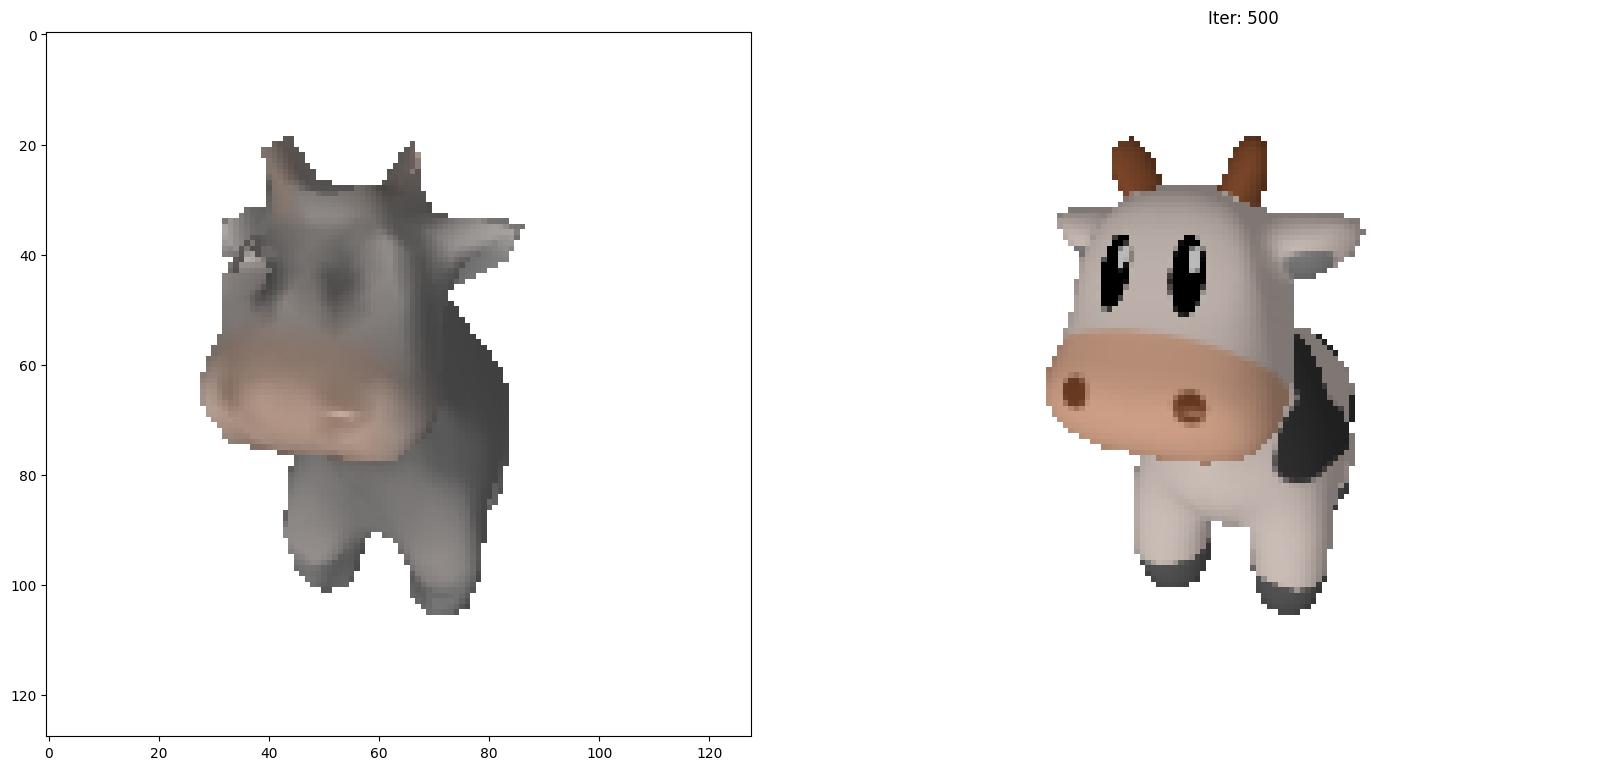

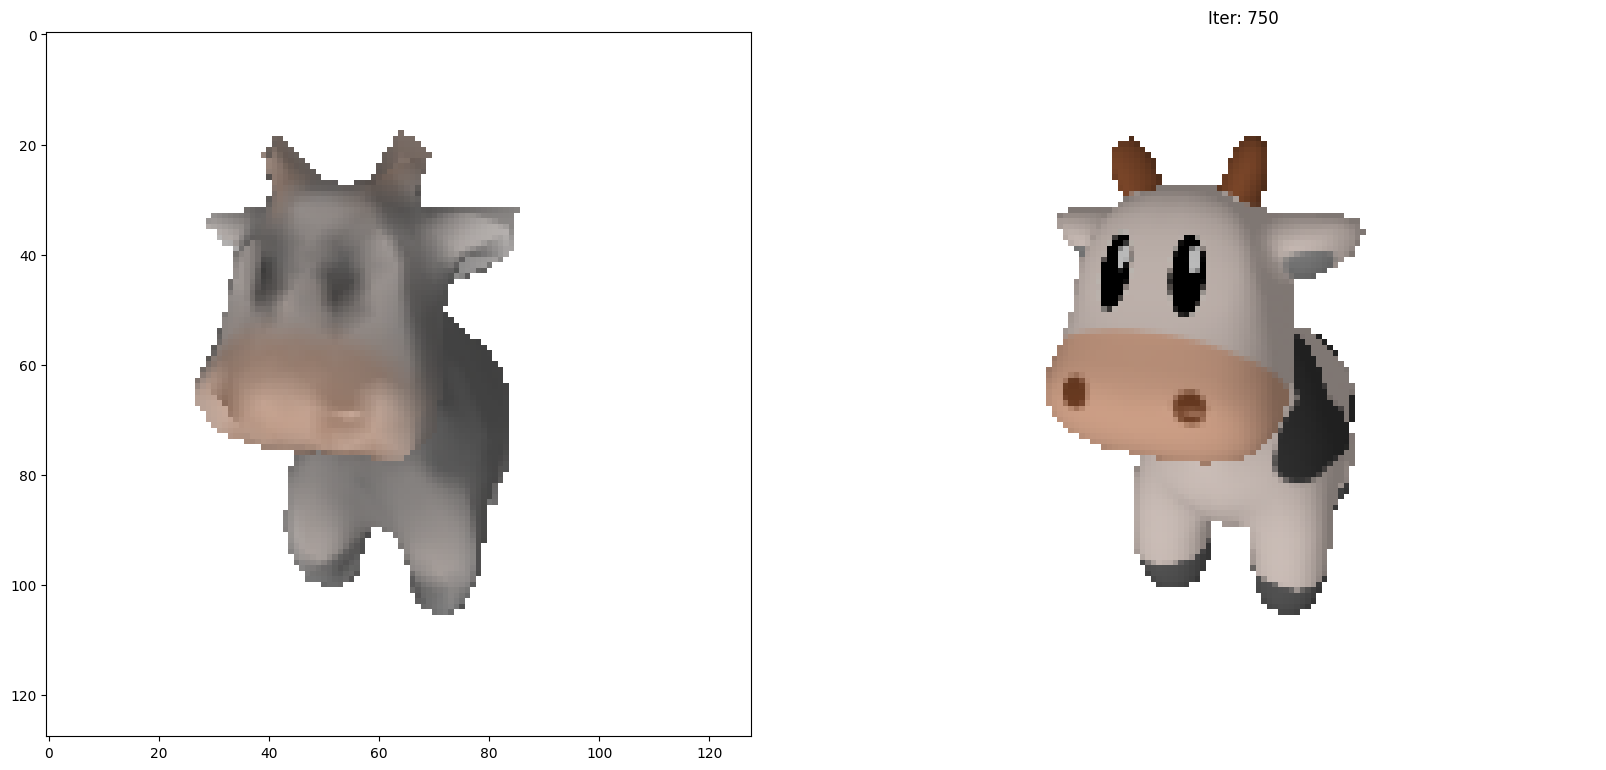

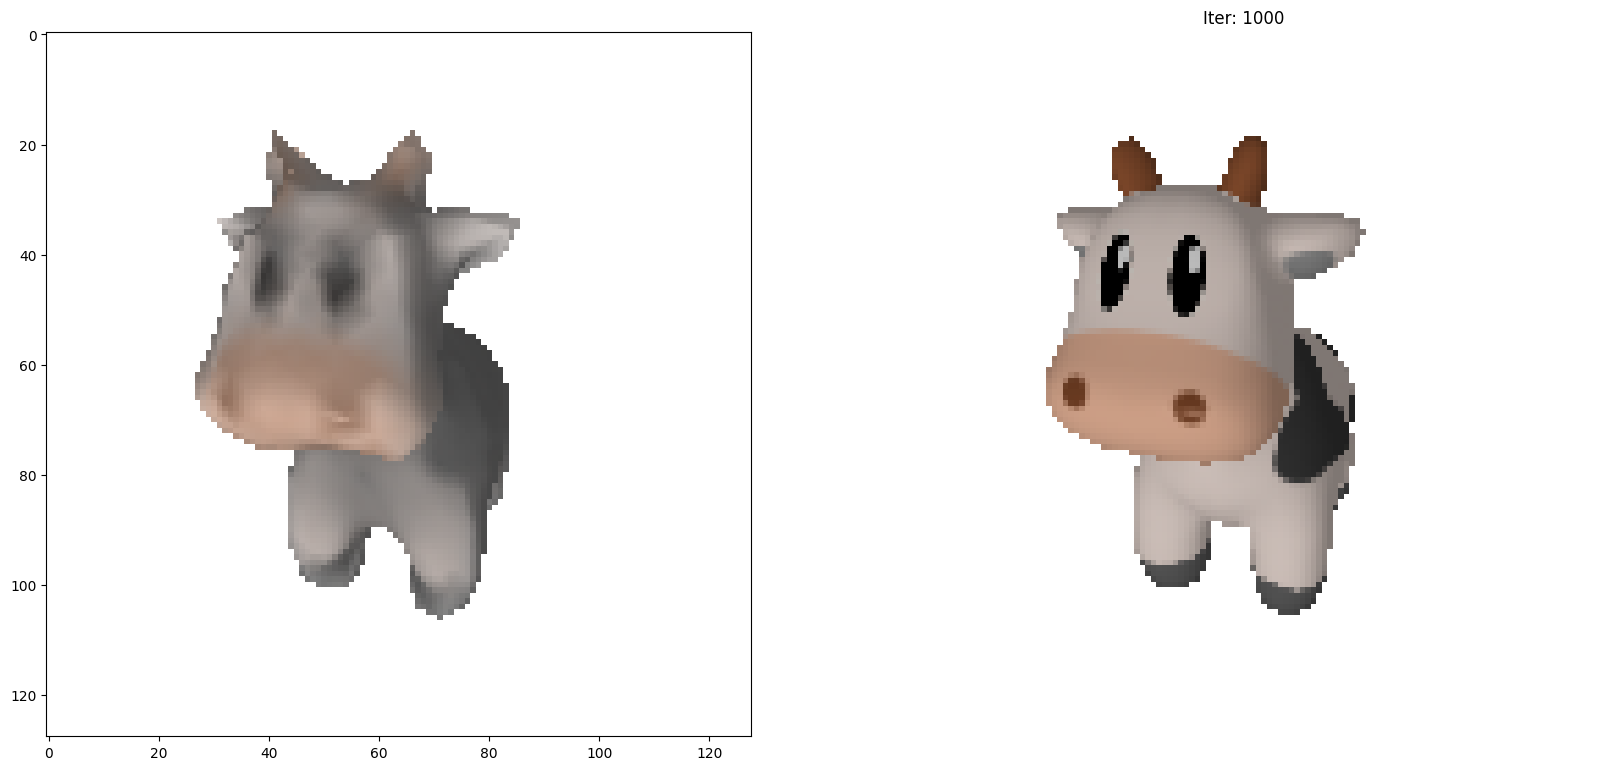

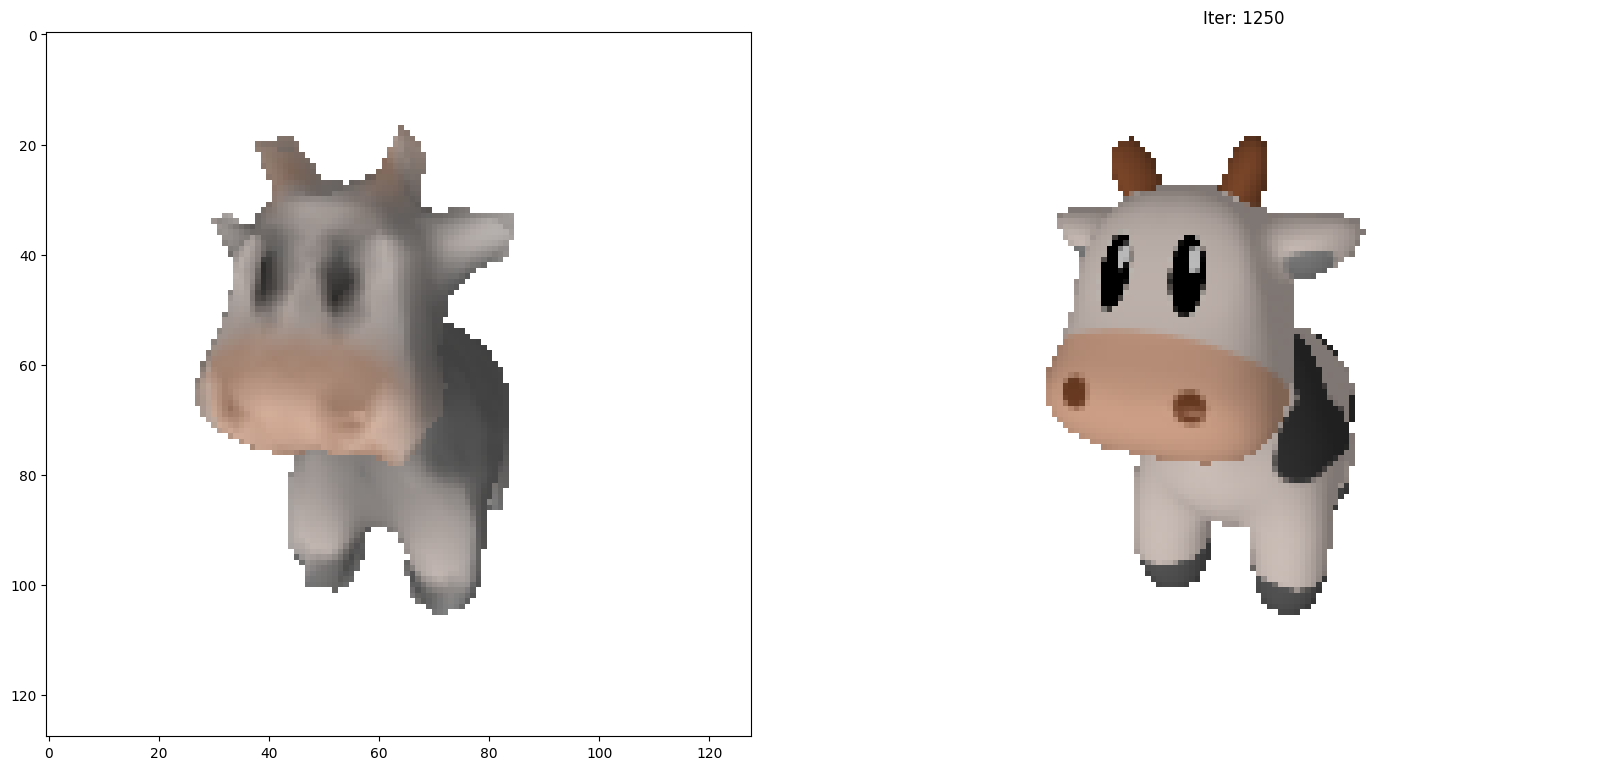

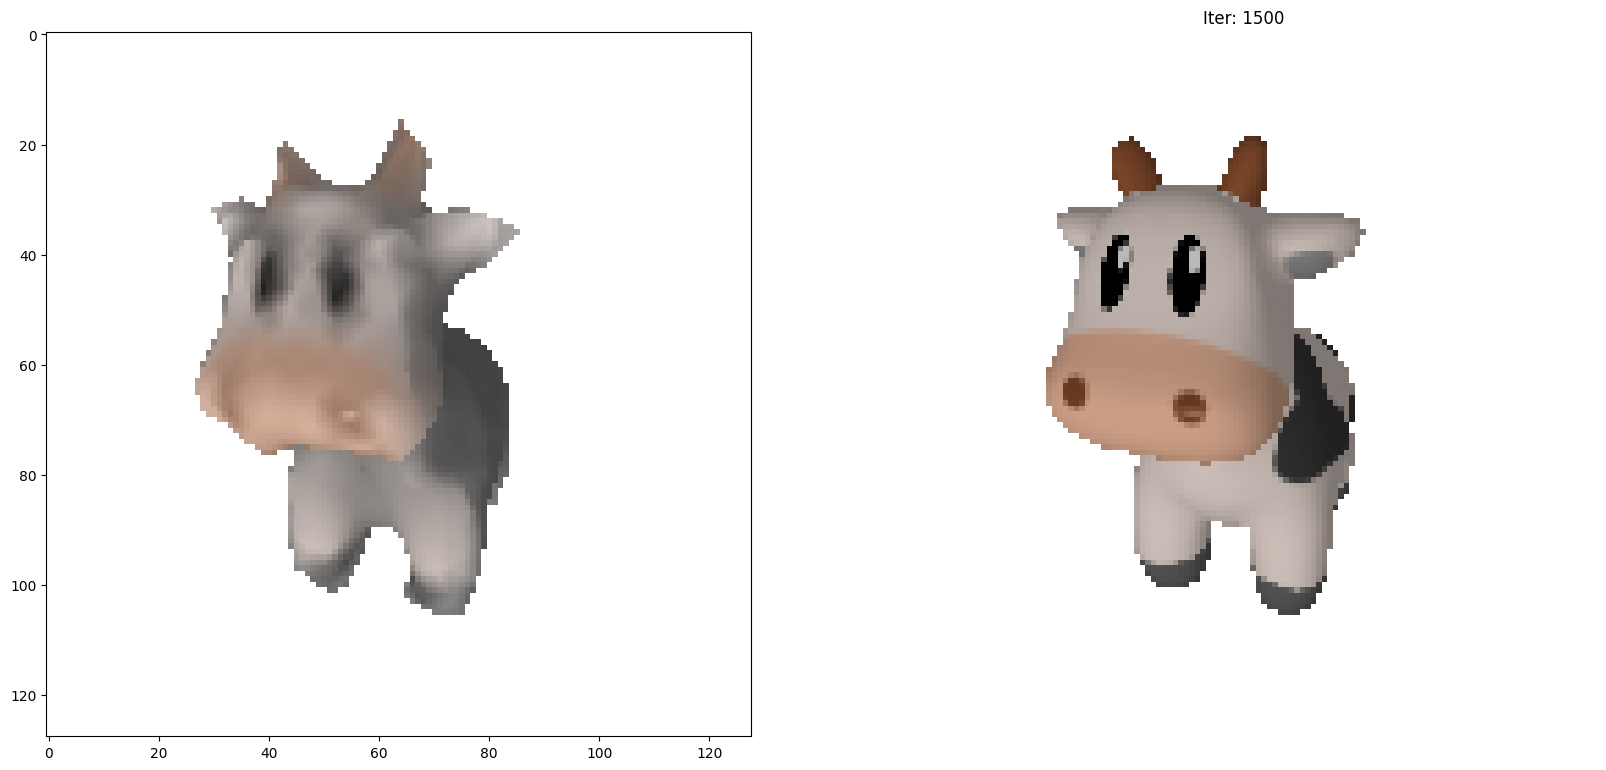

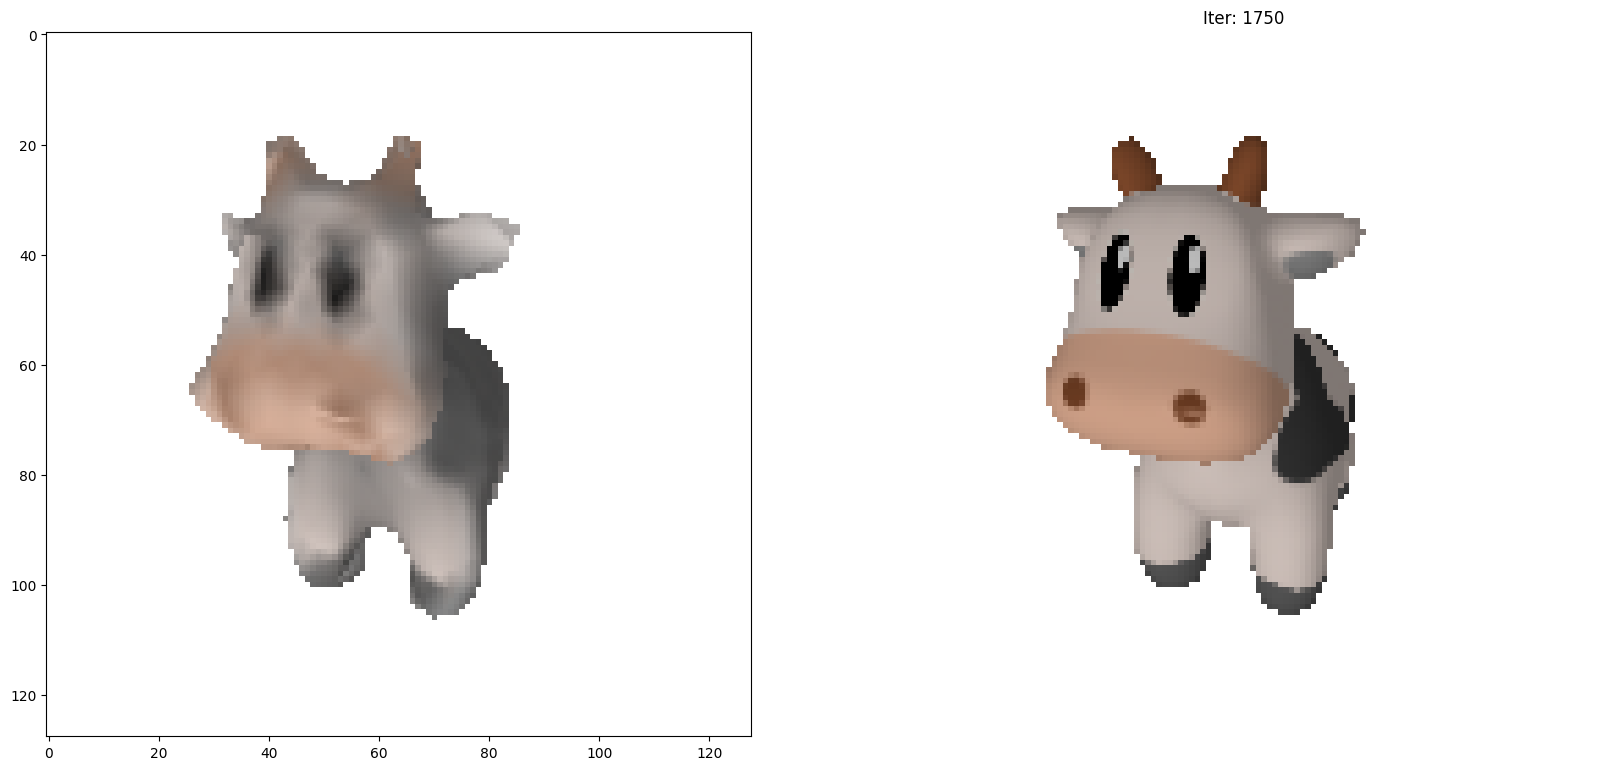

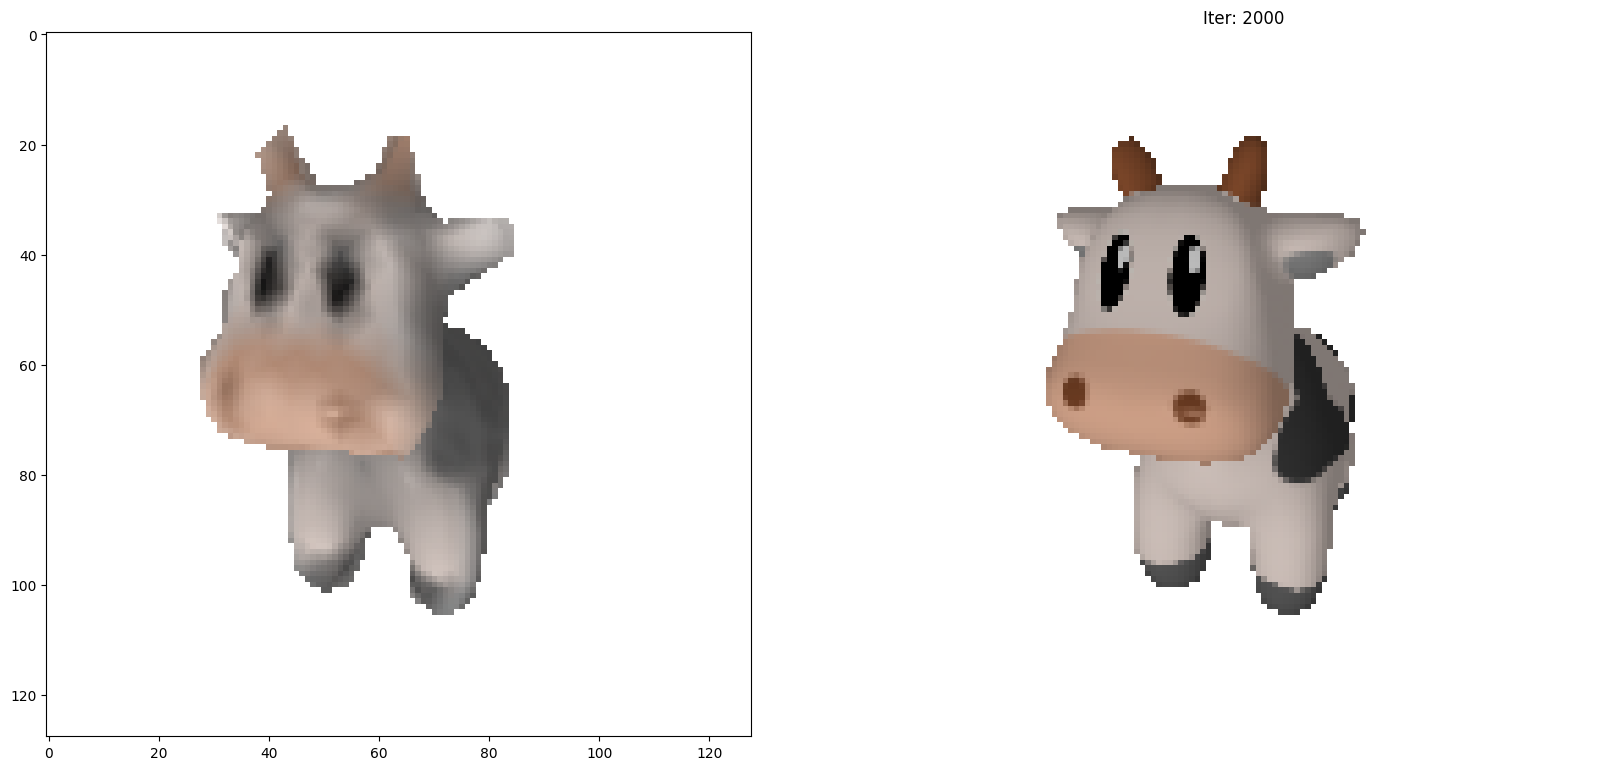

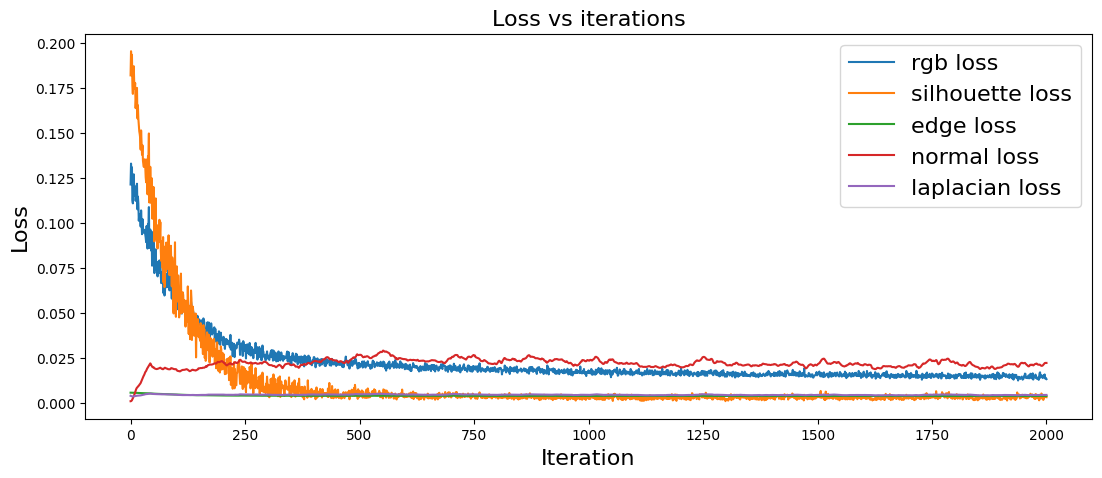

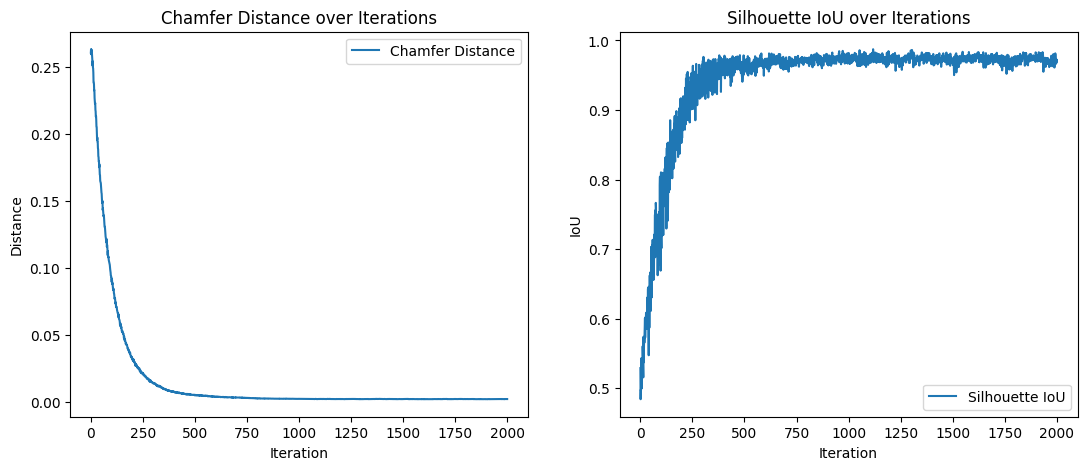

Training cycle with object 1 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

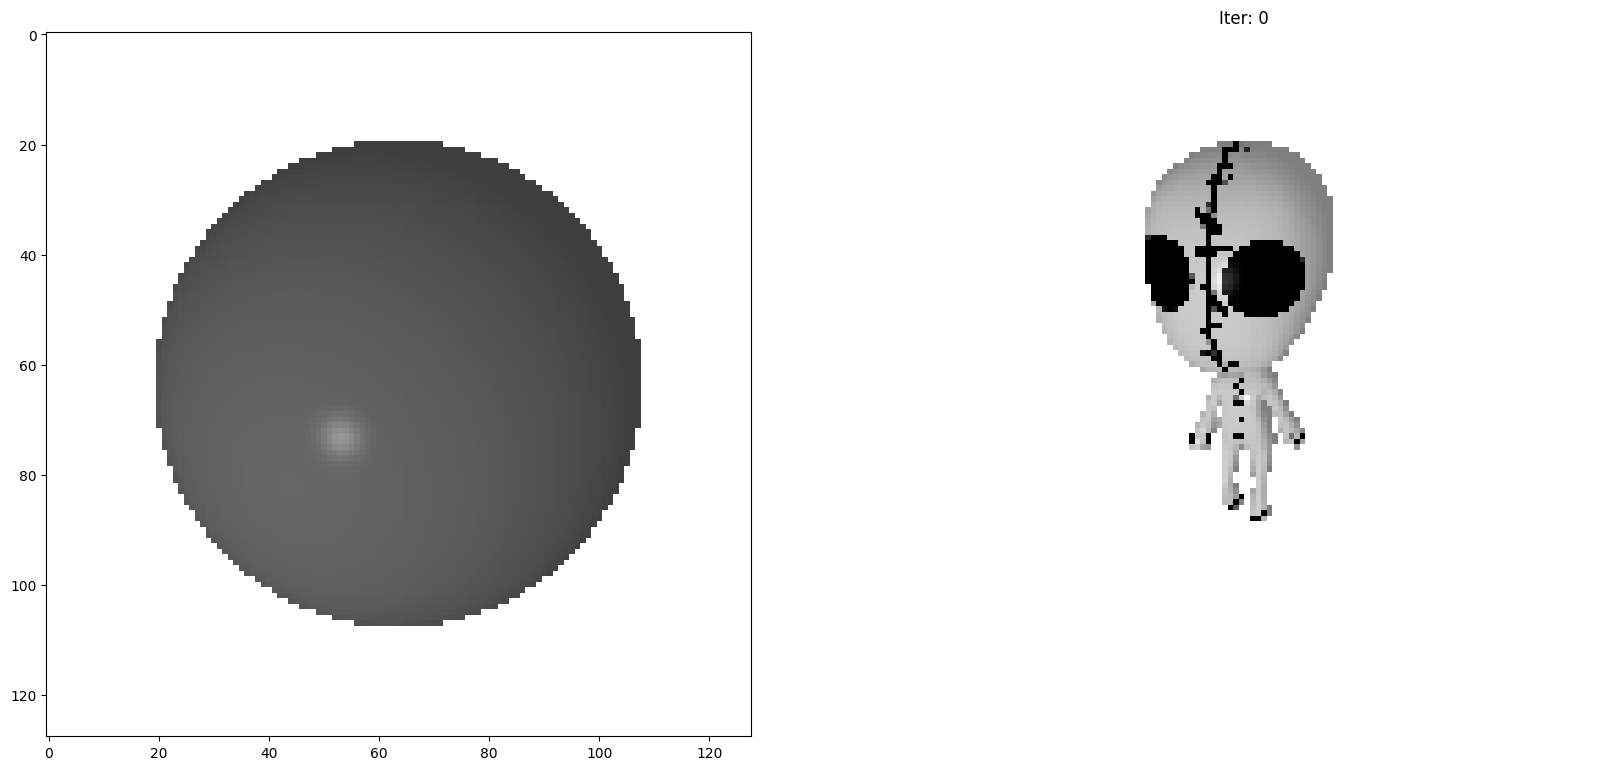

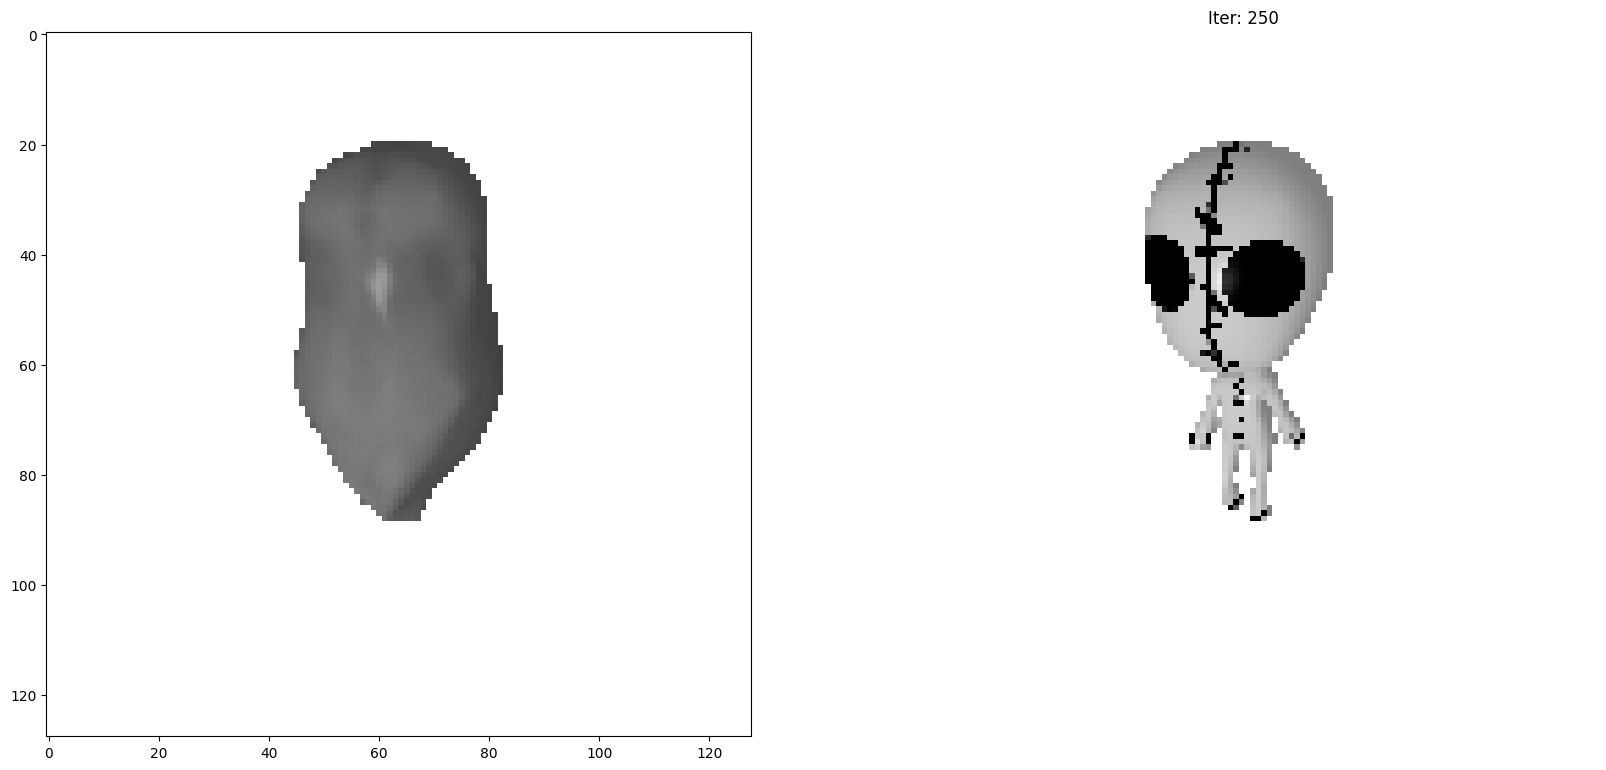

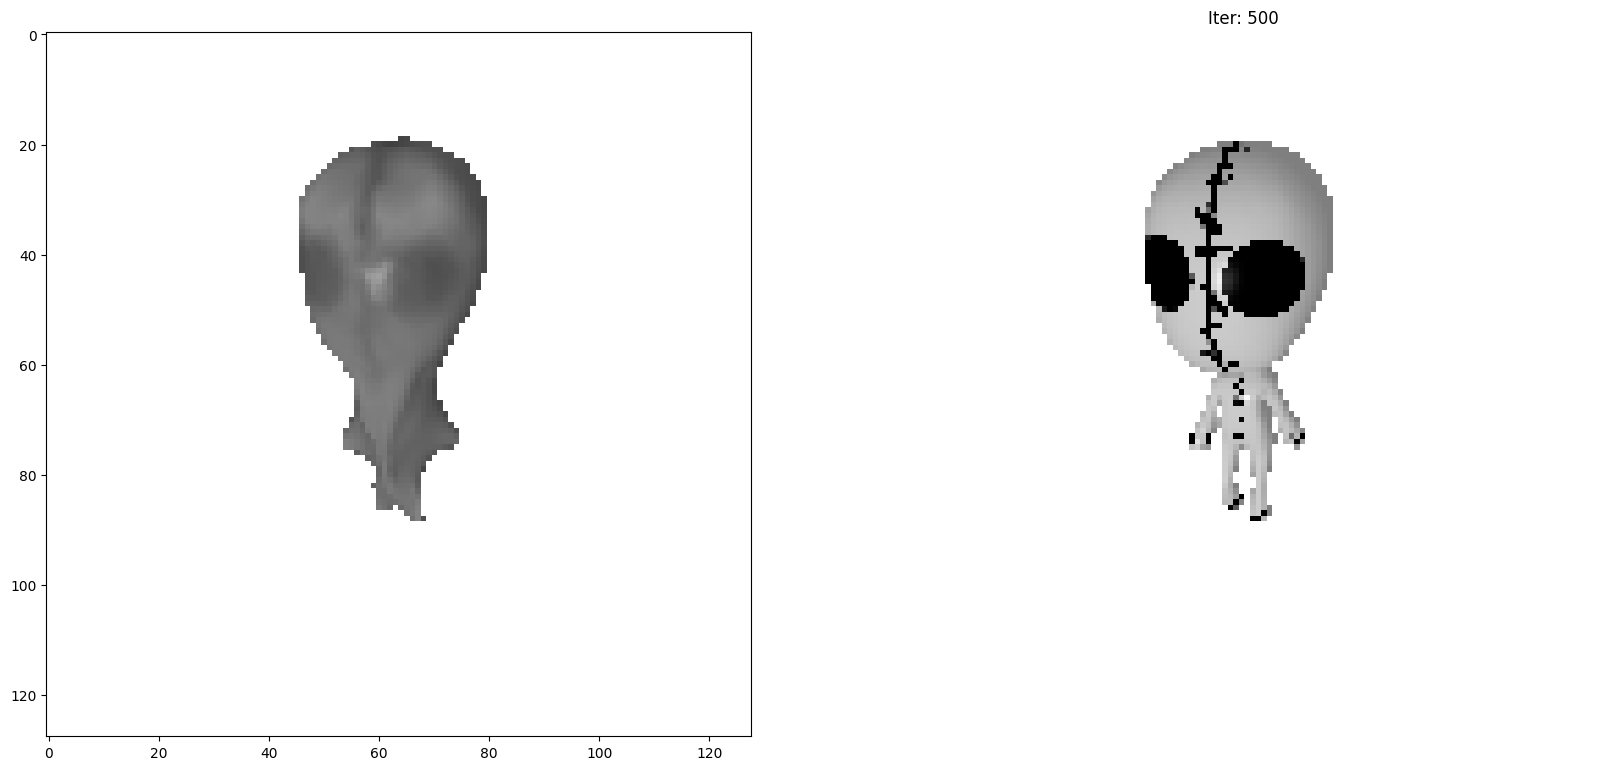

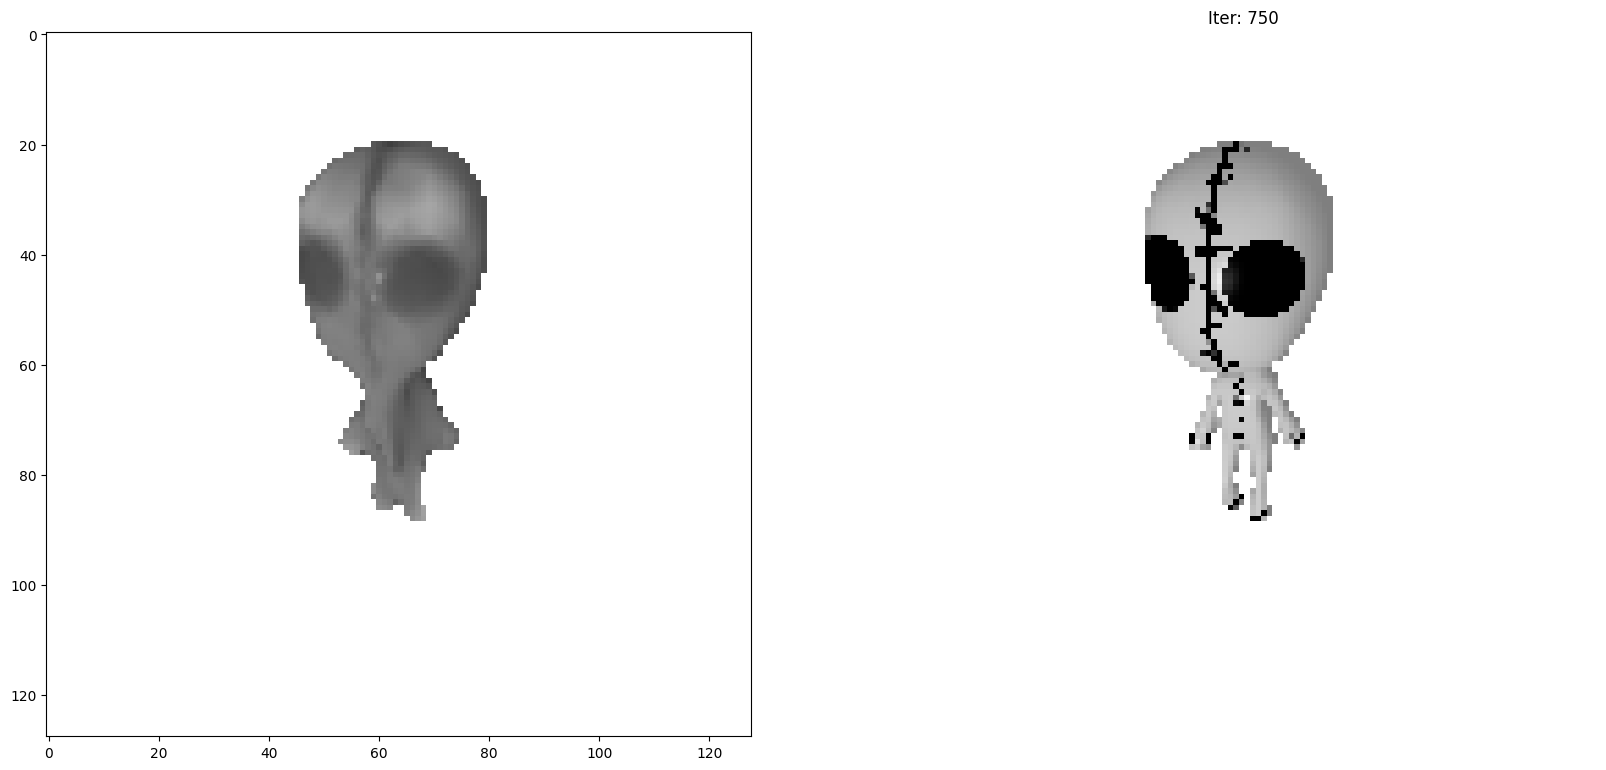

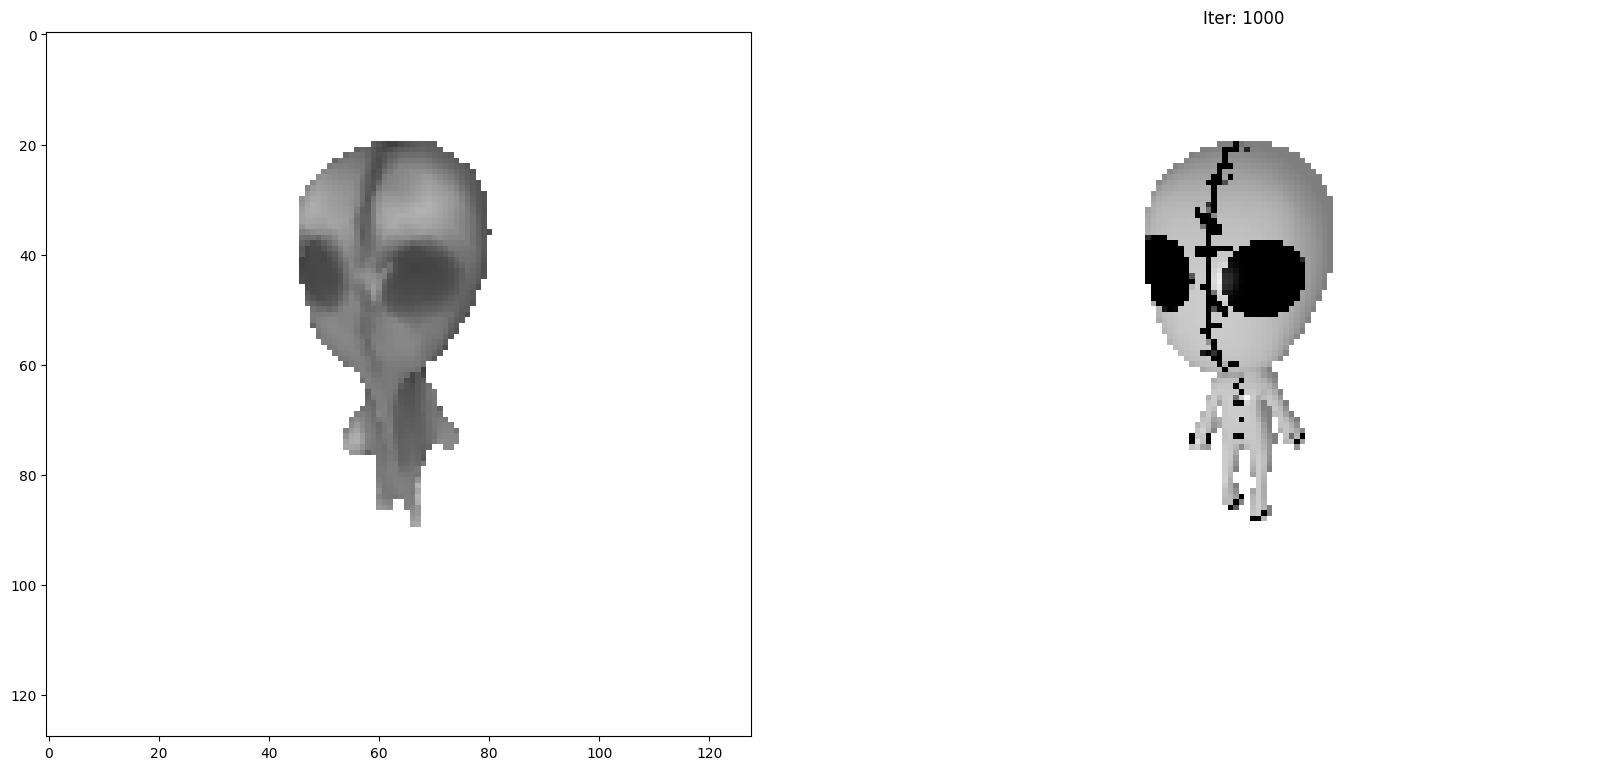

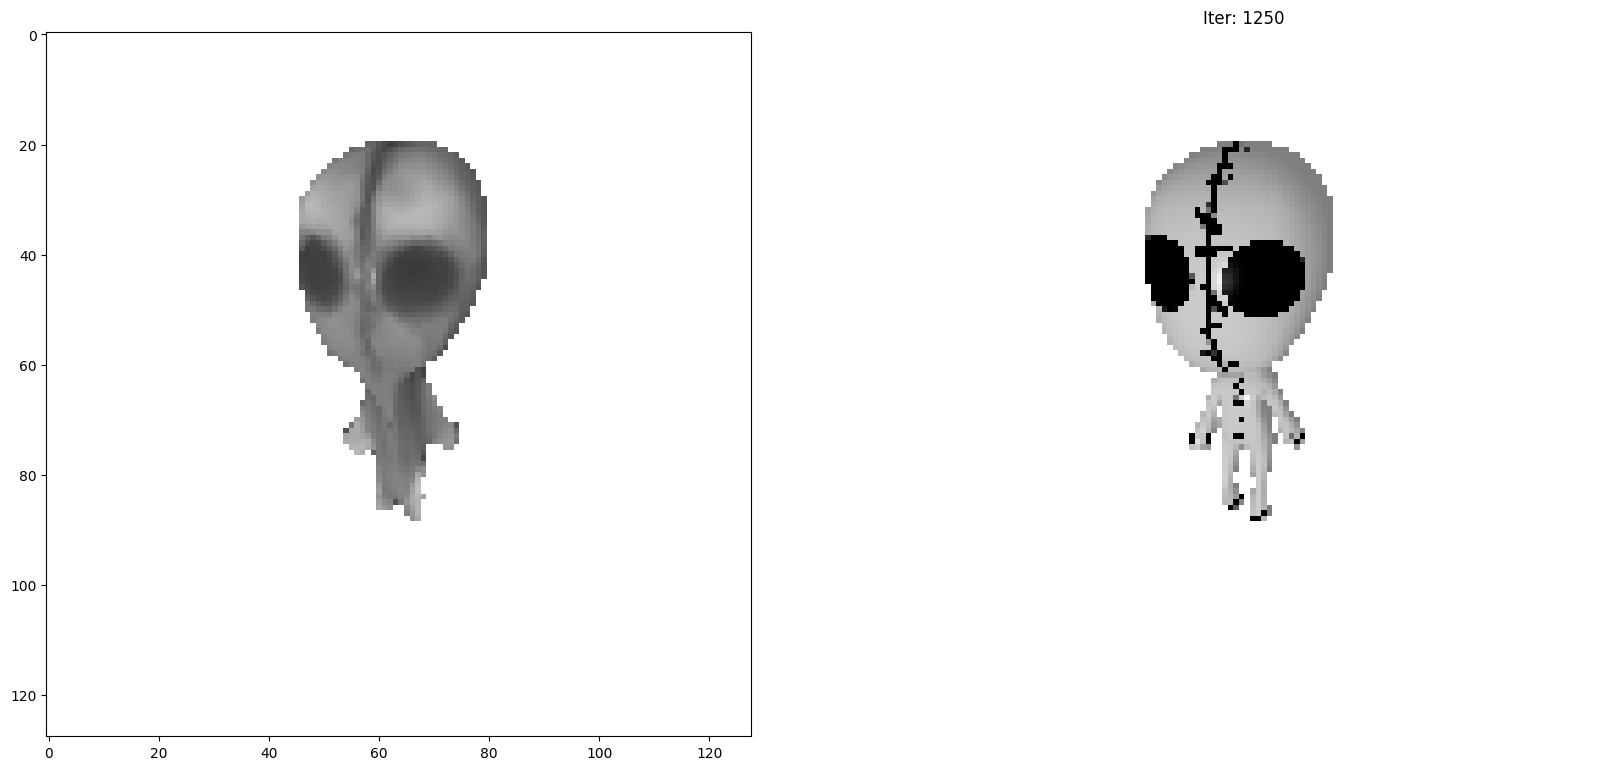

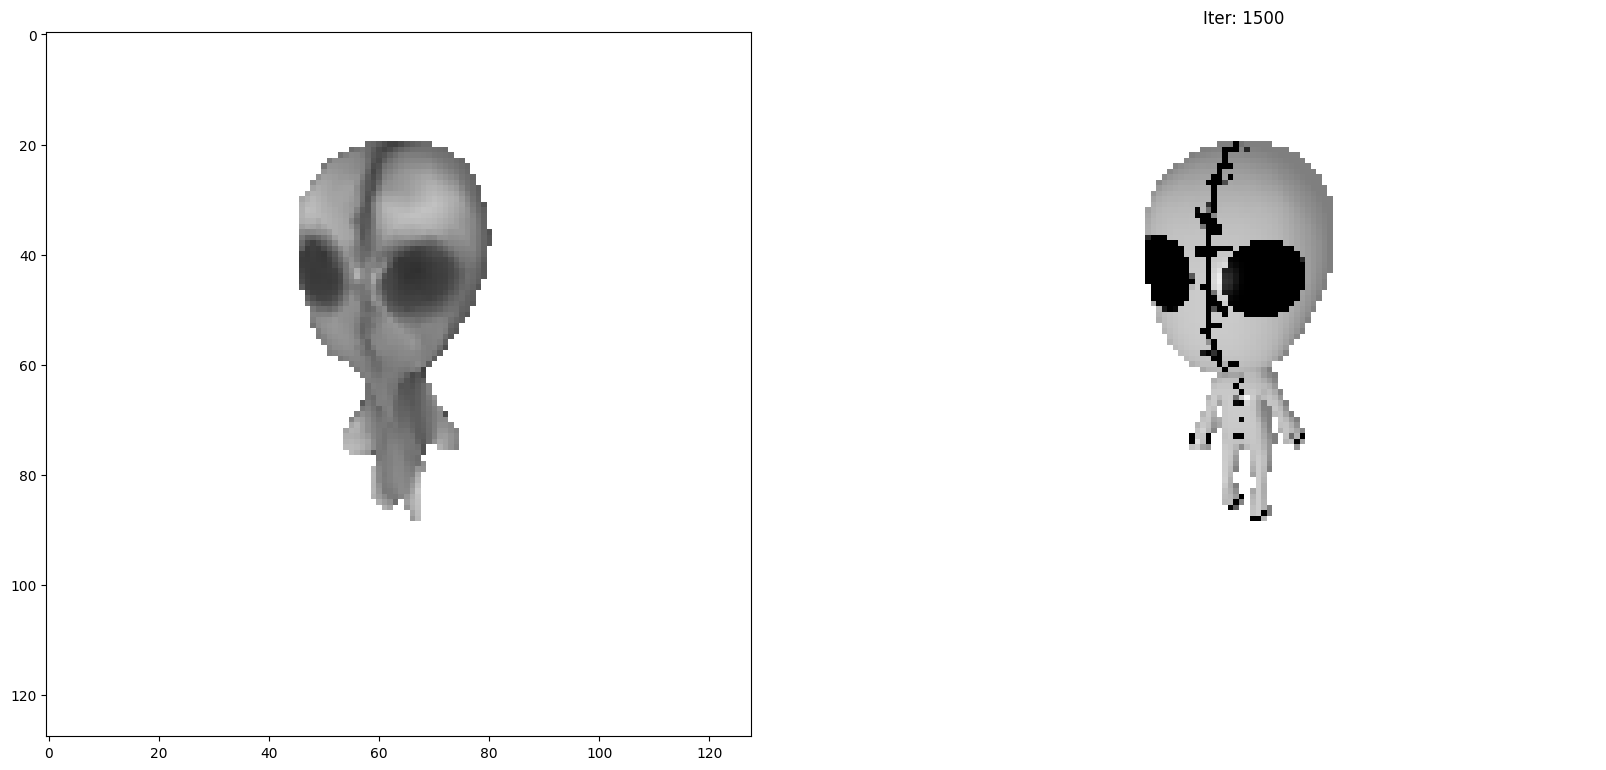

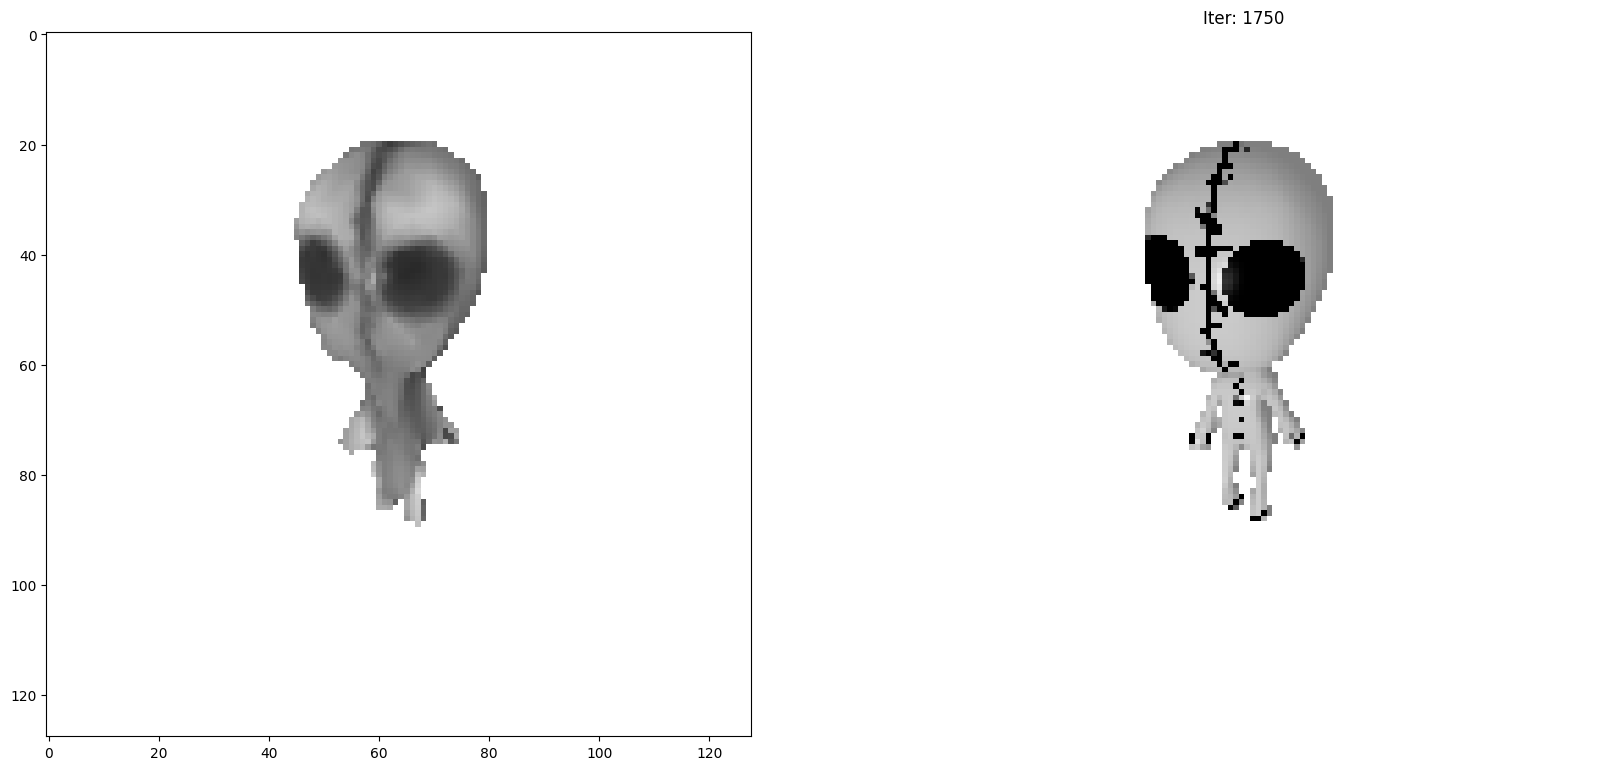

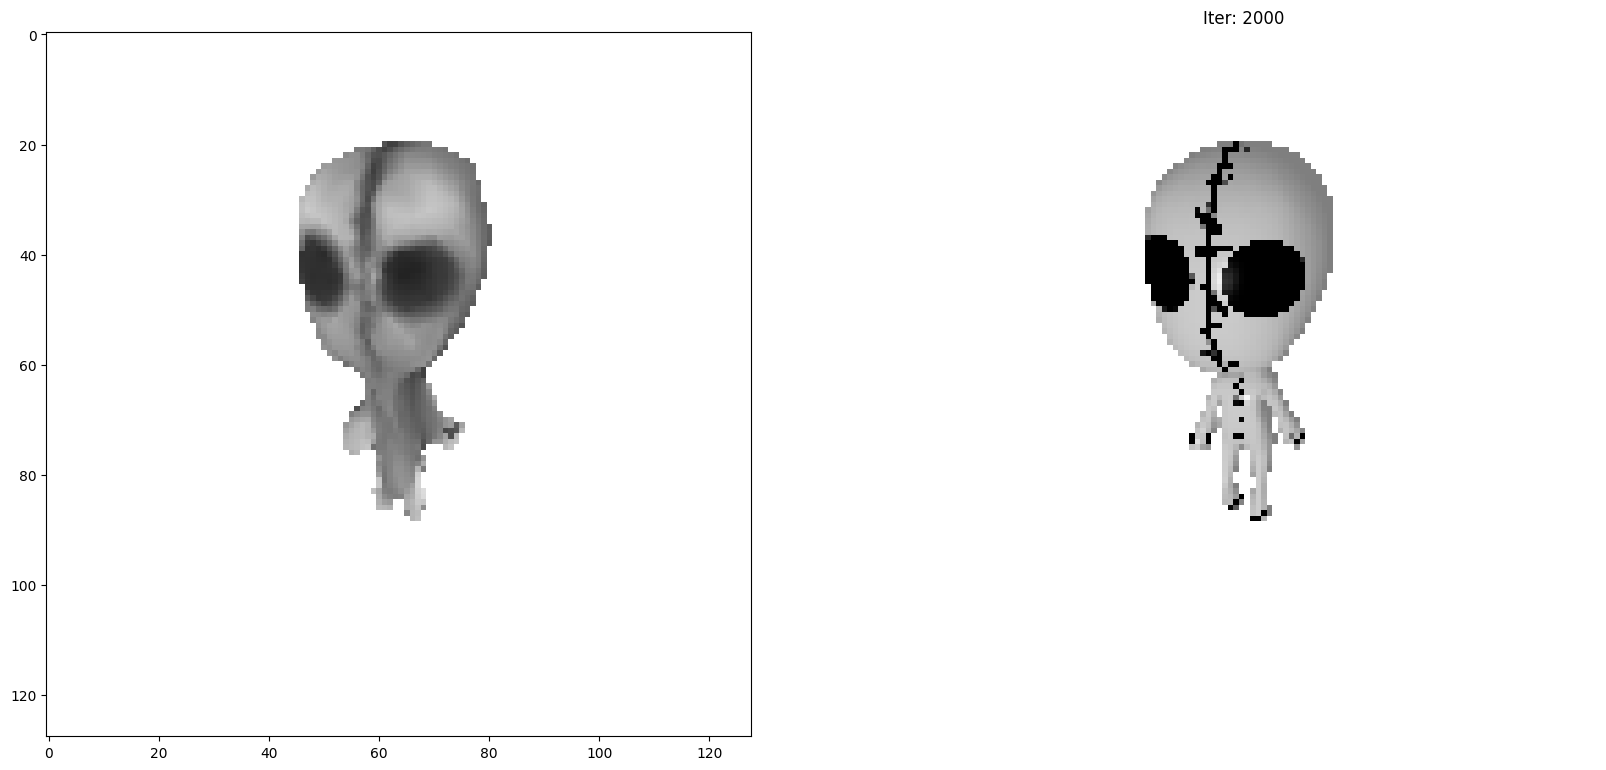

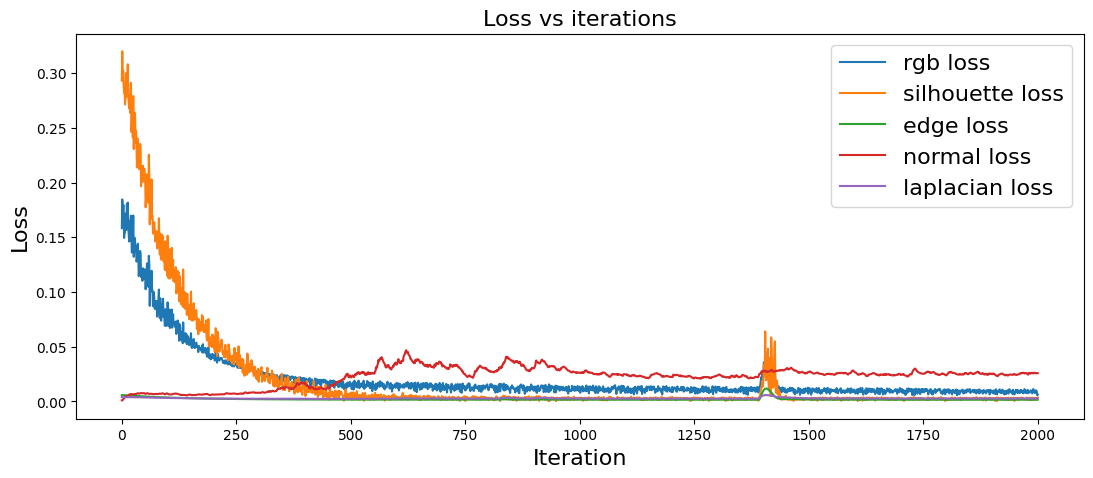

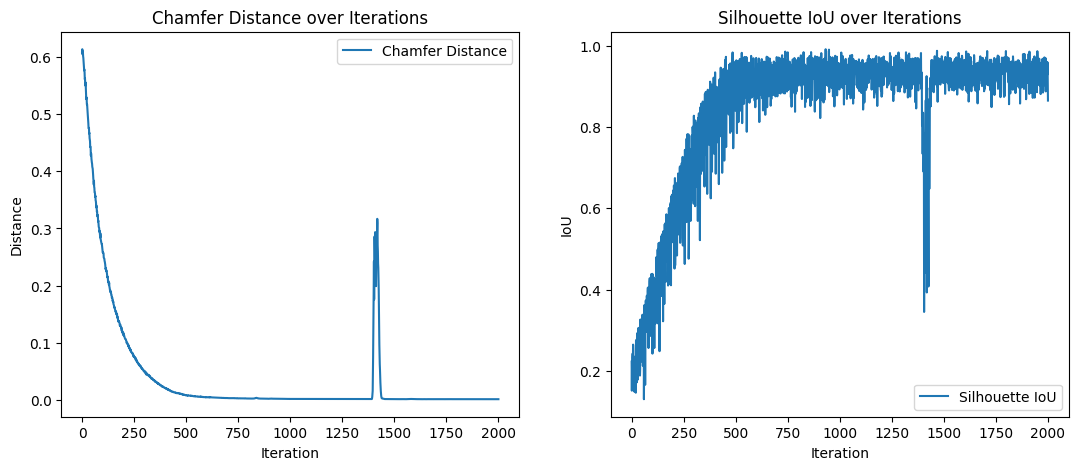

Training cycle with object 2 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

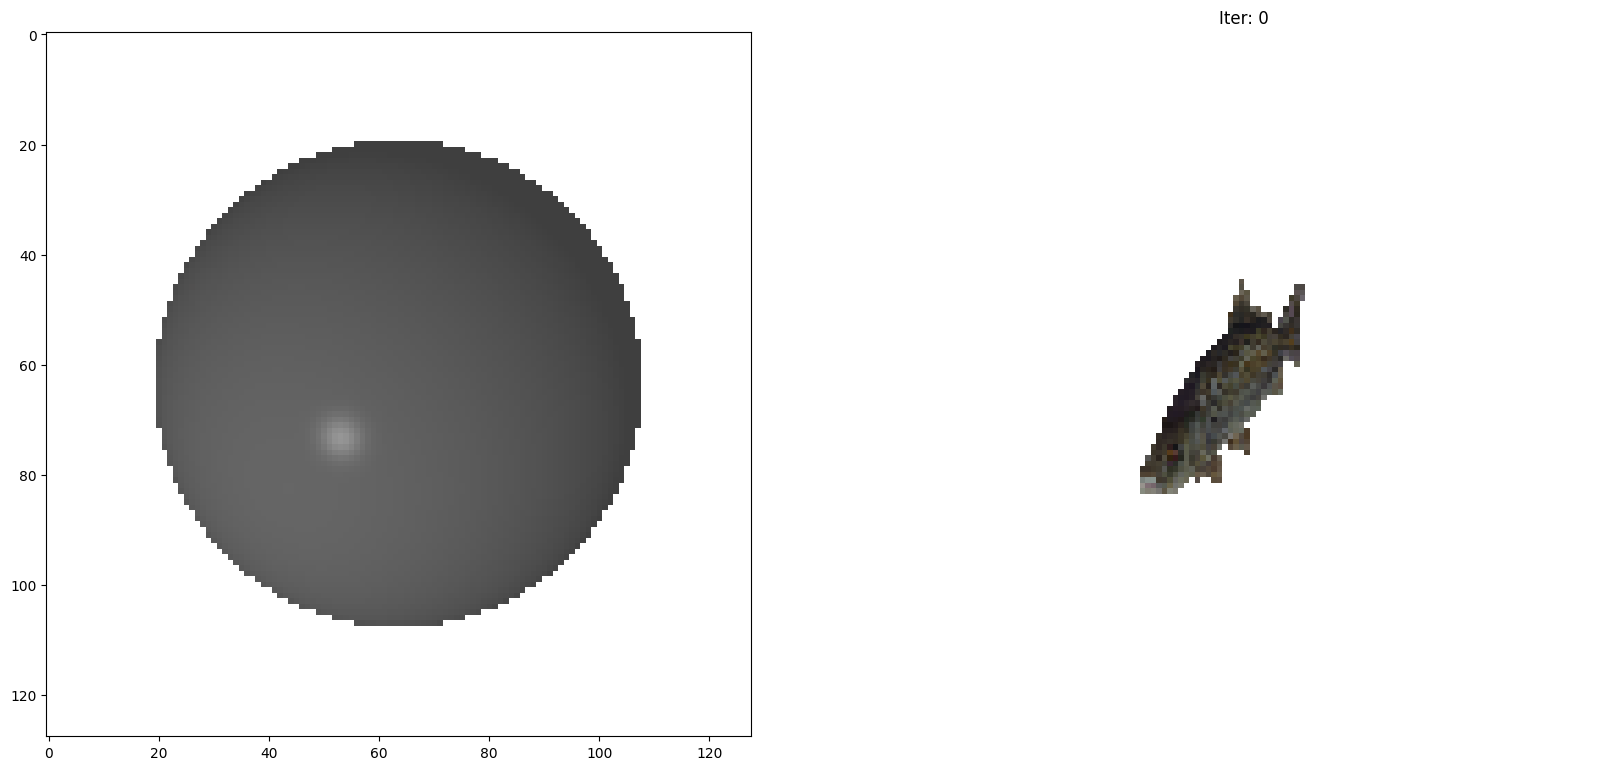

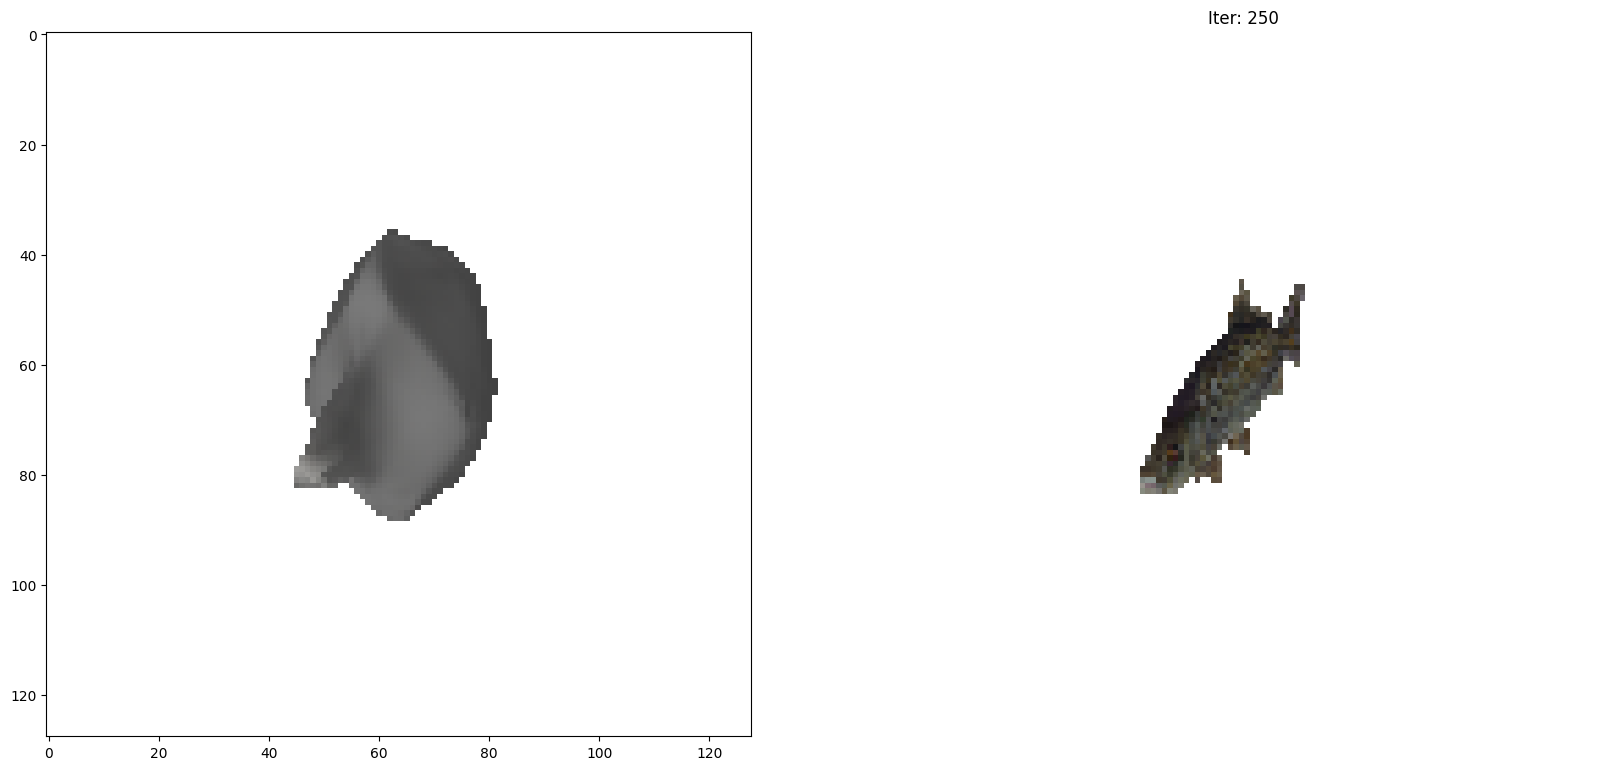

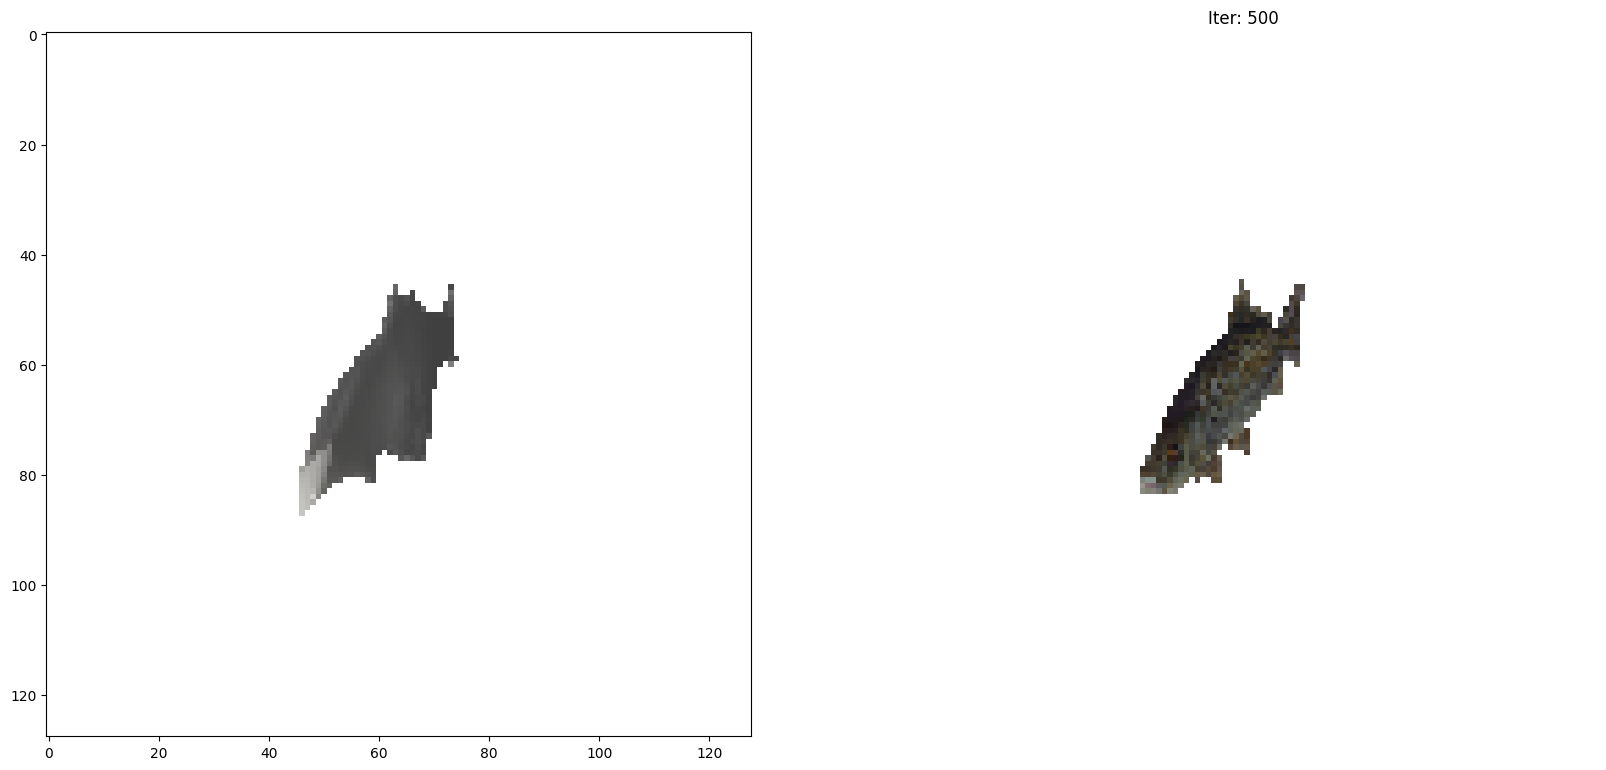

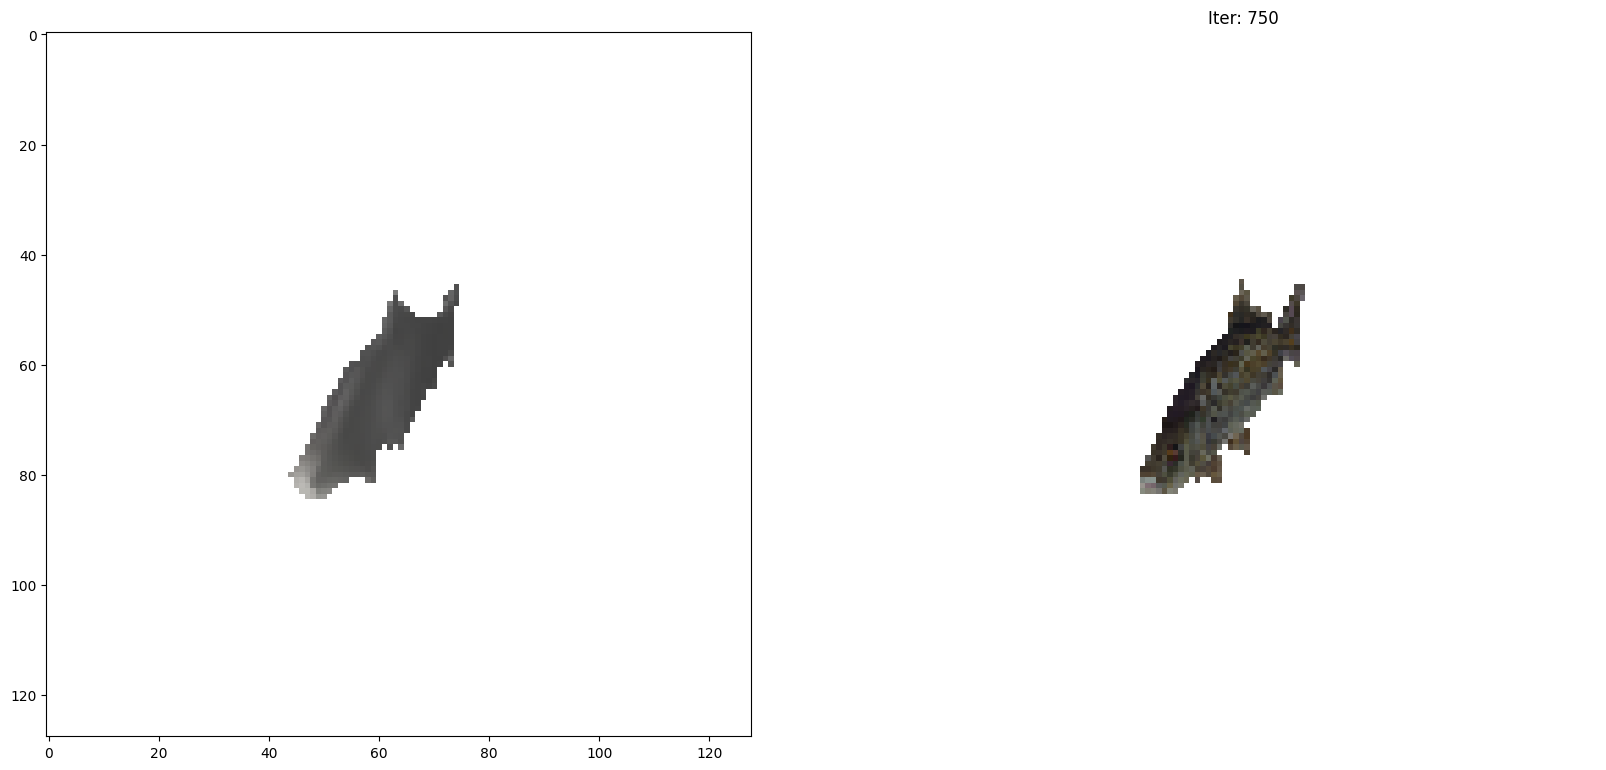

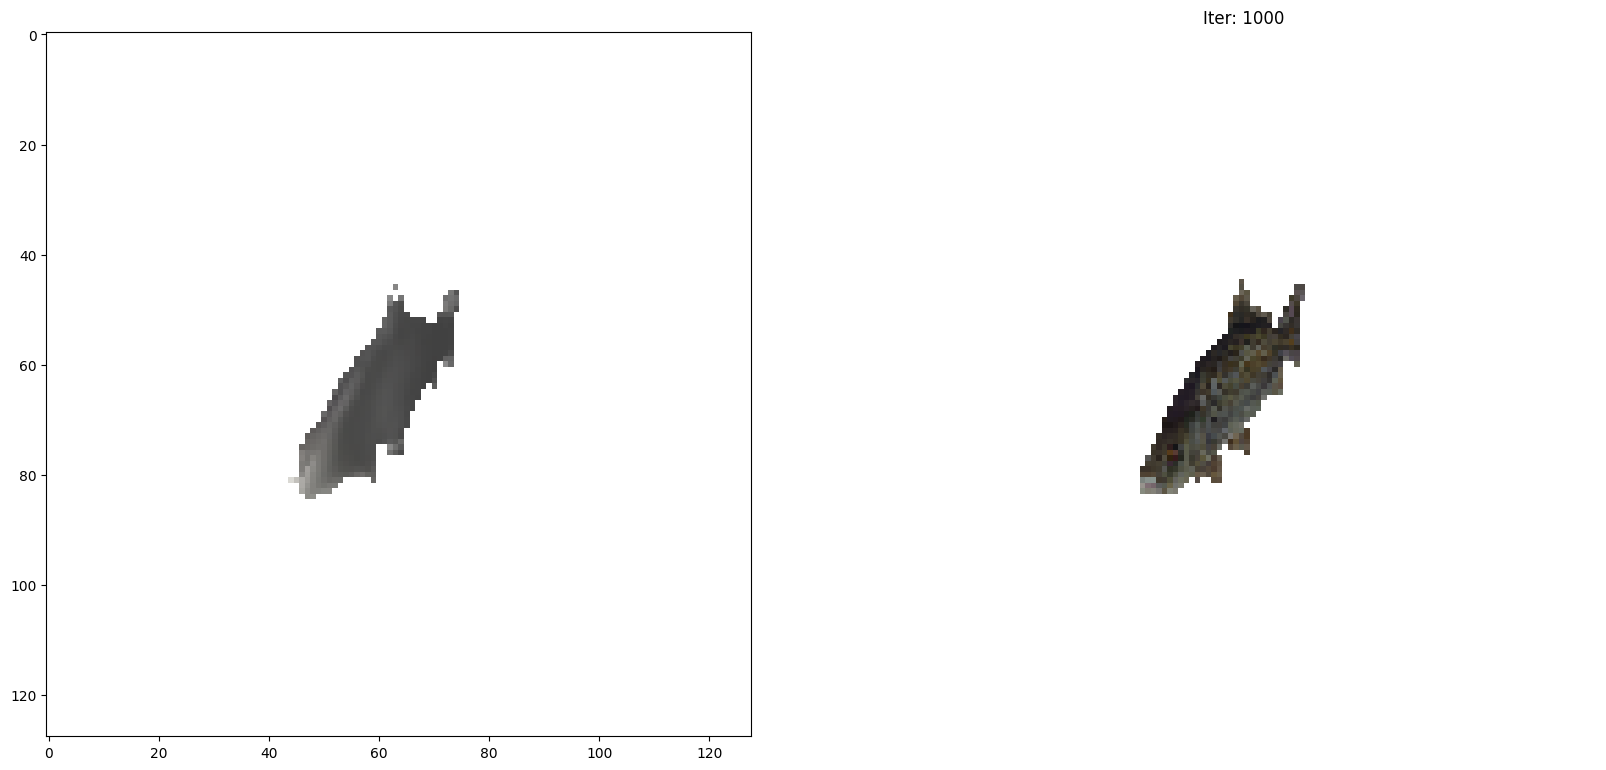

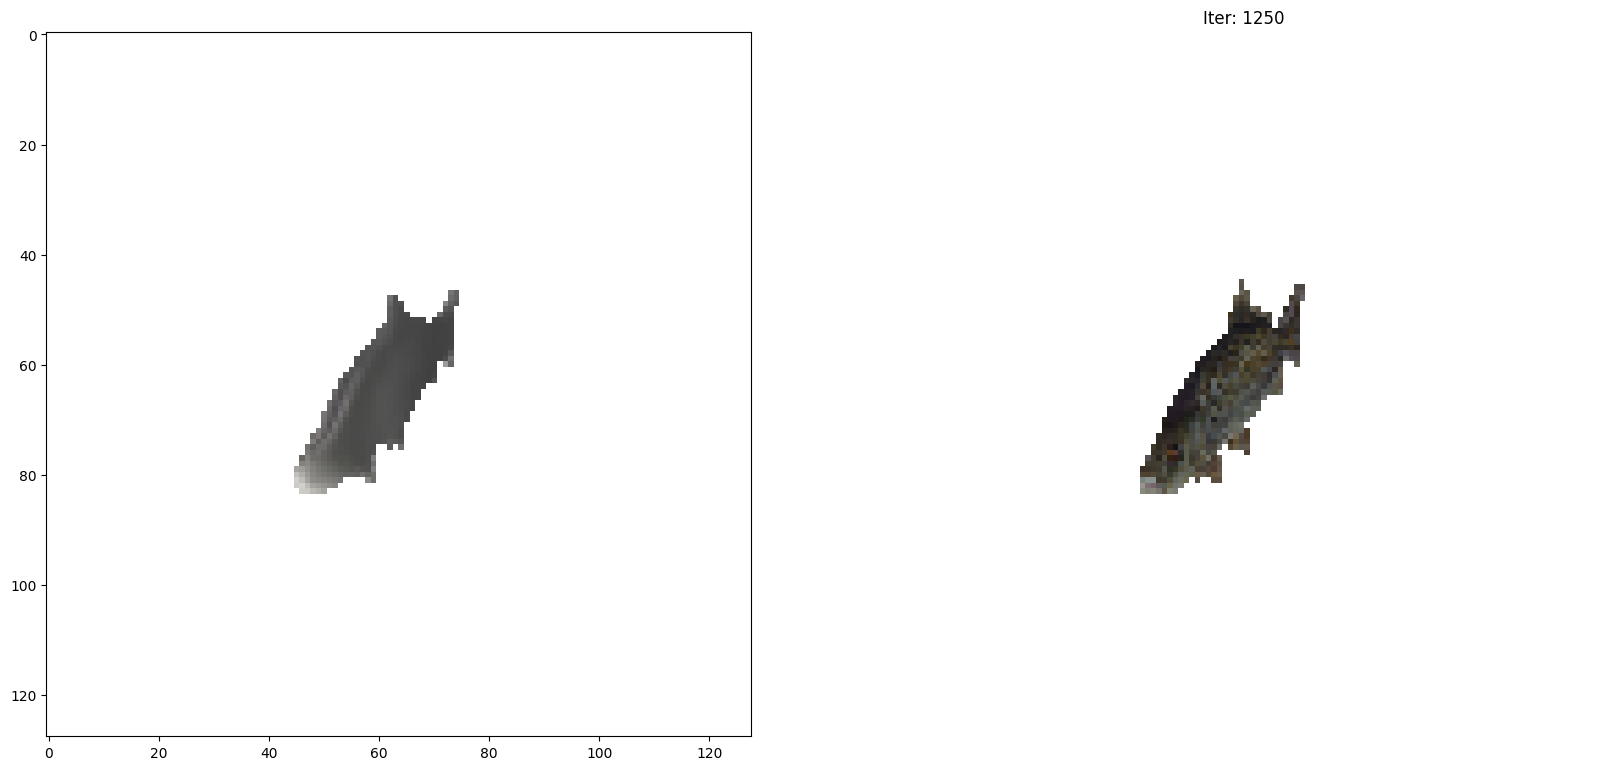

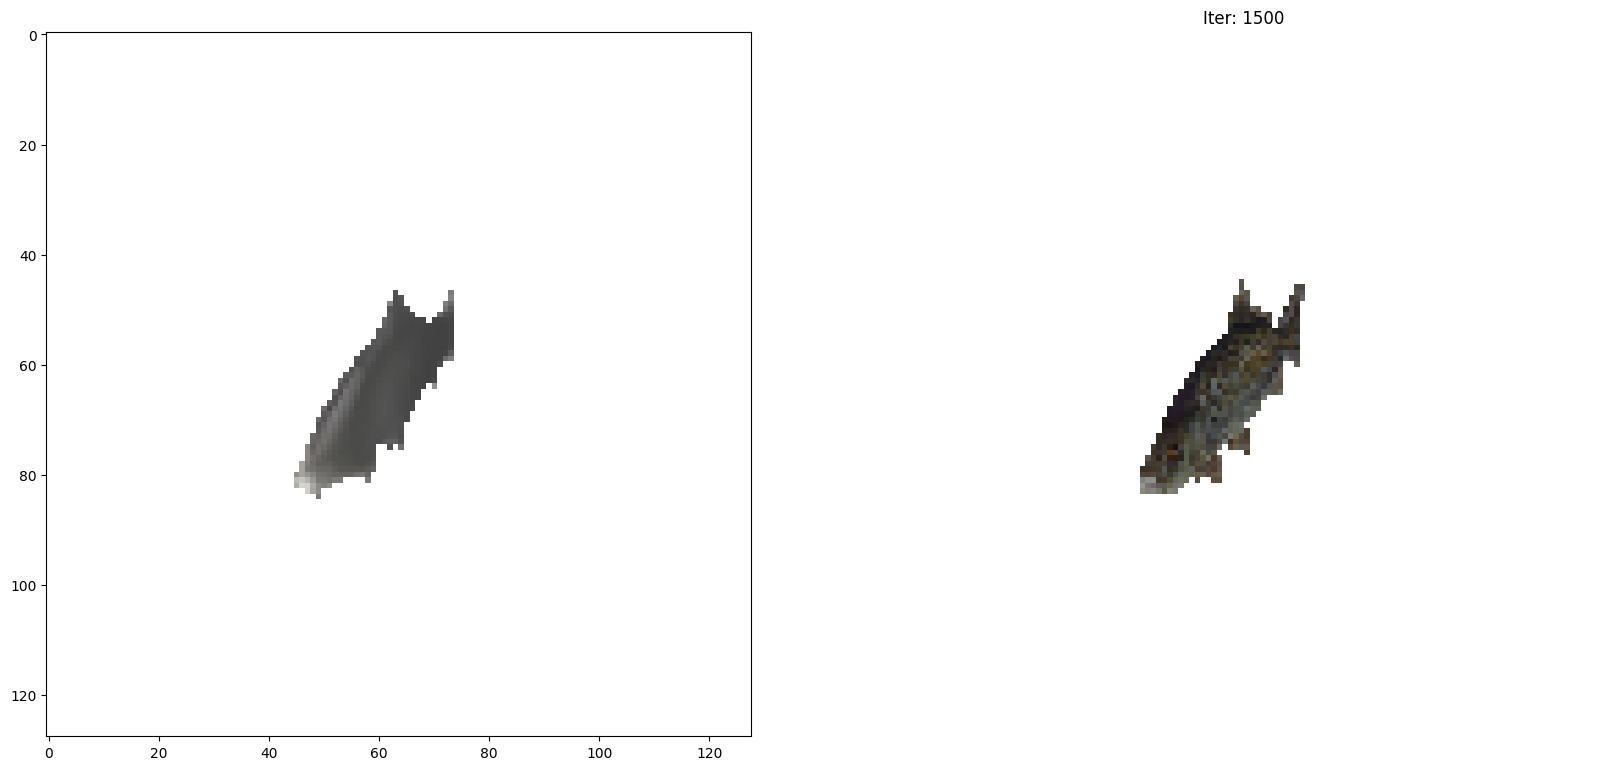

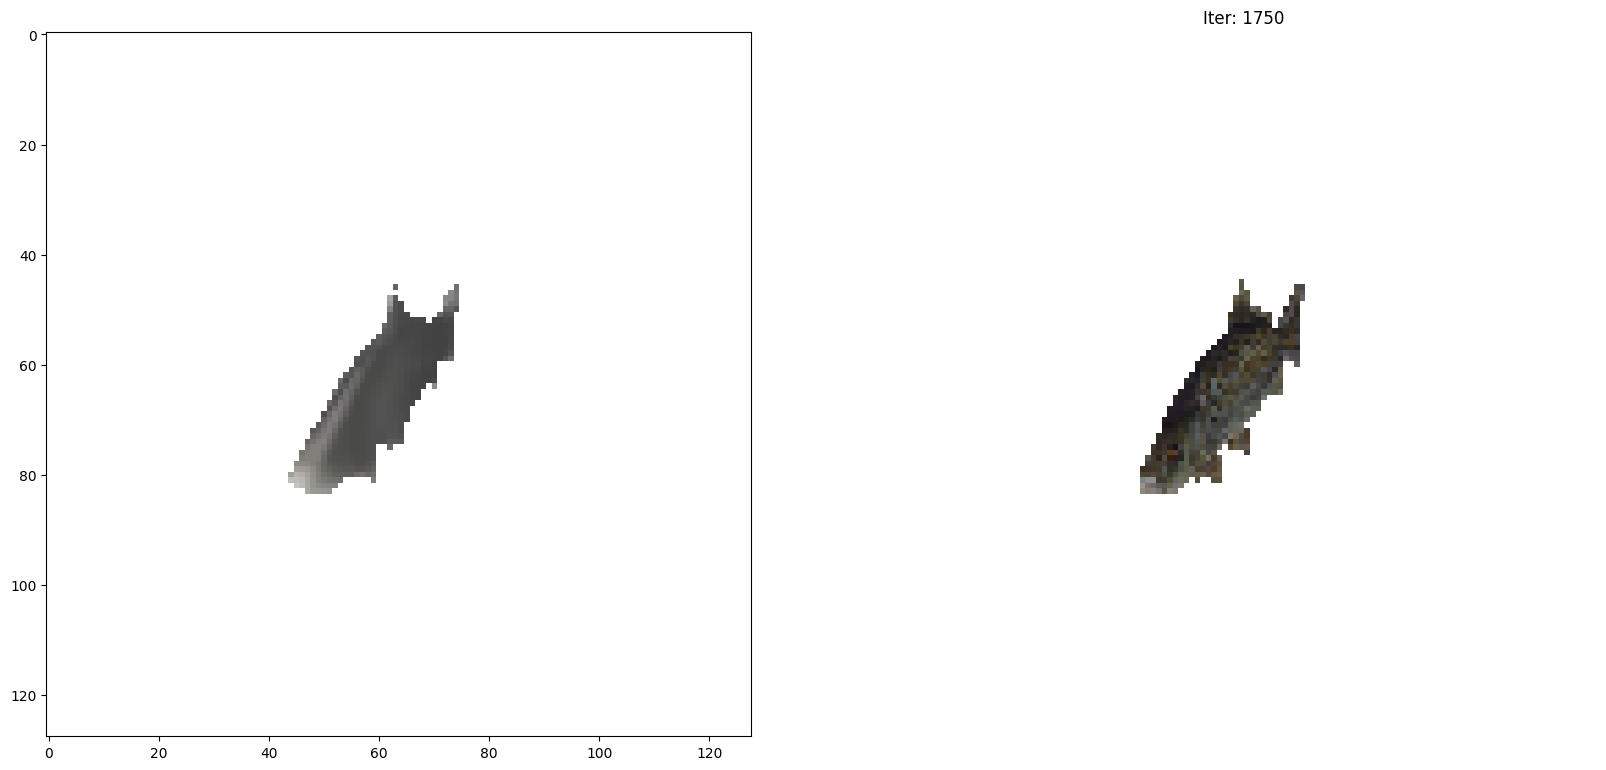

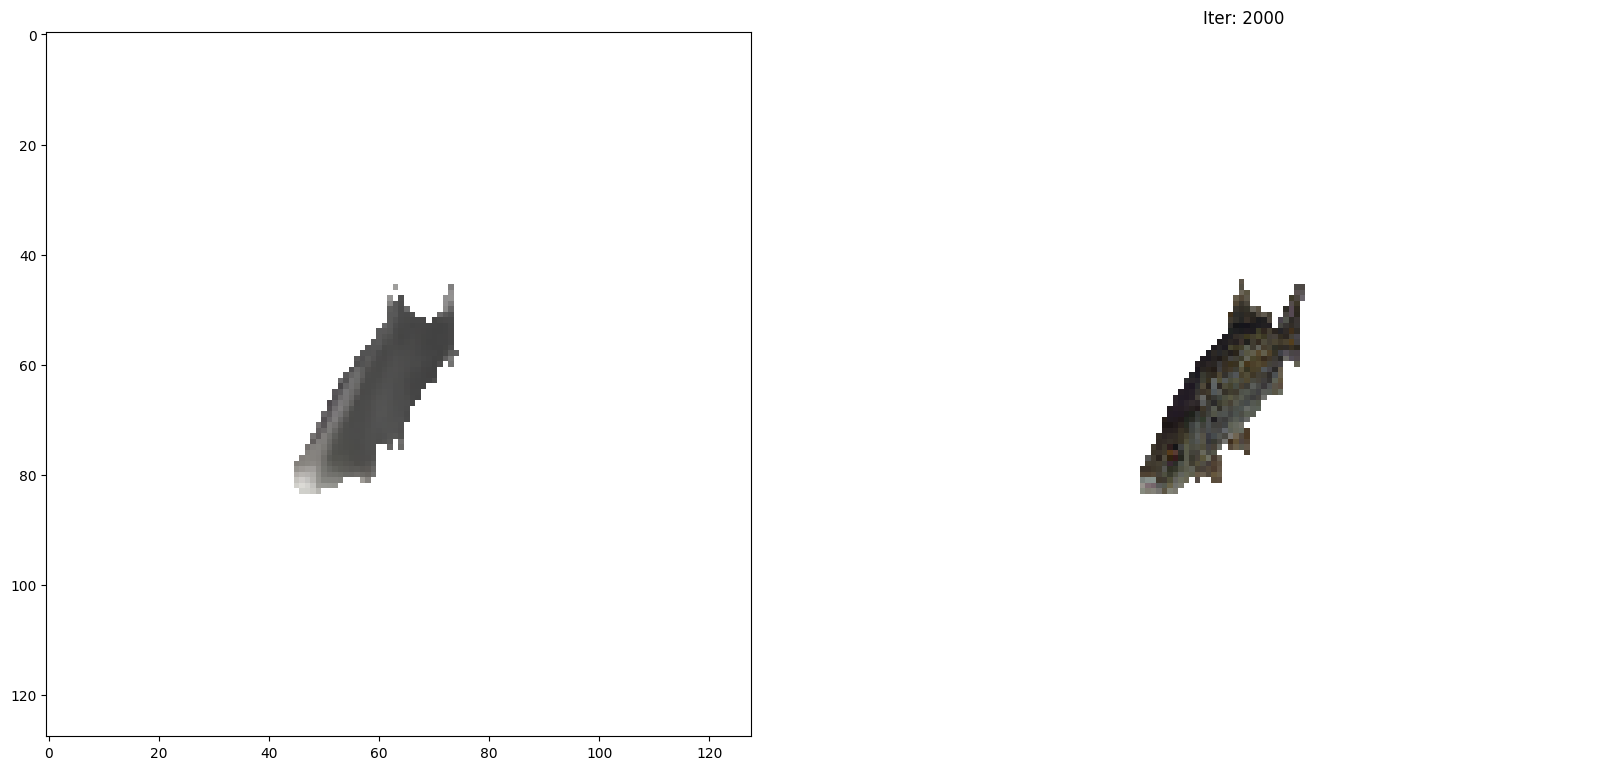

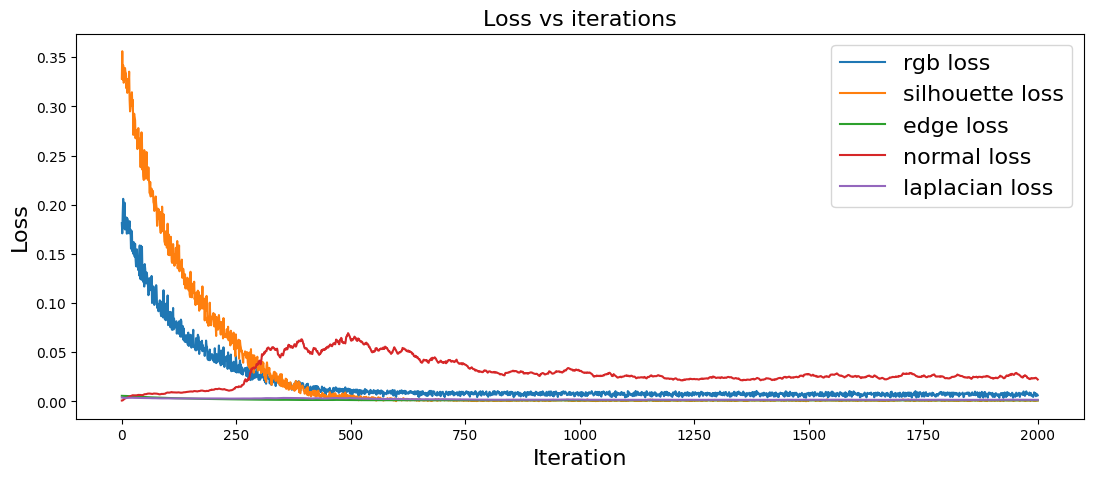

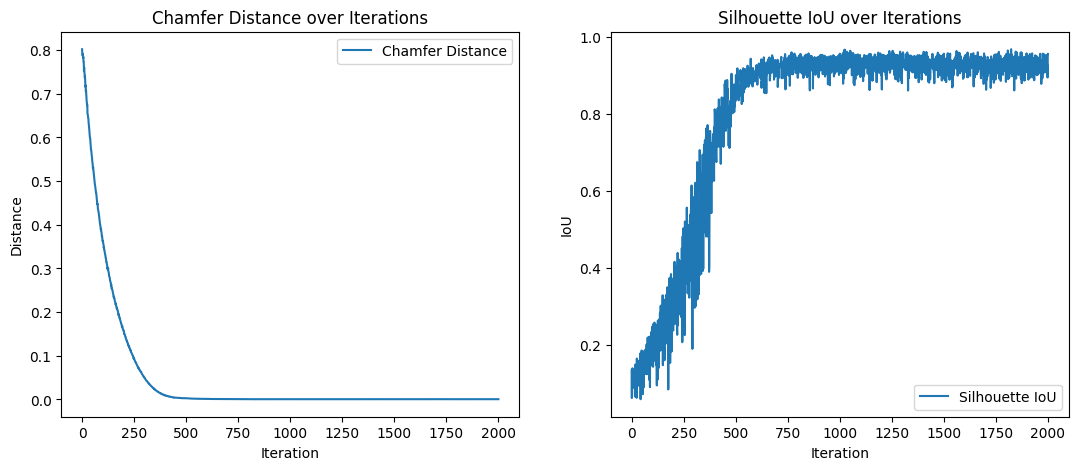

Training cycle with object 3 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

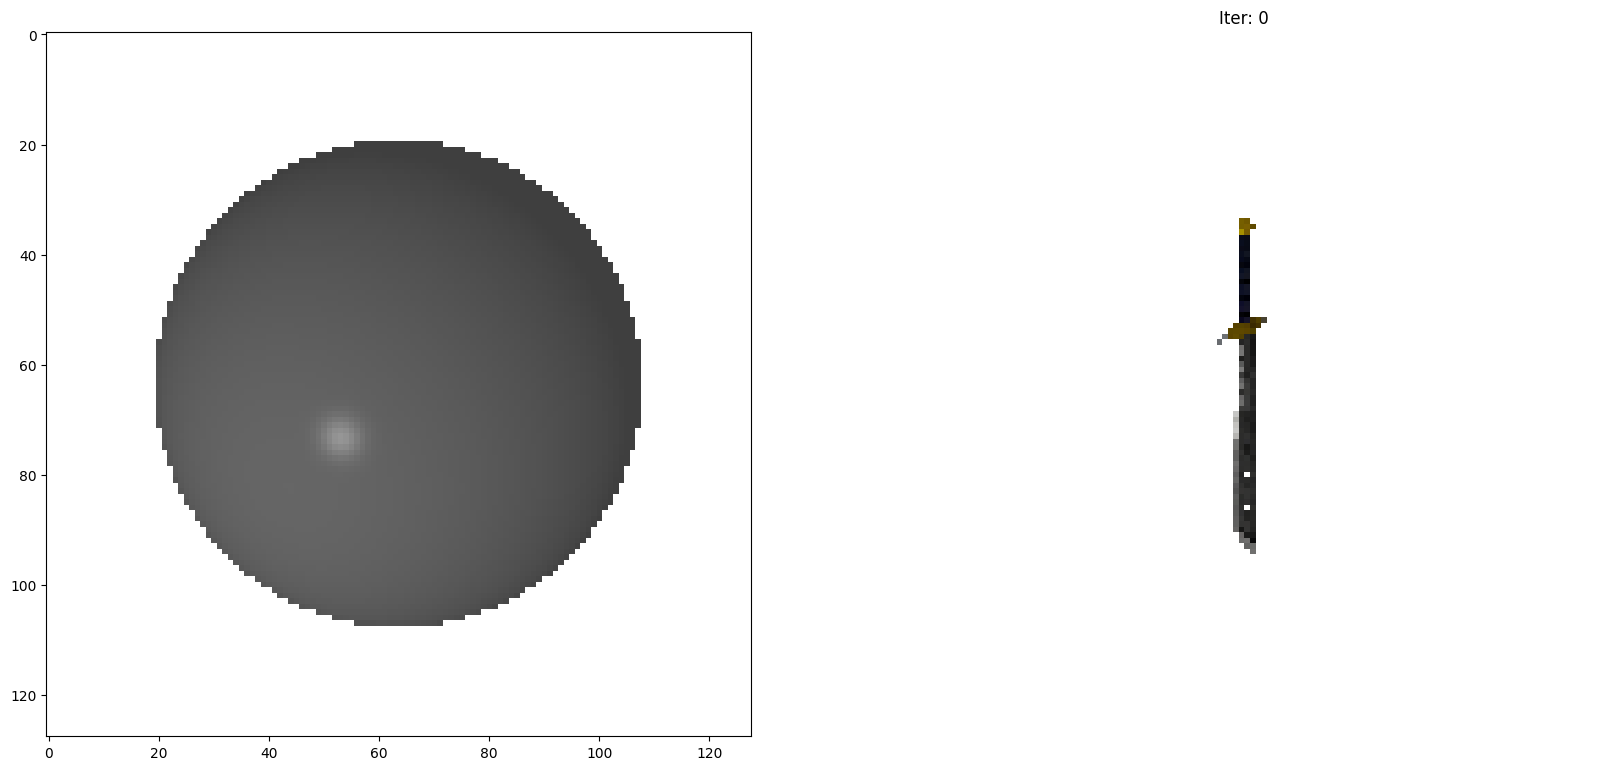

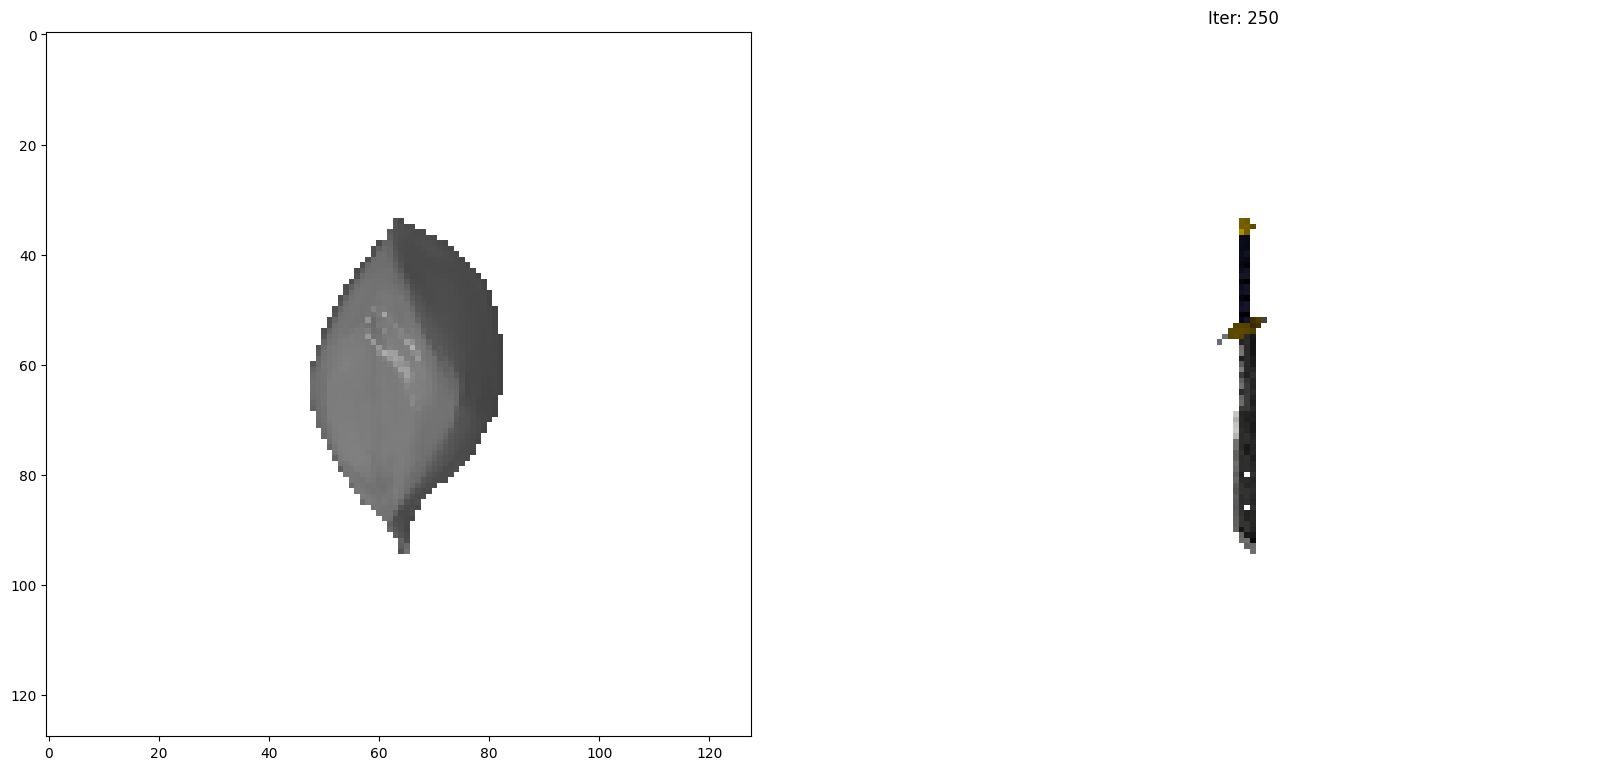

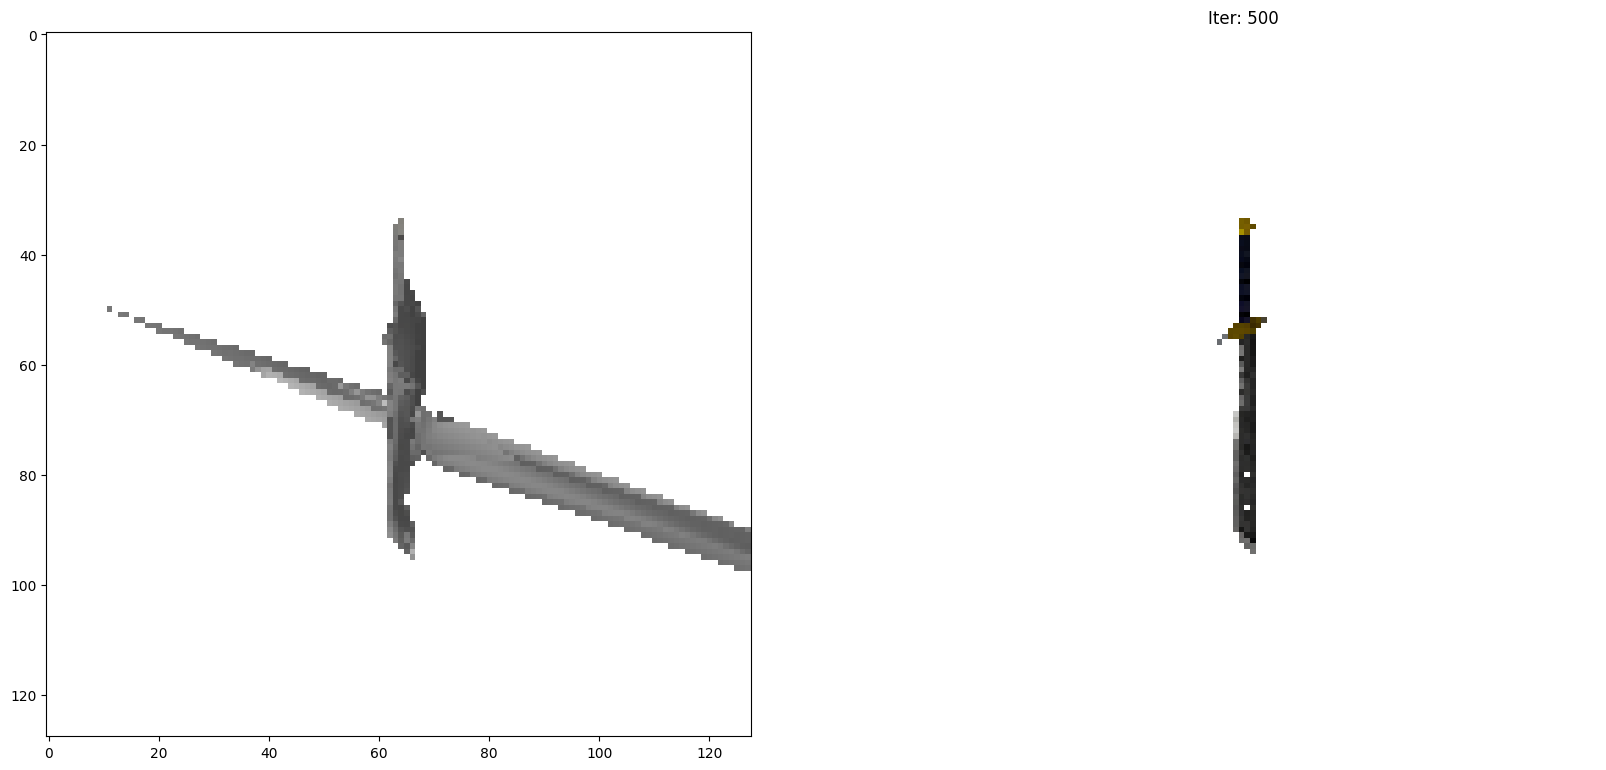

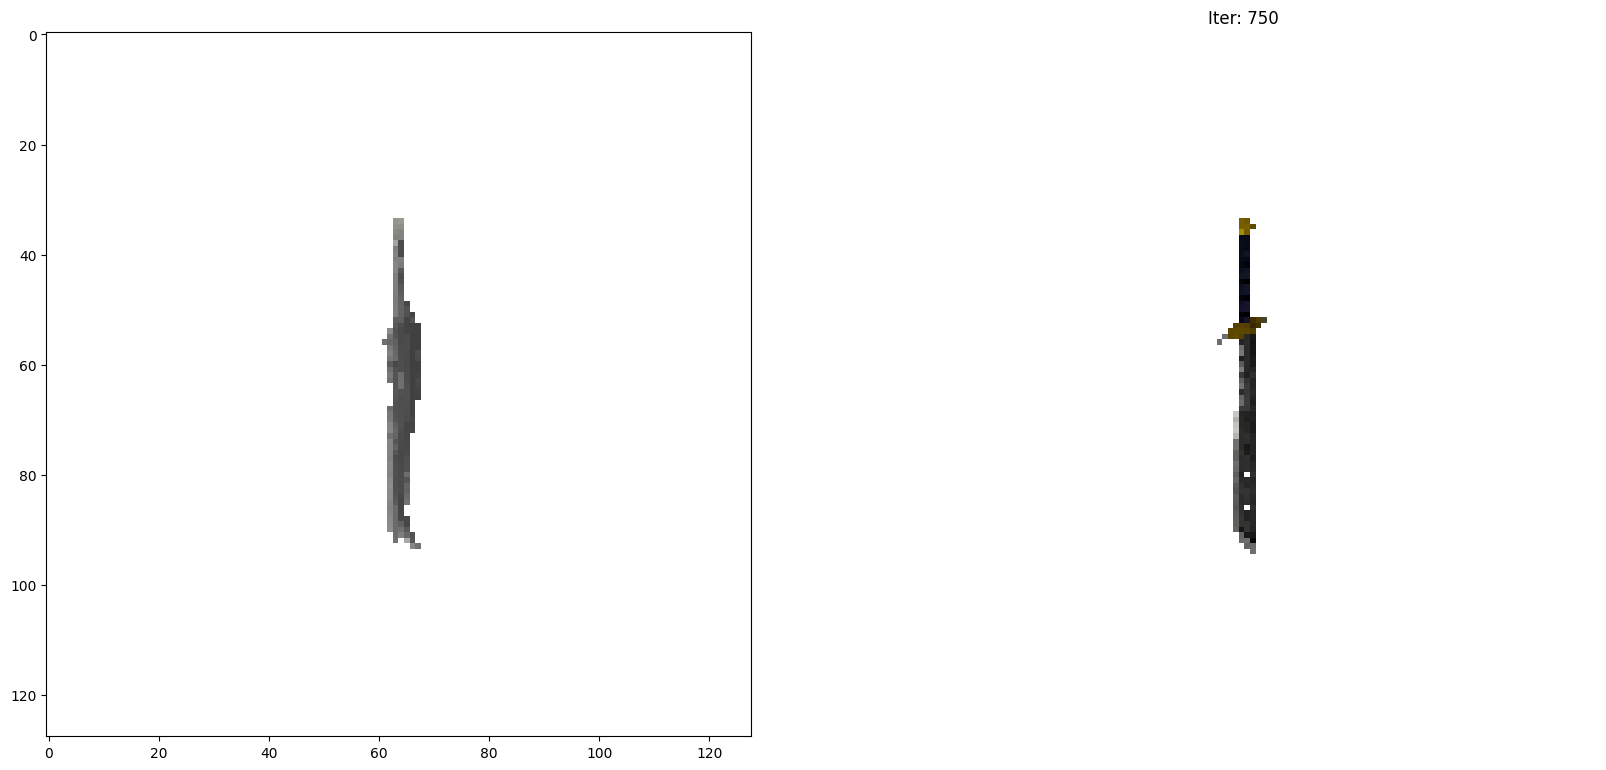

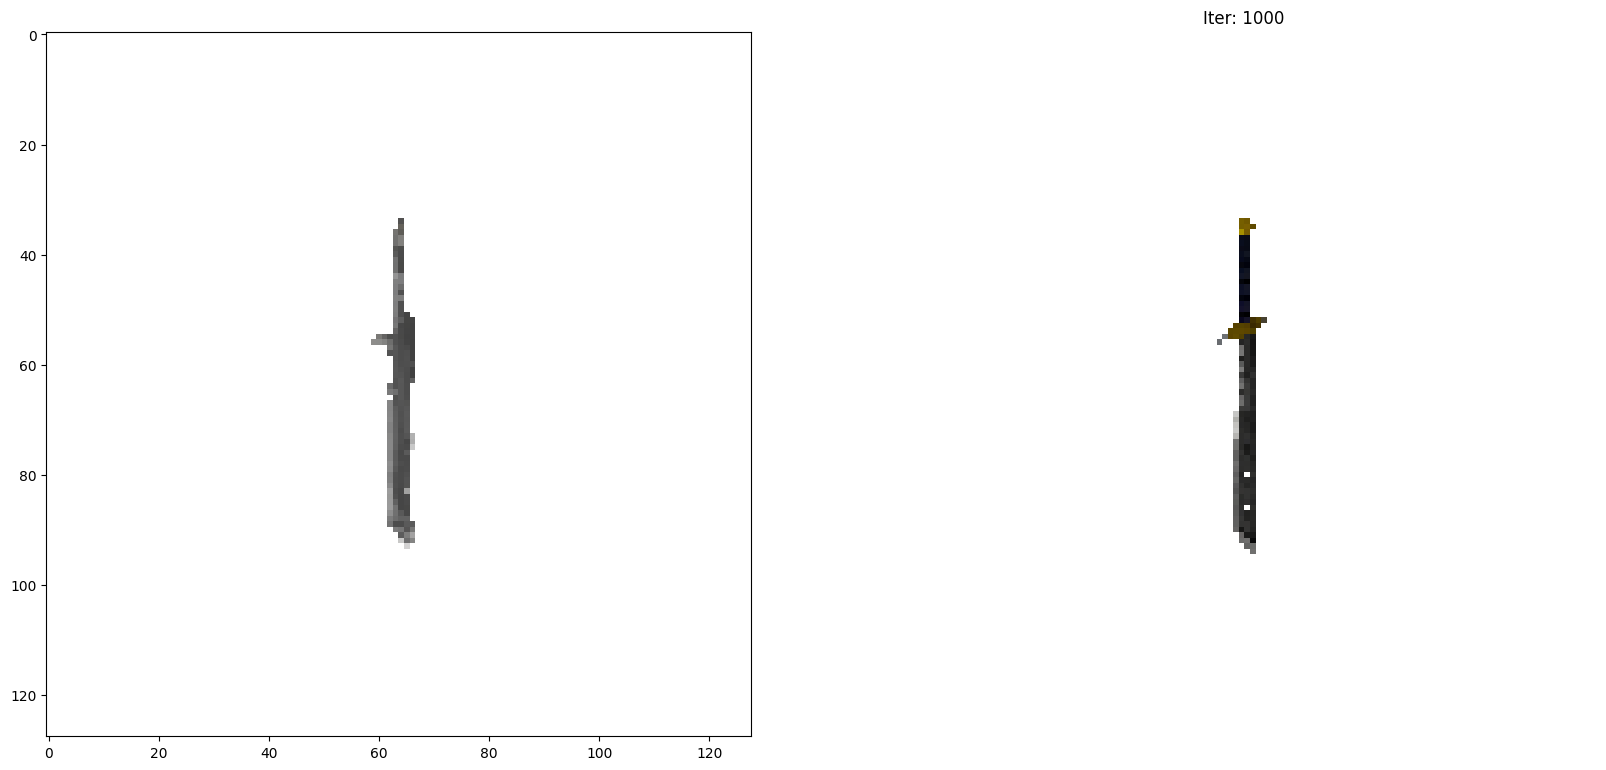

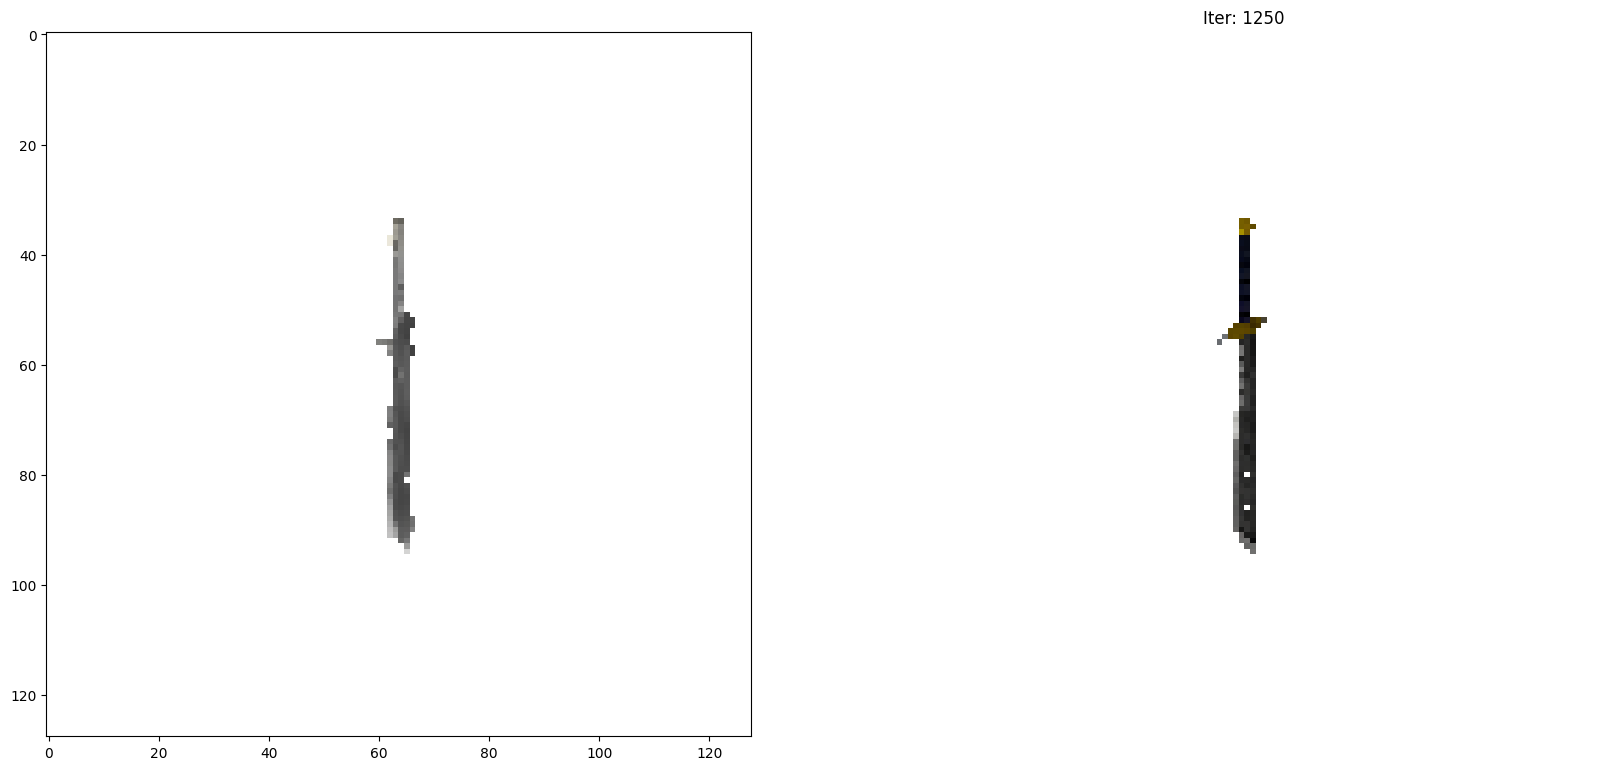

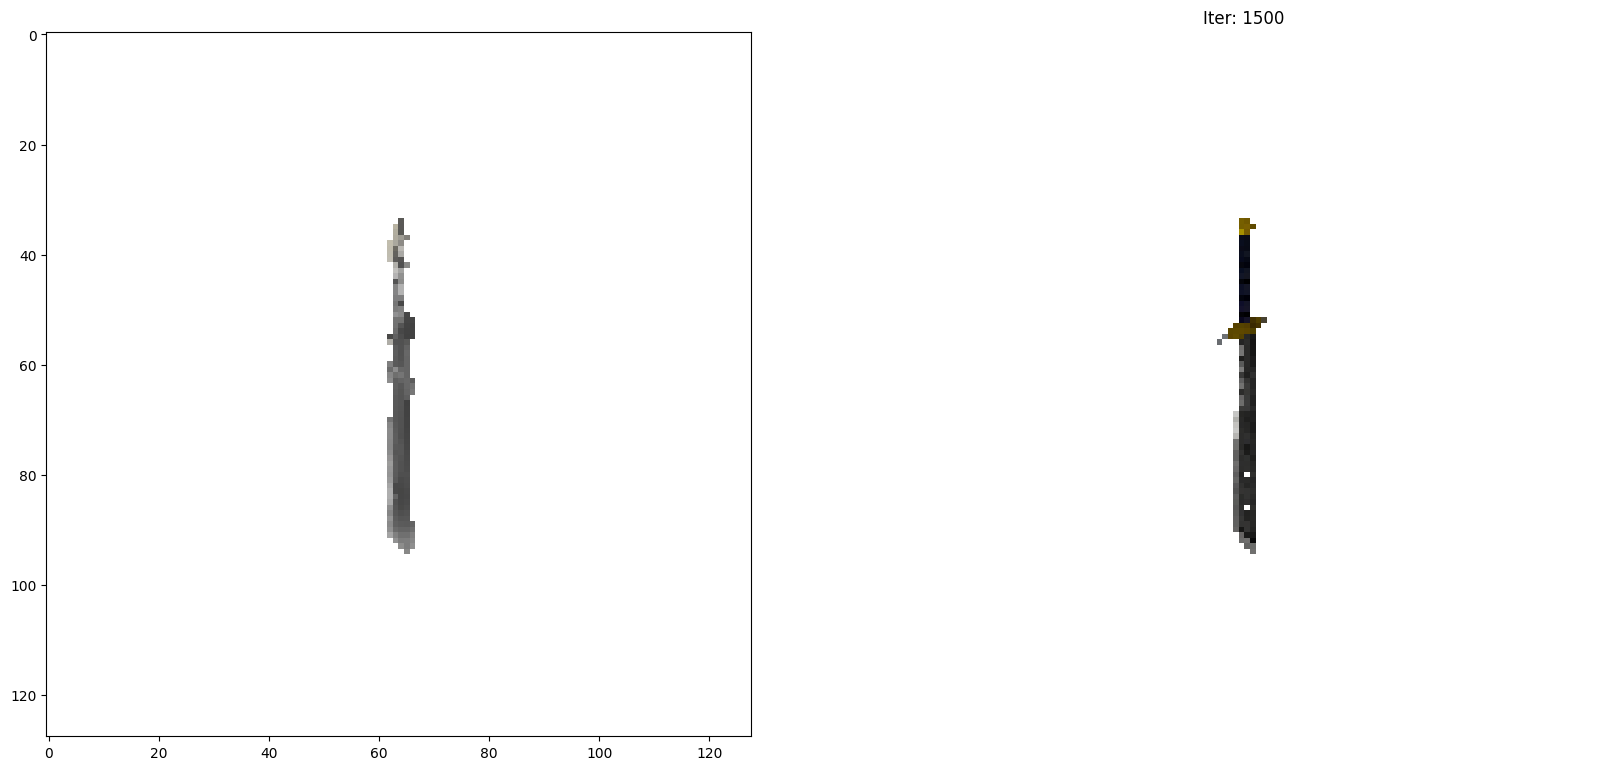

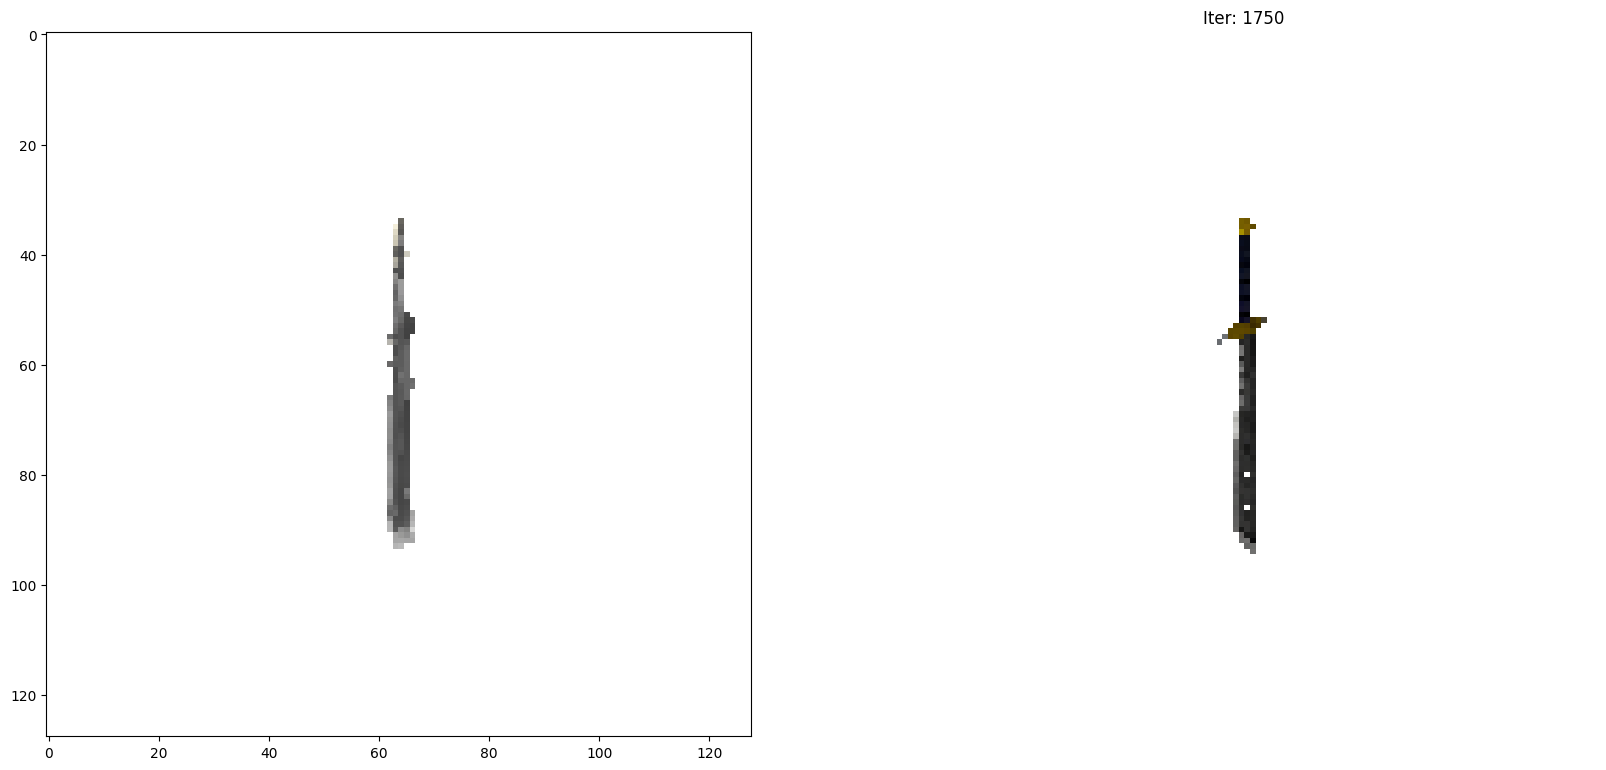

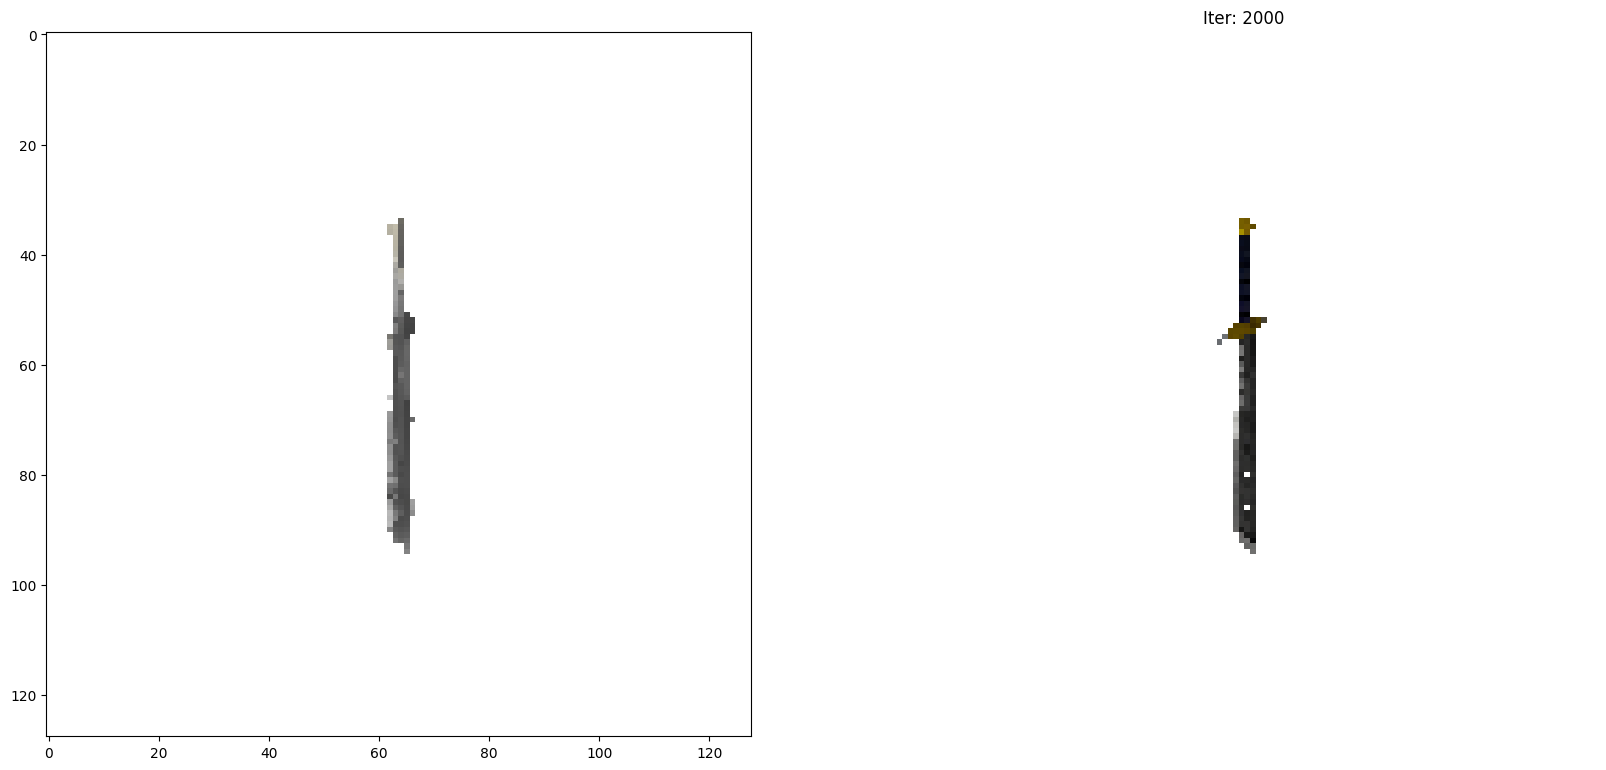

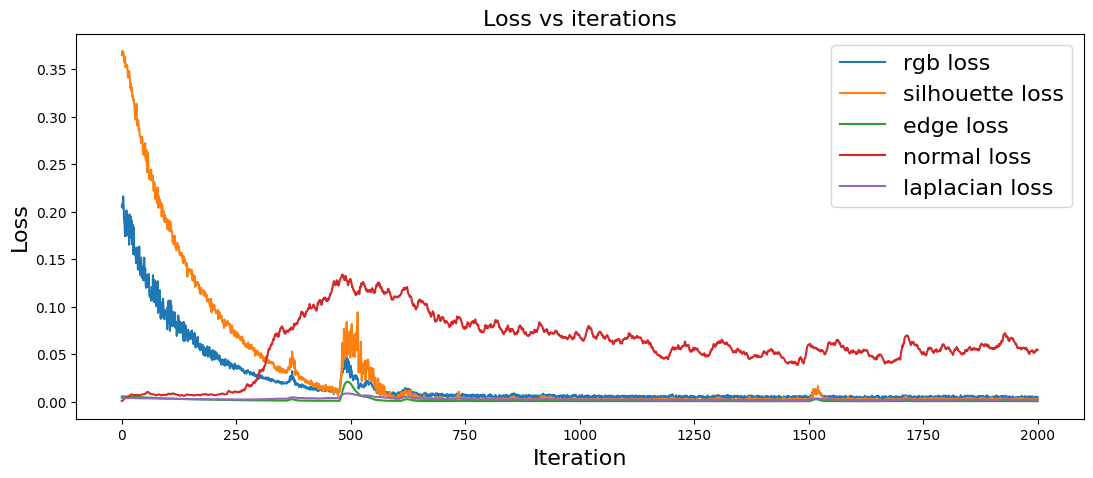

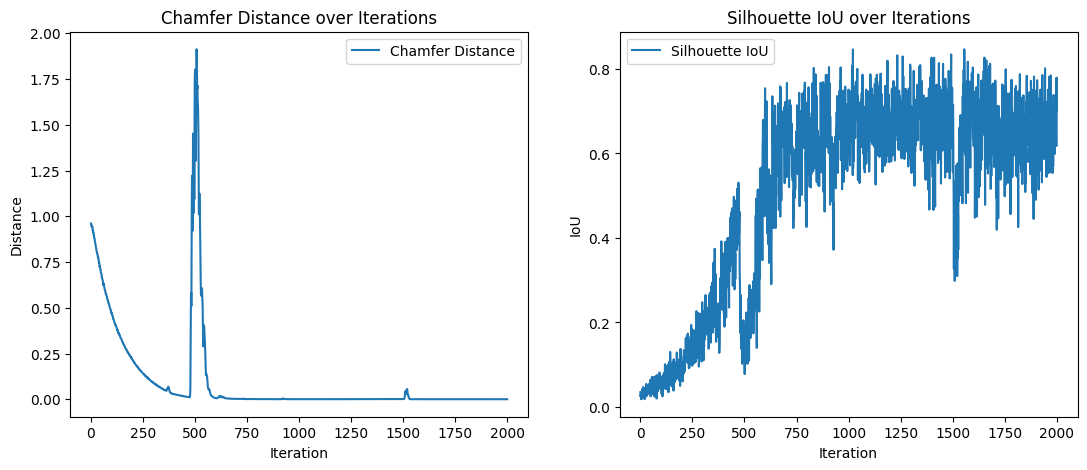

Training cycle with object 4 completed.


  0%|          | 0/2001 [00:00<?, ?it/s]

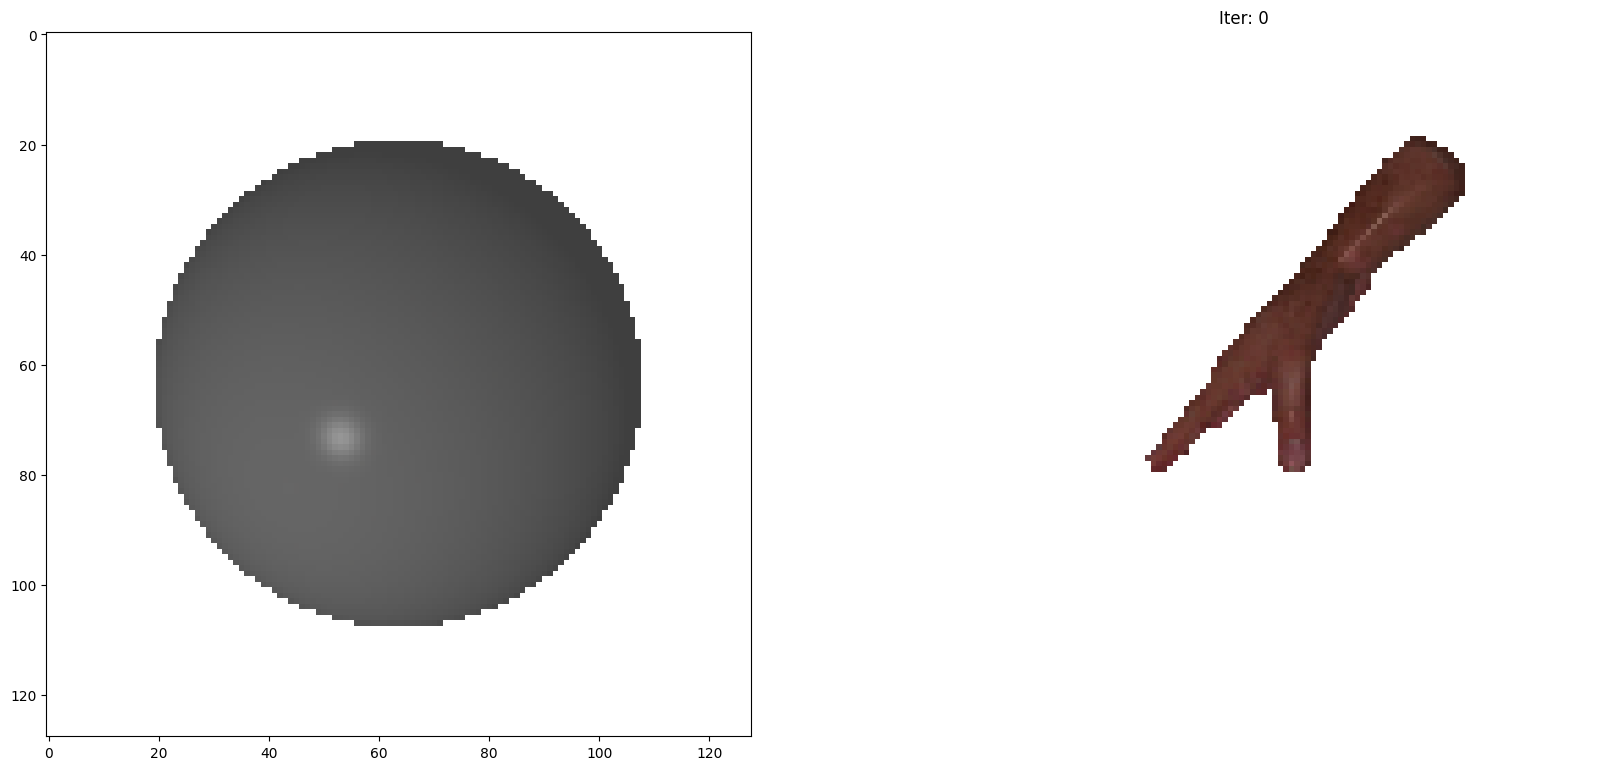

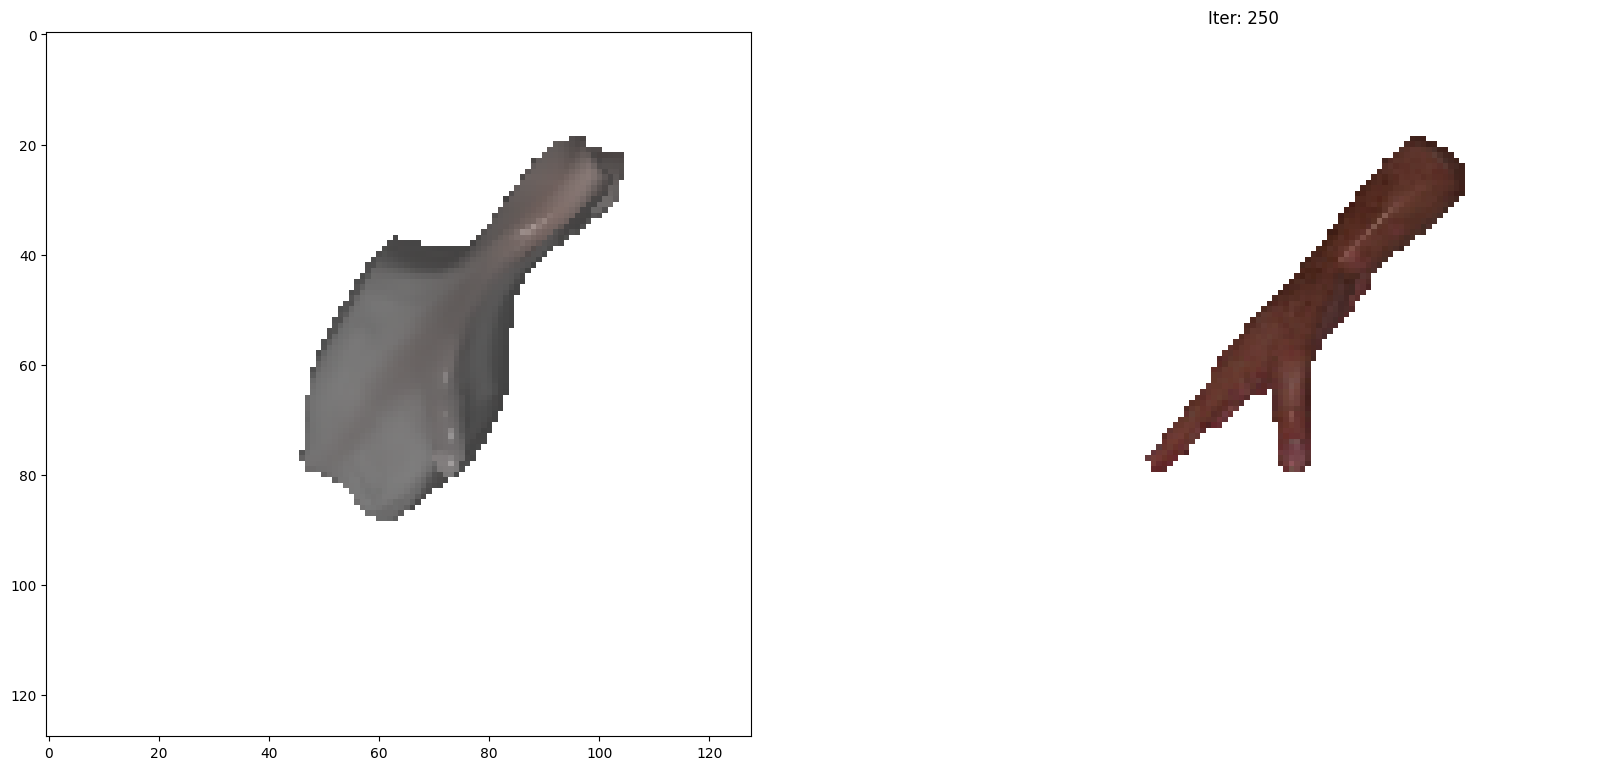

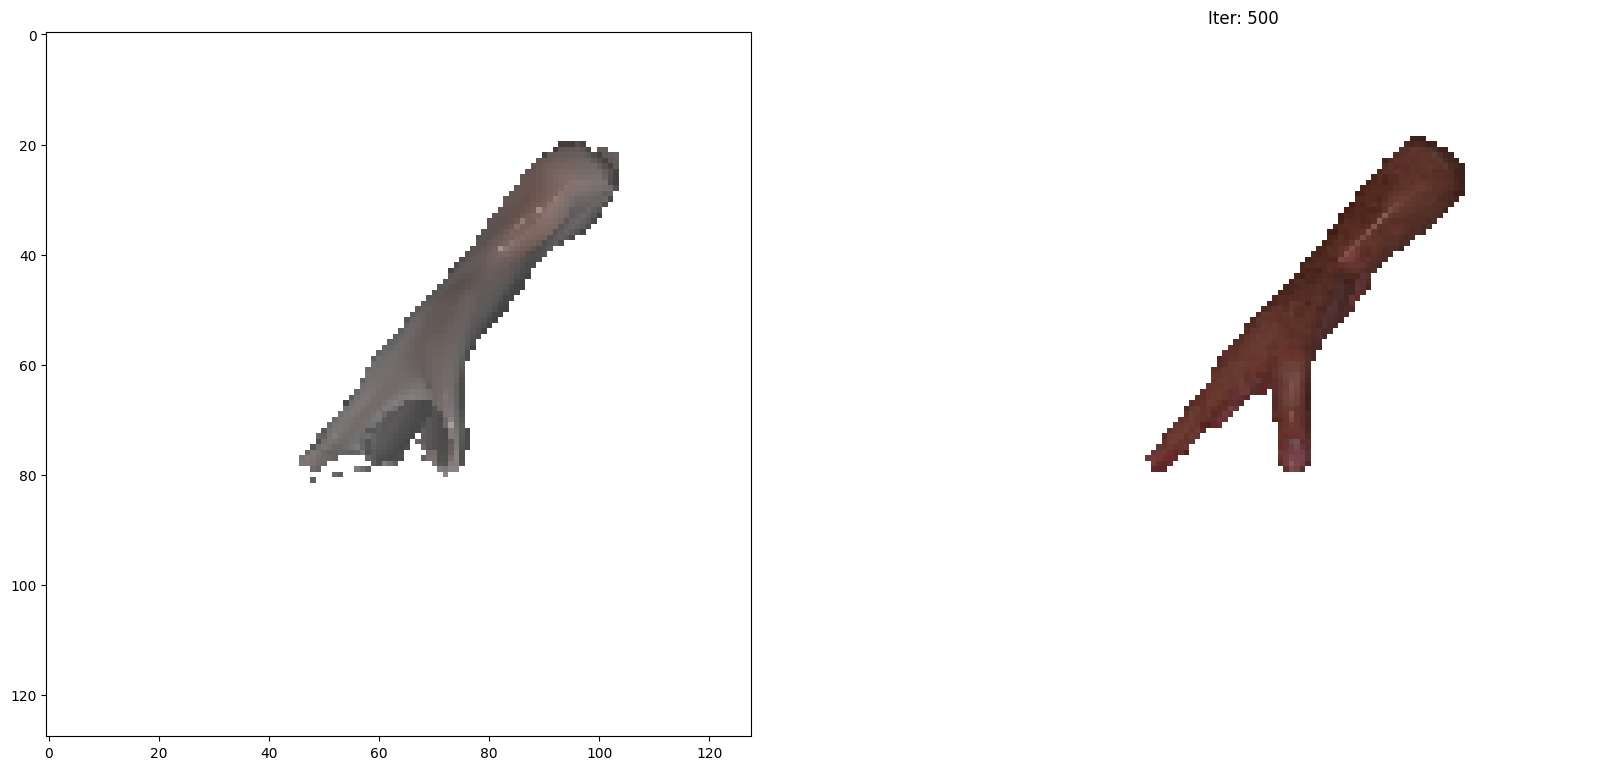

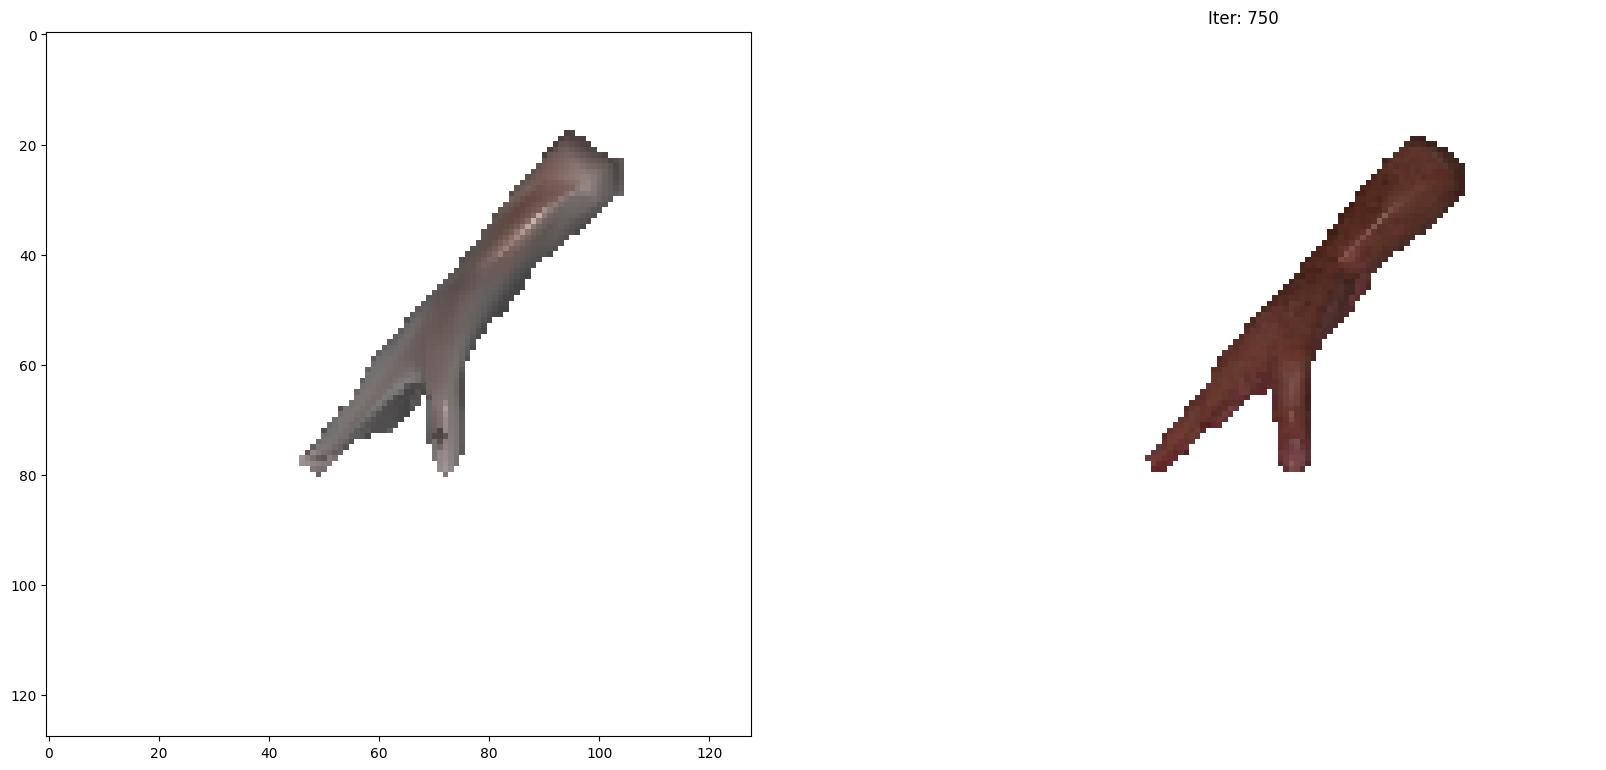

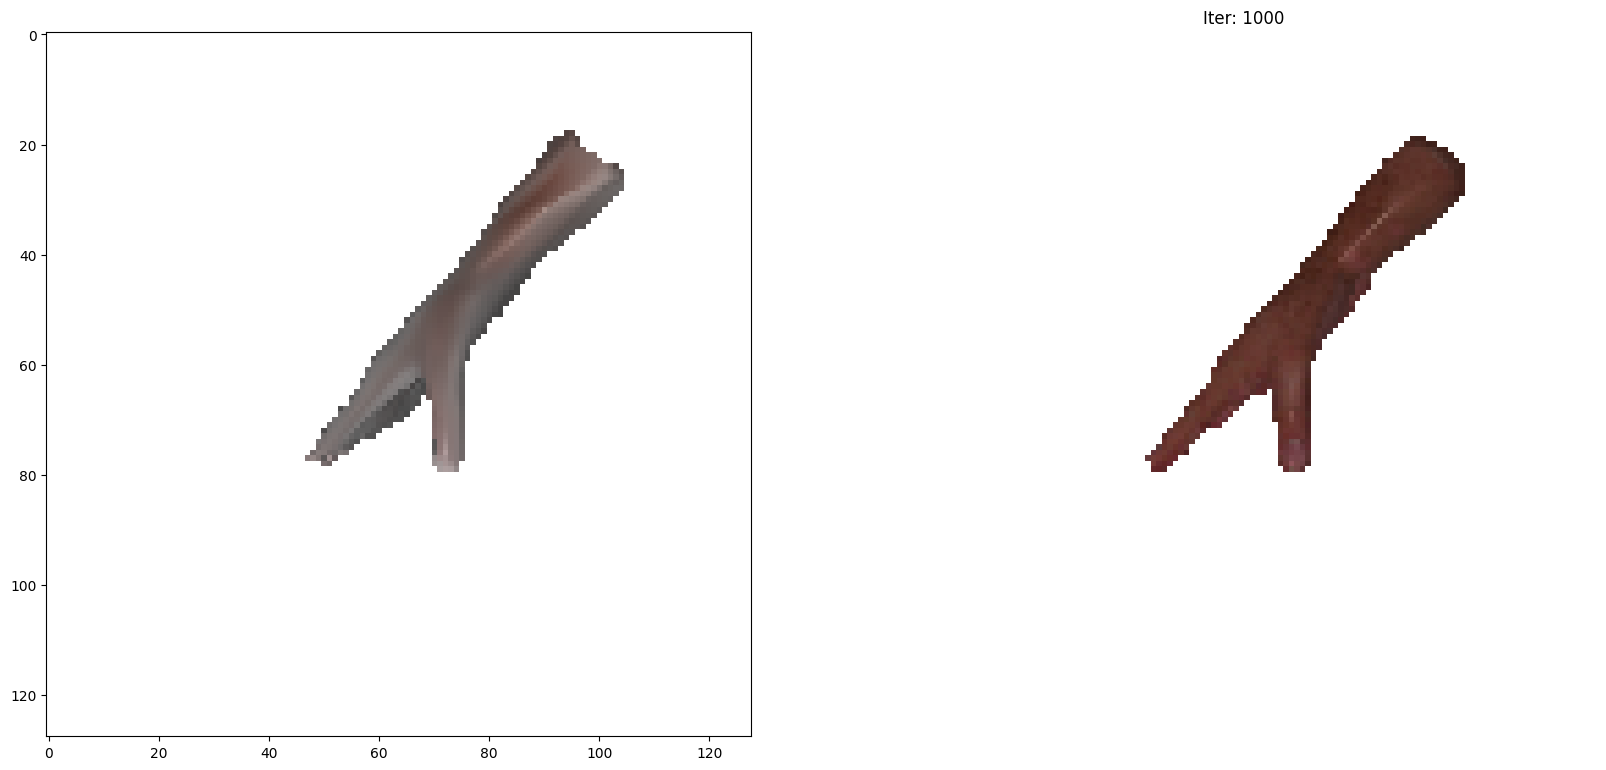

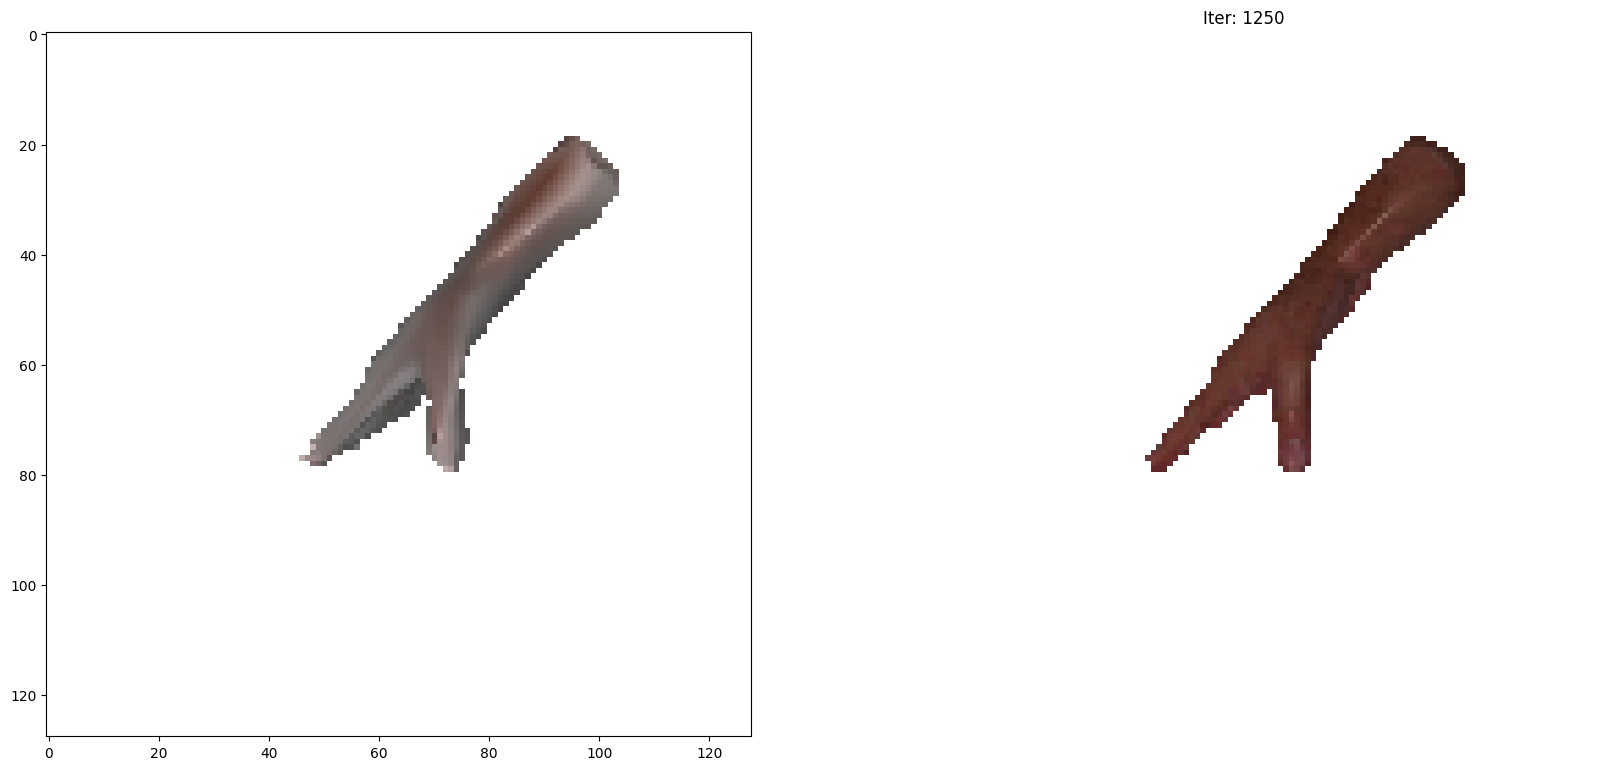

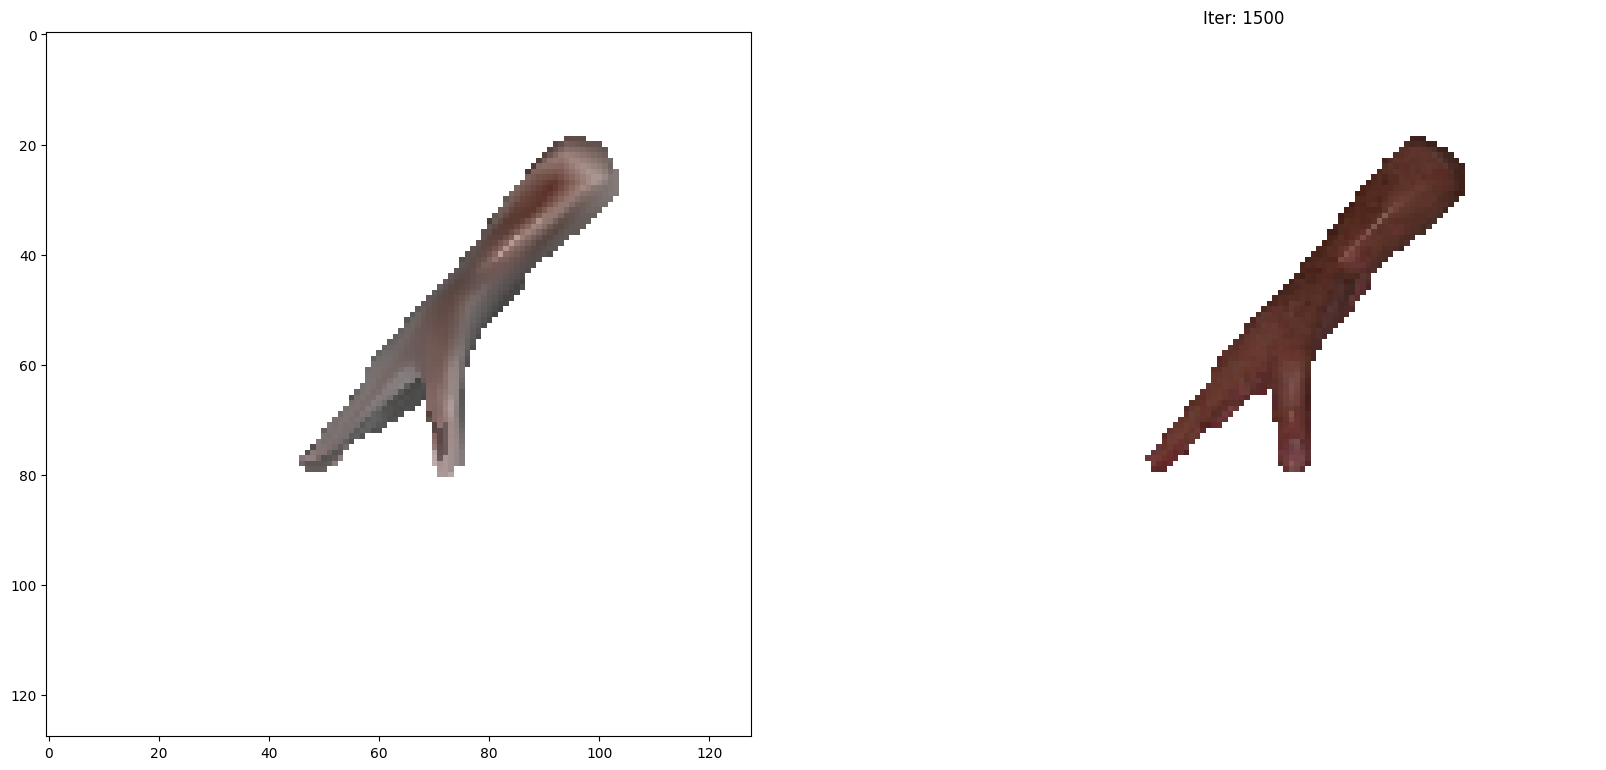

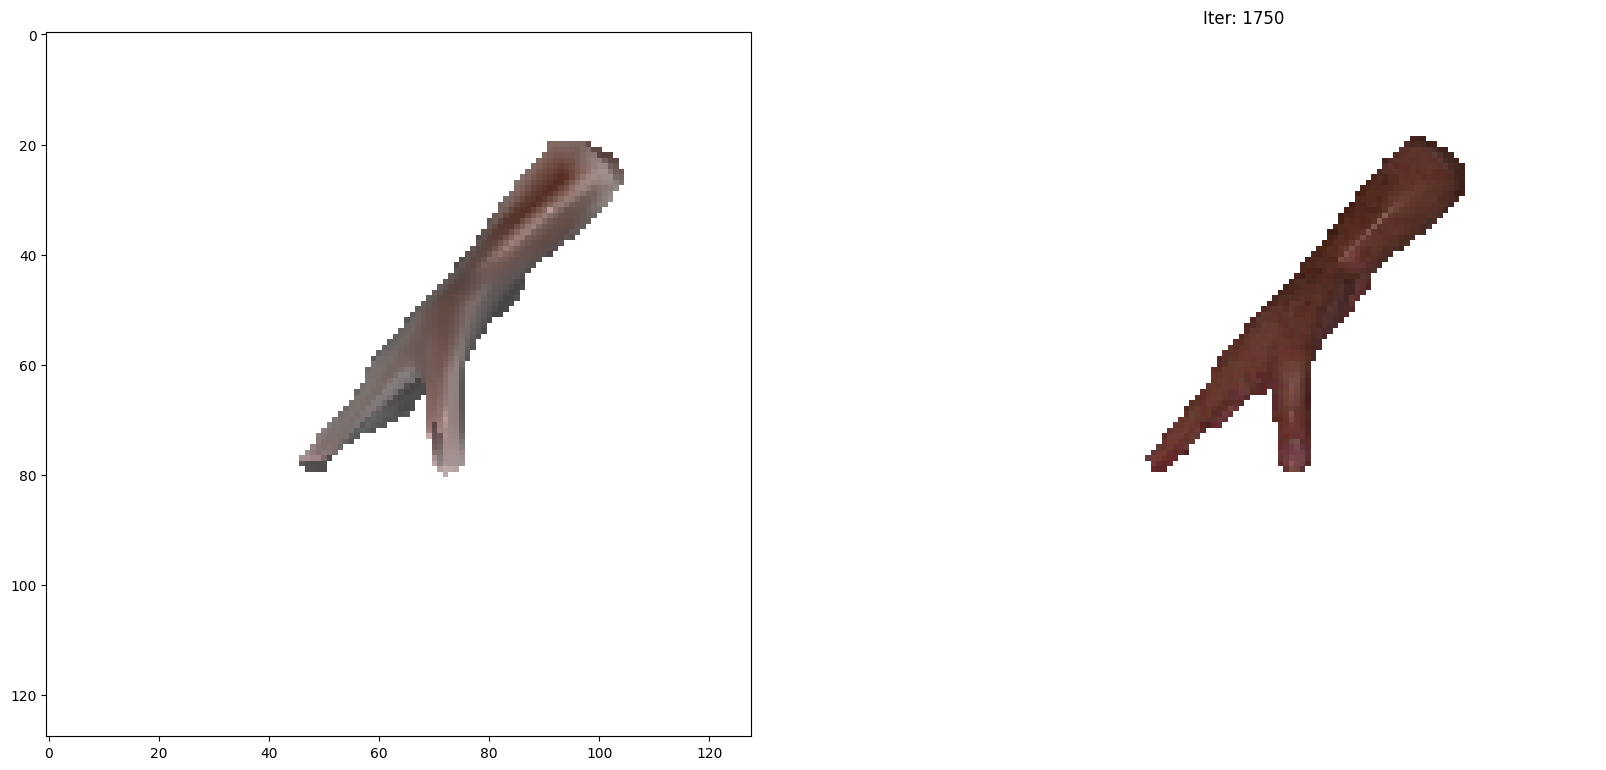

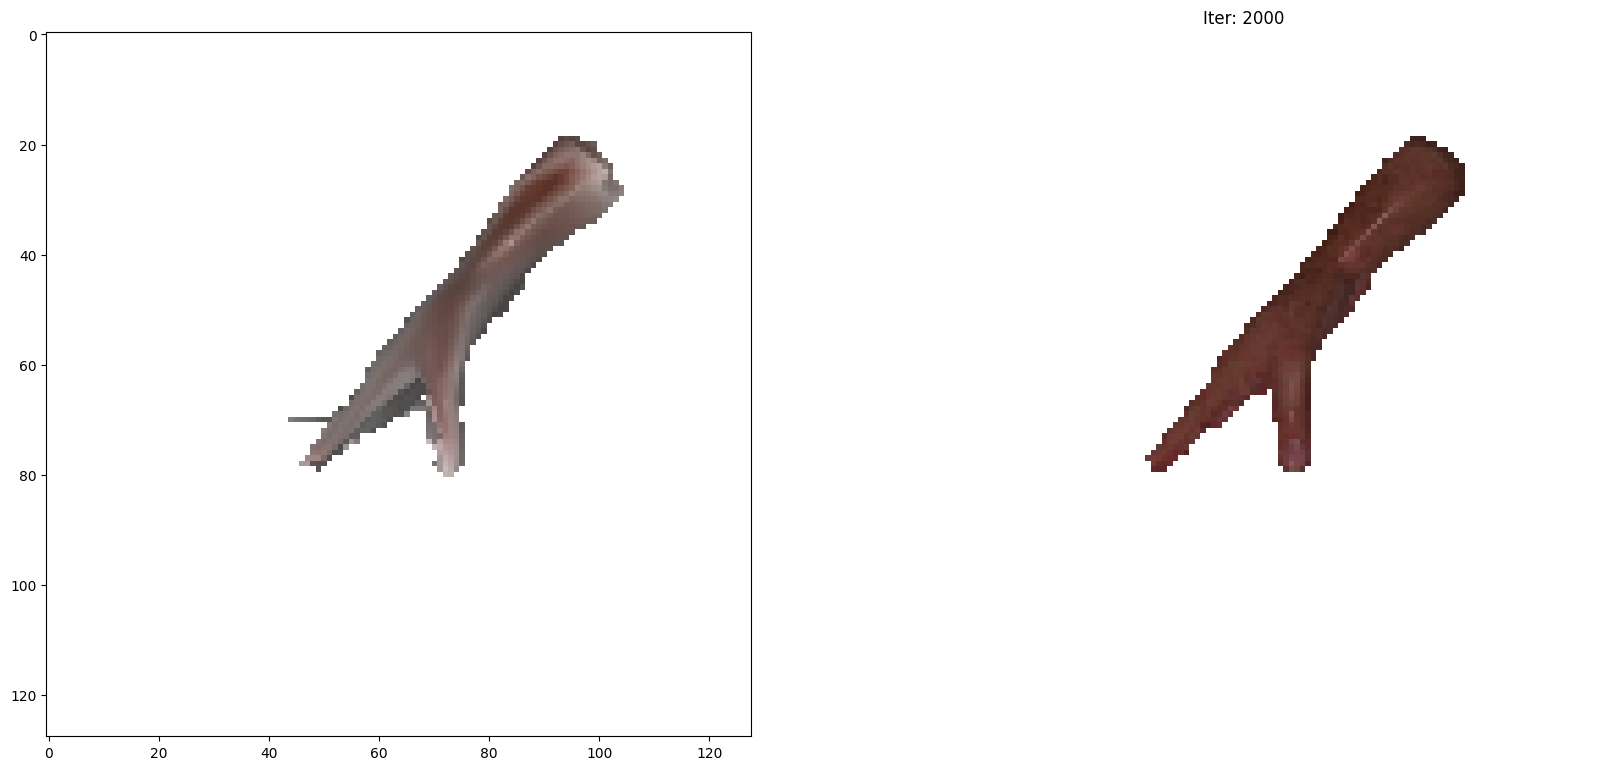

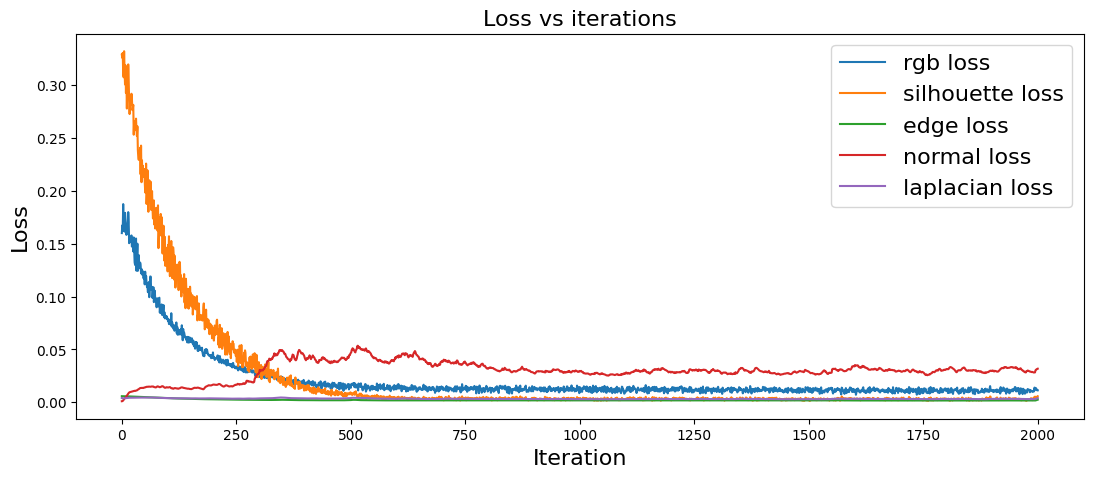

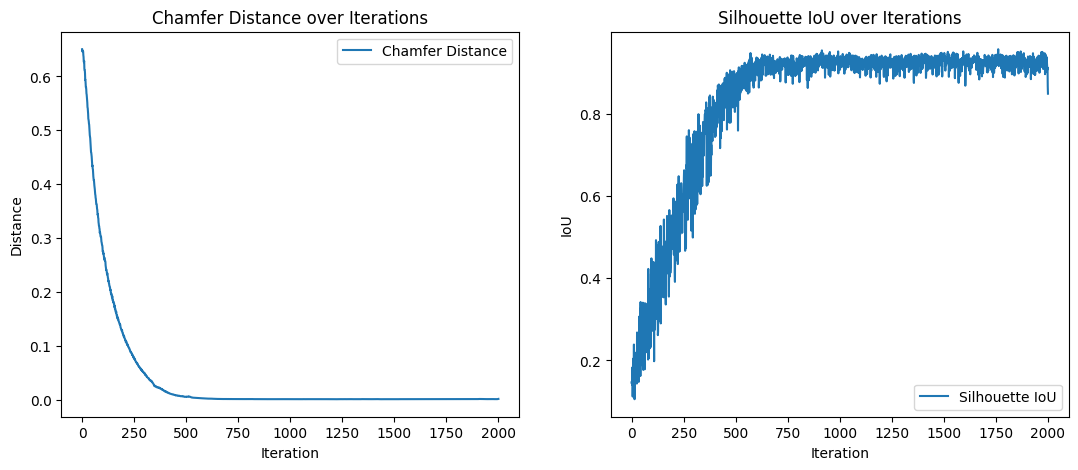

Training cycle with object 5 completed.


In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Training loop with adversarial training
Niter = 2001
plot_period = 250

# Initialize src_mesh once
src_mesh = ico_sphere(4, device)
# Initialize texture once
initial_texture = torch.full([1, src_mesh.verts_packed().shape[0], 3], 0.5, device=device, requires_grad=True)

for mesh_idx, (target_rgb, target_cameras, target_silhouette) in enumerate(zip(target_images_list, target_cameras_list, target_silhouette_list)):

    verts_shape = src_mesh.verts_packed().shape
    deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
    sphere_verts_rgb = initial_texture.clone().detach().requires_grad_(True)

    optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

    losses = {"rgb": {"weight": 1.0, "values": []},
              "silhouette": {"weight": 1.0, "values": []},
              "edge": {"weight": 1.0, "values": []},
              "normal": {"weight": 0.01, "values": []},
              "laplacian": {"weight": 1.0, "values": []},
             }

    chamfer_distances = []
    iou_values = []

    loop = tqdm(range(Niter))

    for i in loop:
        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)
        new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)

        # Generator part
        optimizer.zero_grad()

        # Losses to smooth /regularize the mesh shape
        loss = {k: torch.tensor(0.0, device=device) for k in losses}
        update_mesh_shape_prior_losses(new_src_mesh, loss)

        chamfer_losses = []
        iou_losses = []

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
            images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted silhouette and the target
            # silhouette from the dataset
            predicted_silhouette = images_predicted[..., 3]
            loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            loss["silhouette"] += loss_silhouette / num_views_per_iteration

            # Squared L2 distance between the predicted RGB image and the target
            # image from the dataset
            loss_rgb = ((images_predicted[..., :3] - target_rgb[j]) ** 2).mean()
            loss["rgb"] += loss_rgb / num_views_per_iteration

            # Sample 5k points from the surface of each mesh
            sample_trg = sample_points_from_meshes(meshes[mesh_idx], 5000)
            sample_src = sample_points_from_meshes(new_src_mesh, 5000)
            # Compute Chamfer Distance
            chamfer_loss, _ = chamfer_distance(sample_trg, sample_src)
            chamfer_losses.append(chamfer_loss.item())

            # Compute Silhouette IoU
            iou_loss = compute_silhouette_iou(predicted_silhouette > 0.5, target_silhouette[j] > 0.5)
            iou_losses.append(iou_loss)

        # Weighted sum of the losses
        sum_loss = 0
        for k, l in loss.items():
            sum_loss += l * losses[k]["weight"]
            losses[k]["values"].append(float(l.detach().cpu()))

        # Store the Chamfer Distance and IoU values
        chamfer_distances.append(sum(chamfer_losses) / len(chamfer_losses))
        iou_values.append(sum(iou_losses) / len(iou_losses))

        loop.set_description("total_loss = %.6f chamfer_distance = %.6f IoU_value = %.6f" % (sum_loss, chamfer_distances[-1], iou_values[-1]))
        sum_loss.backward()
        optimizer.step()

        if i % plot_period == 0:
            visualize_prediction(new_src_mesh, renderer=renderer, target_image=target_images_list[mesh_idx][1], title=f"Iter: {i}")

    plot_losses(losses)

    # Plot Chamfer Distance and IoU
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(chamfer_distances, label="Chamfer Distance")
    plt.xlabel("Iteration")
    plt.ylabel("Distance")
    plt.title("Chamfer Distance over Iterations")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_values, label="Silhouette IoU")
    plt.xlabel("Iteration")
    plt.ylabel("IoU")
    plt.title("Silhouette IoU over Iterations")
    plt.legend()

    plt.show()

    print(f'Training cycle with object {mesh_idx+1} completed.')